# Modeling the Nonthermal Pressure Fraction and $Y_\mathrm{SZ}-M$ Relation

## Cosmologies and Concentration Definitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import colossus
from colossus.cosmology import cosmology
from colossus.lss import peaks
from colossus.halo import concentration, mass_so, profile_nfw, mass_defs
from plotter import plot, loglogplot
from scipy.interpolate import InterpolatedUnivariateSpline as interp
from astropy.cosmology import FlatLambdaCDM, z_at_value
from sklearn.linear_model import LinearRegression
import astropy.units as u
import subprocess
from numba import jit, njit, prange
from os import getcwd
from os.path import isfile
from scipy.integrate import quad
import warnings
import seaborn as sns
from pathlib import Path
from os.path import expanduser
%matplotlib inline

In [2]:
home_dir = Path(expanduser('~'))
multimah_root = home_dir / 'frank_mah/output'
obs_data_dir = home_dir / 'research/nth_frac_cosmology/obs_data'

In [3]:
# will need to test sensitivity to:
# 1. c(M,z) relationship: Zhao+09, Duffy+08, Diemer+19
# 2. MAH model: Zhao+09, vdB+14, Parkinson+08 merger trees
# 3. Various cosmologies

In [4]:
# global variables
# free parameters of Shi+14 model; can be changed later
beta_def = 1.0
eta_def  = 0.7

G = colossus.utils.constants.G
cm_per_km = 1e5
km_per_kpc = colossus.utils.constants.KPC / cm_per_km # KPC was in cm
s_per_Gyr = colossus.utils.constants.GYR
yr_per_Gyr = 1E9

# can reset cosmology on-the-fly, will start with WMAP 5
cosmo = cosmology.setCosmology('WMAP5')
cosmo_astro = FlatLambdaCDM(H0=cosmology.getCurrent().H0 * u.km / u.s / u.Mpc, Tcmb0=cosmology.getCurrent().Tcmb0 * u.K, Om0=cosmology.getCurrent().Om0, Neff=cosmology.getCurrent().Neff, Ob0=cosmology.getCurrent().Ob0)

# adding a modified EdS
eds_params = cosmology.cosmologies['EdS']
#eds_params['Om0'] = 0.99 # not sure why this isn't the solution...
eds_params['Ob0'] = 0.001
cosmology.addCosmology('near_EdS', eds_params)

# let's make some various cosmologies perturbed from planck18 fiducial
# we can go up and down in sigma_8
# then go up and down in omega_m
# then go up and down in h
fiducial_params = cosmology.cosmologies['planck18'].copy() # can always change the fiducial if we want
fiducial_params['Om0'] = 0.1
cosmology.addCosmology('pl18_lowOm0', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['Om0'] = 0.5
cosmology.addCosmology('pl18_hiOm0', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy() # reset to default
fiducial_params['sigma8'] = 0.5
cosmology.addCosmology('pl18_lows8', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['sigma8'] = 1.2
cosmology.addCosmology('pl18_his8', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy() # reset to default
fiducial_params['H0'] = 60
cosmology.addCosmology('pl18_lowH0', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['H0'] = 80
cosmology.addCosmology('pl18_hiH0', fiducial_params)

print(cosmology.getCurrent())

Cosmology "WMAP5" 
    flat = True, Om0 = 0.2732, Ode0 = 0.7267, Ob0 = 0.0456, H0 = 70.50, sigma8 = 0.8120, ns = 0.9600
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [5]:
# cosmologies to test the effect of varying S8 instead...
# S_8 = sigma_8 * sqrt(Omega_m / 0.3)

cosmology.setCosmology('planck18')

def S8_cosmo(cosmo):
    return cosmo.sigma8 * np.sqrt(cosmo.Om0 / 0.3)
print(S8_cosmo(cosmology.getCurrent()))

# so 0.825 is S8 for planck18
# we need to now vary this up and down by varying 

fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['sigma8'] = 1.0
fiducial_params['Om0'] = 0.3
cosmology.addCosmology('pl18_s8_1_1', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['sigma8'] = 0.8
fiducial_params['Om0'] = 0.469
cosmology.addCosmology('pl18_s8_1_2', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['sigma8'] = 0.6
fiducial_params['Om0'] = 0.3
cosmology.addCosmology('pl18_s8_p6_1', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['sigma8'] = 0.5
fiducial_params['Om0'] = 0.432
cosmology.addCosmology('pl18_s8_p6_2', fiducial_params)

# dictionary of names for different cosmologies
cosmo_dict = {'near_EdS': 'eeddss', 'WMAP5': 'WMAP05', 'planck18': 'plnk18', 
              'pl18_lowOm0': 'p8loOm', 'pl18_hiOm0': 'p8hiOm', 'pl18_lows8': 'p8los8',
              'pl18_his8': 'p8his8', 'pl18_lowH0': 'p8loH0', 'pl18_hiH0': 'p8hiH0',
              'pl18_s8_1_1': 'p8s811', 'pl18_s8_1_2': 'p8s812', 'pl18_s8_p6_1': 'p8s861',
              'pl18_s8_p6_2': 'p8s862'}

cosmo = cosmology.setCosmology('WMAP5')

0.8250525616468322


Text(0, 0.5, '$c$')

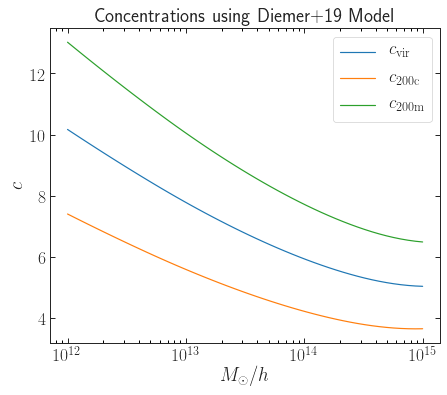

In [7]:
# mass-concentration relationships
# Original Shi paper used duffy08 and vdB+14 used the c(M,z) of Zhao+09
# need to make sure that we use consistent definitions of virial radius, thus concentration, everywhere
# takes the z=0 mass in units of Msun/h
nm = 50
masses = np.logspace(12,15,nm)
cvirs = concentration.concentration(masses, 'vir', 0.0, model = 'diemer19')
c200cs = concentration.concentration(masses, '200c', 0.0, model = 'diemer19')
c200ms = concentration.concentration(masses, '200m', 0.0, model = 'diemer19')
plot(semilogx=True)
plt.plot(masses, cvirs, label=r'$c_\mathrm{vir}$')
plt.plot(masses, c200cs, label=r'$c_\mathrm{200c}$')
plt.plot(masses, c200ms, label=r'$c_\mathrm{200m}$')
plt.title(r'Concentrations using Diemer+19 Model')
plt.legend()
plt.xlabel(r'$M_\odot / h$')
plt.ylabel(r'$c$')

# TODO: vdB+14 uses Zhao et al. 2009, not available in Colossus, so may need to code that up
# this uses the lookback time instead of redshift, so need to get z from t
# NOTE: vdB+14 paper and code use slightly different formulas
# We probably want to use one of the all-cosmology c(M,z) since we will use different definitions of the virial radius

## Komatsu and Seljak Model

In [8]:
# computing t_d from t_dyn
# the masses are in Msun/h
# the lengths for haloes are in kpc/h
def NFWf(x):
    return np.log(1. + x) - x/(1. + x)

# accepts radius in physical kpc/h
# might change this...
def NFWM(r, M, z, c, R):
    return M * NFWf(c*r/R) / NFWf(c)

def t_d(r, M, z, c, R, beta=beta_def):
    Menc = NFWM(r, M, z, c, R)
    t_dyn = 2. * np.pi * (r**3 / (G*Menc))**(1./2.) * km_per_kpc / (cosmology.getCurrent().H0 / 100.)
    return beta * t_dyn / s_per_Gyr / 2.

6.242115649063551


Text(0, 0.5, '$t_\\mathrm{d}$ [Gyr]')

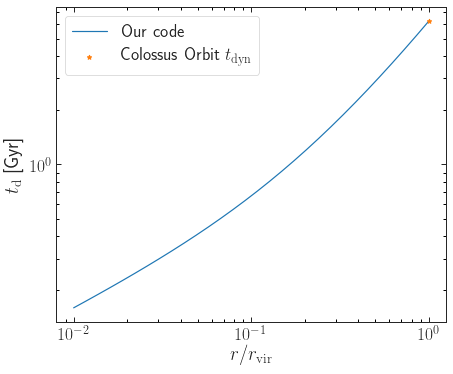

In [9]:
# look at t_d vs. r for a 10^14 Msun/h halo to verify the results

mass = 1e14 #Msun/h
Rvir = mass_so.M_to_R(mass, 0.0, 'vir')
nr = 30
rads = np.logspace(np.log10(0.01*Rvir),np.log10(Rvir), nr)

dt = mass_so.dynamicalTime(0.0, 'vir', definition='orbit')
print(dt / 2)

loglogplot()
plt.plot(rads/Rvir, t_d(rads, mass, 0.0, c=6, R=Rvir), label=r'Our code')
plt.plot([1.], [dt/2], '*', label=r'Colossus Orbit $t_\mathrm{dyn}$')
plt.legend()
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$t_\mathrm{d}$ [Gyr]')
# it agrees, so our calculation seems to be correct
# it disagrees by ~factor of 2~ with Shi and Komatsu, which is explained in their erratum
# hence, our result is indeed correct
# need to check later results to see if they actually use beta*t_dyn / 2 or beta*t_dyn for further stuff

In [10]:
# Komatsu and Seljak Model
# Here, c_nfw is defined using the virialization condition of Lacey & Cole (1993) and Nakamura & Suto (1997)
# should make sure that it is pretty similar to Bryan and Norman

def Gamma(c_nfw):
    return 1.15 + 0.01*(c_nfw - 6.5)

def eta0(c_nfw):
    return 0.00676*(c_nfw - 6.5)**2 + 0.206*(c_nfw - 6.5) + 2.48

def NFWPhi(r, M, z, conc_model='diemer19', mass_def='vir'):
    c = concentration.concentration(M, mass_def, z, model=conc_model)
    R = mass_so.M_to_R(M, z, mass_def)
    if(type(r) != np.ndarray and r == 0):
        return -1. * (G * M / R) * (c / NFWf(c))
    else:
        return -1. * (G * M / R) * (c / NFWf(c)) * (np.log(1. + c*r/R) / (c*r/R))

# this now agrees with Komatsu and Seljak eqn 19 for theta
# the confusion was that rho0 / P0 is 3*eta0^-1 and then units removed by scaling by R/GM
def theta(r, M, z, conc_model='diemer19', mass_def='vir'):
    c = concentration.concentration(M, mass_def, z, model=conc_model)
    R = mass_so.M_to_R(M, z, mass_def)
    # the rho0/P0 is actually 3eta^-1(0) * R/(GM) from Komatsu and Seljak
    rho0_by_P0 = 3*eta0(c)**-1 * R/(G*M)
    return 1. + ((Gamma(c) - 1.) / Gamma(c))*rho0_by_P0*(NFWPhi(0, M, z, conc_model='diemer19', mass_def='vir')-NFWPhi(r, M, z, conc_model='diemer19', mass_def='vir'))

# arbitrary units for now while we figure out what to do with the normalization
# likely won't need this
def rho_gas_unnorm(r, M, z, conc_model='diemer19', mass_def='vir'):
    c = concentration.concentration(M, mass_def, z, model=conc_model)
    return theta(r, M, z, conc_model, mass_def)**(1.0 / (Gamma(c) - 1.0))

# in km/s
def sig2_tot_obsolete(r, M, z, conc_model='diemer19', mass_def='vir'):
    c = concentration.concentration(M, mass_def, z, model=conc_model)
    R = mass_so.M_to_R(M, z, mass_def)
    rho0_by_P0 = 3*eta0(c)**-1 * R/(G*M)
    return (1.0 / rho0_by_P0) * theta(r, M, z, conc_model, mass_def)

# the complete sig2_tot that only makes one of each relevant function call:
def sig2_tot(r, M, z, conc_model='diemer19', mass_def='vir'):
    c = concentration.concentration(M, mass_def, z, model=conc_model) # tabulated probably
    R = mass_so.M_to_R(M, z, mass_def) # tabulated probably
    rho0_by_P0 = 3*eta0(c)**-1 * R/(G*M)
    phi0 = -1. * (c / NFWf(c))
    phir = -1. * (c / NFWf(c)) * (np.log(1. + c*r/R) / (c*r/R))
    theta = 1. + ((Gamma(c) - 1.) / Gamma(c)) * 3. *eta0(c)**-1 * (phi0 - phir)
    return (1.0 / rho0_by_P0) * theta

# concentration increases with time
# radius also increases with time (hence why c increases)

Text(0, 0.5, '$\\frac{\\Gamma}{\\Gamma - 1}$')

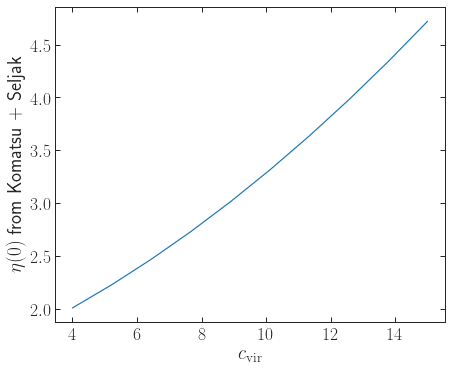

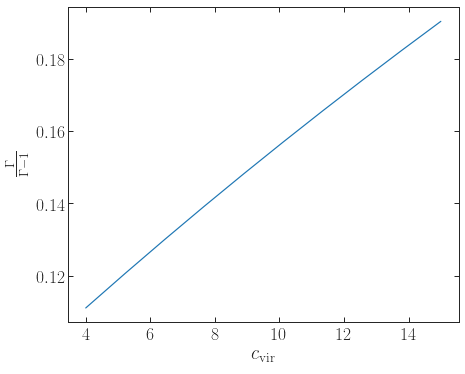

In [11]:
concs = np.linspace(4,15,10)
plot()
plt.plot(concs, eta0(concs))
plt.xlabel(r'$c_\mathrm{vir}$'); plt.ylabel(r'$\eta(0)$ from Komatsu + Seljak')
plot()
plt.plot(concs, ((Gamma(concs) - 1.) / Gamma(concs)))
plt.xlabel(r'$c_\mathrm{vir}$'); plt.ylabel(r'$\frac{\Gamma}{\Gamma - 1}$')

Text(0, 0.5, '$\\sigma_\\mathrm{tot}$ [km/s]')

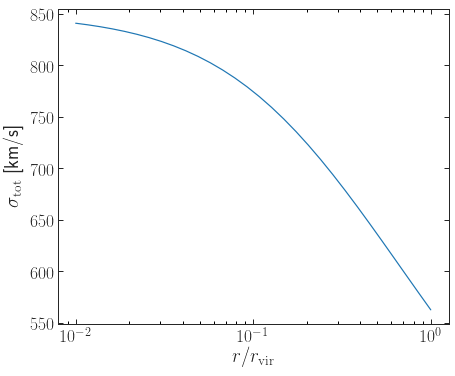

In [12]:
mass = 10**14.5 #Msun/h
Rvir = mass_so.M_to_R(mass, 0.0, 'vir')
nr = 30
rads = np.logspace(np.log10(0.01*Rvir),np.log10(Rvir), nr)

plot(semilogx=True)
plt.plot(rads/Rvir, (sig2_tot(rads, mass, 0.0, mass_def='vir'))**(1./2.))
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$\sigma_\mathrm{tot}$ [km/s]')

# what happens to Komatsu-Seljak model when you have c < 6.5?

# we now have recovered the result of Fig 4 from Komatsu and Seljak

(0.03, 30)

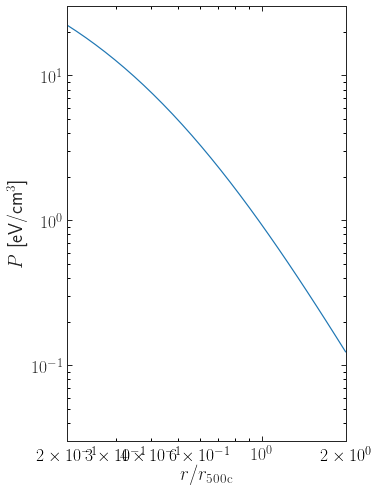

In [13]:
# let's see if we can get the normalization for the gas density, i.e. rho_gas(0)

cbf = cosmo.Ob0 / cosmo.Om0
cosmo_to_evcm3 = 4.224e-10

def rho0(M, z, conc_model='diemer19', mass_def='vir'):
    c = concentration.concentration(M, mass_def, z, model=conc_model)
    R = mass_so.M_to_R(M, z, mass_def)
    nume = cbf * M
    denom = 4. * np.pi * quad(lambda r: theta(r, M, z, conc_model, mass_def)**(1.0 / (Gamma(c) - 1.0)) * r**2, 0, R)[0]
    return nume/denom

def rho_gas(r, M, z, conc_model='diemer19', mass_def='vir'):
    c = concentration.concentration(M, mass_def, z, model=conc_model)
    return rho0(M, z, conc_model, mass_def) * theta(r, M, z, conc_model, mass_def)**(1.0 / (Gamma(c) - 1.0))


# let's plot a Ptot profile

z = 0.1
mass500 = 3e14  / (cosmo.H0 / 70.) * (cosmo.H0 / 100.) #Msun/h
c500 = concentration.concentration(mass500, '500c', z, model='duffy08')
massvir, Rvir, cvir = mass_defs.changeMassDefinition(mass500, c=c500, z=z, mdef_in='500c', mdef_out='vir')

nr = 30
#Rvir = mass_so.M_to_R(massvir, z, 'vir') # kpc / h
R500 = mass_so.M_to_R(mass500, z, '500c') # kpc / h
rads = np.logspace(np.log10(0.2*R500),np.log10(2.*R500), nr)
pressure = sig2_tot(rads, massvir, z, mass_def='vir', conc_model='duffy08') * rho_gas(rads, massvir, z, conc_model='duffy08', mass_def='vir')

loglogplot(figsize=(5,8))
plt.plot(rads/R500, pressure*cosmo_to_evcm3 * (cosmo.H0/100.)**2)
plt.xlabel(r'$r / r_\mathrm{500c}$')
plt.ylabel(r'$P$ [eV/cm$^3$]')
plt.xlim(0.2,2.0)
plt.ylim(0.03, 30)


# This is pretty spot-on now... so we should be good to move onto Y_SZ

(0.2, 20.0)

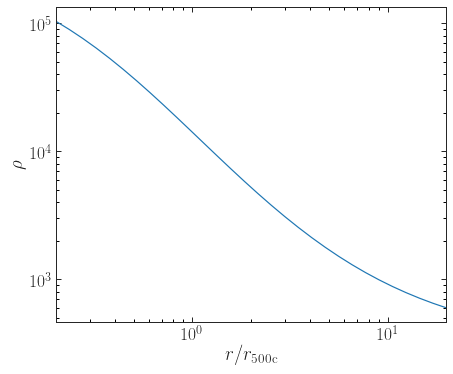

In [14]:
mass = 3e14  / (cosmo.H0 / 70.) * (cosmo.H0 / 100.) #Msun/h
z = 0.1
nr = 30
Rvir = mass_so.M_to_R(mass, z, '500c') # kpc / h
rads = np.logspace(np.log10(0.2*Rvir),np.log10(20.*Rvir), nr)
gas_density = rho_gas(rads, mass, z, conc_model='duffy08', mass_def='500c')

loglogplot()
plt.plot(rads/Rvir, gas_density)
plt.xlabel(r'$r / r_\mathrm{500c}$')
plt.ylabel(r'$\rho$')
plt.xlim(0.2,20.0)
#plt.ylim(0.03, 30)

## Average MAH Codes

In [15]:
zhao_exec_name = 'mandc.x'
vdb_exec_name = 'getPWGH'

# TODO: Update the calls to use names that change with the cosmology
# then we can check for the presence of a file for a given combo of m, z, and cosmo
# and if it is there already, we don't need to regenerate it
# this will speed up the reproduction of plots

# can convert to 200c, 200m if needed
def zhao_mah(Mobs, z_obs, cosmo):
    lgMobs = np.log10(Mobs)
    zpt = '%05d' % (np.round(z_obs, decimals=1)*100)
    mpt = '%05d' % (np.round(lgMobs, decimals=1)*100)
    df_name = 'mchistory_%s.%s.%s' % (cosmo_dict[cosmo.name], zpt, mpt)
    if(isfile(df_name)): # we've already generated this run
        data = np.loadtxt(df_name,skiprows=1)
    else:
        instring = '%s\n%.3f %.3f\n1\n%.3f\n%.3f\n%.3f\n%.4f %1.3f\n1\n%1.1f\n%2.1f' % (cosmo_dict[cosmo.name], cosmo.Om0, cosmo.Ode0, cosmo.H0/100., cosmo.sigma8, cosmo.ns, cosmo.Ob0, cosmo.Tcmb0, z_obs, lgMobs)
        command = "echo '%s' | %s/%s" % (instring, getcwd(), zhao_exec_name)
        process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
        process.wait()
        data = np.loadtxt(df_name,skiprows=1)
    # will update the line below if we want to use 200c/200m
    zeds = data[:,0]; mass = data[:,1]; conc = data[:,2]
    times = data[:,-1] / yr_per_Gyr / (cosmo.H0/100.);
    # wonder how sensitive the results are to the derivative method used
    dMdt = (mass[1:] - mass[:-1]) / (times[1:] - times[:-1])
    # setting the dMdt at present day to zero since we don't need to evolve past z=0
    dMdt = np.insert(dMdt, len(dMdt), 0)
    out = np.column_stack((zeds, mass, conc, dMdt))
    out = np.flip(out, axis=0)
    return(out)

# same units for both, dM/dt in Msun/h / Gyr, mass in Msun/h

def vdb_mah(Mobs, z_obs, cosmo, tp='average'):
    if(tp=='median'):
        med_or_avg = 0
    elif(tp=='average'):
        med_or_avg = 1
    df_out_name = 'PWGH_%s.dat' % tp # name used by Frank's code
    lgMobs = np.log10(Mobs)
    zpt = '%05d' % (np.round(z_obs, decimals=1)*100)
    mpt = '%05d' % (np.round(lgMobs, decimals=1)*100)
    df_name = 'PWGH_%s.%s.%s' % (cosmo_dict[cosmo.name], zpt, mpt) # name we will save file as
    if(isfile(df_name)): # we've already generated this run
        data = np.loadtxt(df_name)
    else:
        instring = '%.3f\n%.3f\n%.3f\n%.3f\n%.4f\n%1.1E\n%1.1f\n%1d' % (cosmo.Om0, cosmo.H0/100., cosmo.sigma8, cosmo.ns, cosmo.Ob0*(cosmo.H0/100.)**2, Mobs, z_obs, med_or_avg)
        command = "echo '%s' | %s/%s; mv %s %s" % (instring, getcwd(), vdb_exec_name, df_out_name, df_name)
        process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
        process.wait()
        data = np.loadtxt(df_name)
    zeds = data[:,1]; mass = 10**data[:,3] * Mobs
    conc = data[:,6]; dMdt = data[:,7] * yr_per_Gyr
    out = np.column_stack((zeds, mass, conc, dMdt))
    out = np.flip(out, axis=0)
    return(out)

# will want to do the same thing here with the Parkinson model, but give it a third dimension which corresponds to
# the number of trees


Text(0, 0.5, '$M$')

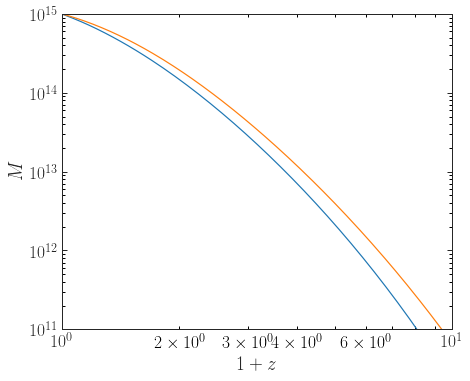

In [16]:
cosmo = cosmology.setCosmology('WMAP5')
zd = zhao_mah(10**15, 0.0, cosmo)
vd = vdb_mah(10**15, 0.0, cosmo)

loglogplot()
plt.plot(1+zd[:,0],zd[:,1], label='Zhao+09')
plt.plot(1+vd[:,0],vd[:,1], label='vdB+14')
plt.xlim(1,10)
plt.ylim(10**11,10**15)
plt.xlabel(r'$1+z$')
plt.ylabel(r'$M$')

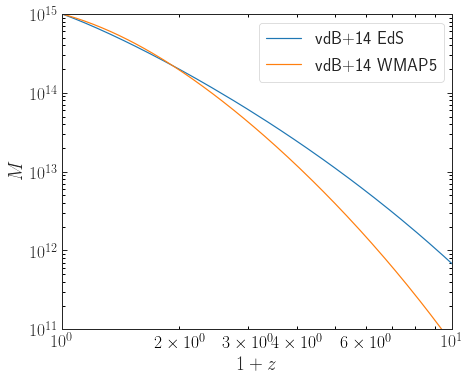

In [17]:
loglogplot()
cosmo = cosmology.setCosmology('near_EdS')
vd = vdb_mah(10**15, 0.0, cosmo)
plt.plot(1+vd[:,0],vd[:,1], label='vdB+14 EdS')
cosmo = cosmology.setCosmology('WMAP5')
vd = vdb_mah(10**15, 0.0, cosmo)
plt.plot(1+vd[:,0],vd[:,1], label='vdB+14 WMAP5')

plt.xlim(1,10)
plt.ylim(10**11,10**15)
plt.xlabel(r'$1+z$')
plt.ylabel(r'$M$')
plt.legend()
# Frank's code does not work for EdS

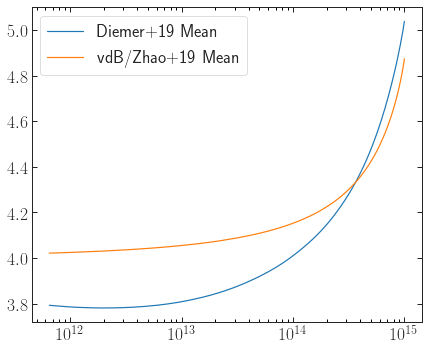

In [18]:
vdb_dat = vdb_mah(10**15, 0.0, cosmo)

masses = vdb_dat[:,1]
zeds = vdb_dat[:,0]
msk = zeds <= 6
vdb_concs = vdb_dat[:,2]
concs = np.zeros(len(vdb_dat))
for i in range(0,len(concs)):
    concs[i] = concentration.concentration(masses[i], 'vir', zeds[i], model = 'diemer19')

plot(semilogx=True)
plt.plot(masses[msk], concs[msk], label='Diemer+19 Mean')
plt.plot(masses[msk], vdb_concs[msk], label='vdB/Zhao+19 Mean')
plt.legend()

## Exploring the Cosmological Dependence of Nonthermal Pressure Fractions using Average MAHs

In [37]:
def sig2_tot(r, M, c, R):
    rho0_by_P0 = 3*eta0(c)**-1 * R/(G*M)
    phi0 = -1. * (c / NFWf(c))
    phir = -1. * (c / NFWf(c)) * (np.log(1. + c*r/R) / (c*r/R))
    theta = 1. + ((Gamma(c) - 1.) / Gamma(c)) * 3. *eta0(c)**-1 * (phi0 - phir)
    return (1.0 / rho0_by_P0) * theta

0.008233118259693672 0.3467672404220167


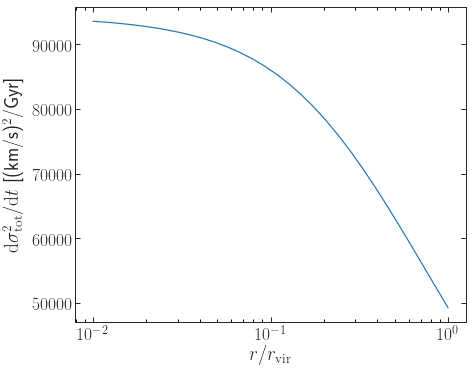

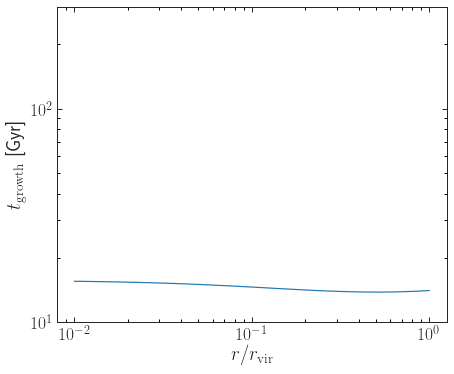

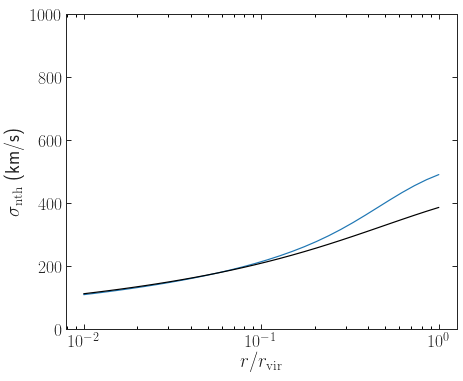

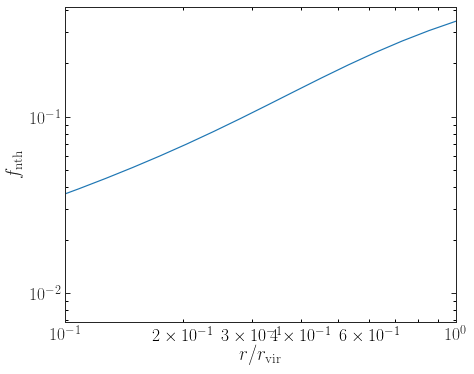

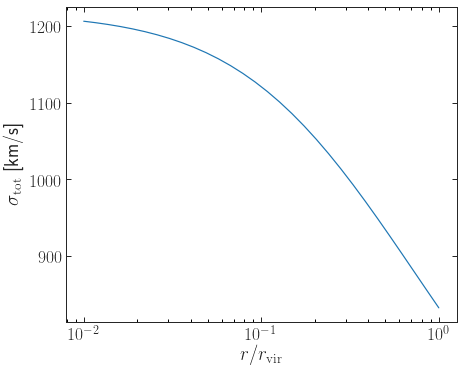

In [18]:
warnings.simplefilter('ignore')
cosmo = cosmology.setCosmology('WMAP5')
# pipeline takes in Mobs, z, cosmology
# computes the dsigma^2/dt for each radius

Mobs = 10**15
zobs = 0.0
mass_def = 'vir'
conc_model='duffy08' # will definitely want to try changing this
nrads = 30

# need to make sure that when we change the cosmology, all things are properly updated

zhao_dat = zhao_mah(Mobs, zobs, cosmo)
first_snap_to_use = np.where(zhao_dat[:,0] <= 6.)[0][0] - 1
zhao_dat = zhao_dat[first_snap_to_use:]

n_steps = zhao_dat.shape[0] - 1

Robs = mass_so.M_to_R(Mobs, zobs, mass_def)

rads = np.logspace(np.log10(0.01*Robs),np.log10(Robs), nrads)

ds2dt = np.zeros((n_steps, nrads))
sig2tots = np.zeros((n_steps, nrads))
sig2nth = np.zeros((n_steps, nrads))

for i in range(0, n_steps):
    z_1 = zhao_dat[i,0] #first redshift
    z_2 = zhao_dat[i+1,0] #second redshift, the one we are actually at
    dt = cosmo.age(z_2) - cosmo.age(z_1) # in Gyr
    mass_1 = zhao_dat[i,1]
    mass_2 = zhao_dat[i+1,1]
    dM = mass_2 - mass_1
    dMdt = zhao_dat[i+1,3] # since the (i+1)th is computed between i+1 and i
    R_1 = mass_so.M_to_R(mass_1, z_1, mass_def)
    R_2 = mass_so.M_to_R(mass_2, z_2, mass_def)
    c_1 = concentration.concentration(mass_1, mass_def, z_1, model = 'duffy08') #zhao_dat[i,2]
    c_2 = concentration.concentration(mass_2, mass_def, z_2, model = 'duffy08') #zhao_dat[i+1,2]
    sig2tots[i,:] = sig2_tot(rads, mass_2, c_2, R_2) # second snapshot
    if(i==0):
        # update this to accept general eta
        ds2dt[i,:] = (sig2tots[i,:] - sig2_tot(rads, mass_1, c_1, R_1)) / dt # see if this works better, full change
        sig2nth[i,:] = eta_def * sig2tots[i,:] # starts at z_i = 6 roughly
    else:
        ds2dt[i,:] = (sig2tots[i,:] - sig2tots[i-1,:]) / dt
        td = t_d(rads, mass_2, z_2, c_2, R_2, beta=beta_def) #t_d at z of interest z_2
        sig2nth[i,:] = sig2nth[i-1] + ((-1. * sig2nth[i-1,:] / td) + eta_def * ds2dt[i,:])*dt
        # here we can see if it is td or 2td that we are using in comparison

# seems that we are able to reproduce the Shi+ results only when we use the Duffy+08 concentration
# which has its own issues, but we'll mitigate this by using merger trees in future and independent concentrations

plot(semilogx=True)
plt.plot(rads/Robs, ds2dt[-1,:])
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$\mathrm{d}\sigma_\mathrm{tot}^2 /\mathrm{d}t$ [(km/s)$^2$/Gyr]')

tgrowth = sig2tots / np.abs(ds2dt)
loglogplot() 
plt.plot(rads/Robs, tgrowth[-1,:])
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$t_\mathrm{growth}$ [Gyr]')
plt.ylim(10**1, 3*10**2)

td = t_d(rads, zhao_dat[-1,1], zhao_dat[-1,0], zhao_dat[-1,2], mass_so.M_to_R(zhao_dat[-1,1], zhao_dat[-1,0], 'vir'), beta=beta_def)
fnth_lim = eta_def * td / (td + tgrowth[-1,:])

plot(semilogx=True)
plt.plot(rads/Robs, np.sqrt(sig2nth[-1,:]))
plt.plot(rads/Robs, np.sqrt(fnth_lim) * np.sqrt(sig2tots[-1,:]), color='k')
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$\sigma_\mathrm{nth}$ (km/s)')
plt.ylim(0,1000)

loglogplot()
fnth = sig2nth[-1,:] / sig2tots[-1,:]
print(np.min(fnth),np.max(fnth)) # currently not changing much... still a bug
plt.plot(rads/Robs, fnth)
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$f_\mathrm{nth}$')
plt.xlim(10**-1, 1.)

plot(semilogx=True)
plt.plot(rads/Robs, np.sqrt(sig2tots[-1,:])) # this is correct still
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$\sigma_\mathrm{tot}$ [km/s]')

# once we can *roughly* reproduce the results of Shi+14, we're ready to start trying different masses, redshifts, cosmos
warnings.simplefilter('default')

In [19]:
def sig2_tot(r, M, c, R):
    rho0_by_P0 = 3*eta0(c)**-1 * R/(G*M)
    phi0 = -1. * (c / NFWf(c))
    phir = lambda rad: -1. * (c / NFWf(c)) * (np.log(1. + c*rad/R) / (c*rad/R))
    theta = lambda rad: 1. + ((Gamma(c) - 1.) / Gamma(c)) * 3. *eta0(c)**-1 * (phi0 - phir(rad))
    return (1.0 / rho0_by_P0) * theta(r)

In [22]:
# let's make a function out of the stuff below and then loop over several masses and redshifts
# then we can add in cosmologies

#takes in Mobs, zobs, cosmo
#returns f_nth, sig2nth, sig2tot at z=zobs
def gen_fnth(Mobs, zobs, cosmo, mah_retriever=vdb_mah, mass_def='vir', conc_model='duffy08', beta=beta_def, eta=eta_def, nrads=30, zi=6., r_mult=1., return_full=False):
    data = mah_retriever(Mobs, zobs, cosmo)
    first_snap_to_use = np.where(data[:,0] <= zi)[0][0] - 1
    data = data[first_snap_to_use:]

    n_steps = data.shape[0] - 1

    Robs = mass_so.M_to_R(Mobs, zobs, mass_def)

    rads = np.logspace(np.log10(0.01*Robs),np.log10(r_mult*Robs), nrads)

    ds2dt = np.zeros((n_steps, nrads))
    sig2tots = np.zeros((n_steps, nrads))
    sig2nth = np.zeros((n_steps, nrads))

    # this process can probably be made more pythonic so that the looping is faster
    # will be very important for once we work with a merger tree instead
    # computing the concentrations is definitely the bottleneck
    # if using ludlow/zhao, do it array-wise so we get them all for one computation instead of repeated
    for i in range(0, n_steps):
        z_1 = data[i,0] #first redshift
        z_2 = data[i+1,0] #second redshift, the one we are actually at
        dt = cosmo.age(z_2) - cosmo.age(z_1) # in Gyr
        mass_1 = data[i,1]
        mass_2 = data[i+1,1]
        dM = mass_2 - mass_1
        dMdt = data[i+1,3] # since the (i+1)th is computed between i+1 and i
        R_1 = mass_so.M_to_R(mass_1, z_1, mass_def)
        R_2 = mass_so.M_to_R(mass_2, z_2, mass_def)
        if(conc_model == 'vdb'):
            c_1 = data[i,2]
            c_2 = data[i+1,2]
        else:
            c_1 = concentration.concentration(mass_1, mass_def, z_1, model=conc_model)
            c_2 = concentration.concentration(mass_2, mass_def, z_2, model=conc_model)
        sig2tots[i,:] = sig2_tot(rads, mass_2, c_2, R_2) # second snapshot
        if(i==0):
            # update this to accept general eta
            ds2dt[i,:] = (sig2tots[i,:] - sig2_tot(rads, mass_1, c_1, R_1)) / dt # see if this works better, full change
            sig2nth[i,:] = eta * sig2tots[i,:] # starts at z_i = 6 roughly
        else:
            ds2dt[i,:] = (sig2tots[i,:] - sig2tots[i-1,:]) / dt
            td = t_d(rads, mass_2, z_2, c_2, R_2, beta=beta_def) #t_d at z of interest z_2
            sig2nth[i,:] = sig2nth[i-1] + ((-1. * sig2nth[i-1,:] / td) + eta * ds2dt[i,:])*dt
    if(return_full==False):
        fnth = sig2nth[-1,:] / sig2tots[-1,:]
        return fnth, rads, sig2nth[-1,:], sig2tots[-1,:], data[-1,0], data[-1,2]
    else:
        fnth = sig2nth / sig2tots
        return fnth, rads, sig2nth[-1,:], sig2tots[-1,:], data[:,0], data[:,2] # return redshifts+concs too
        


masses = [10**13, 10**14, 10**15]
zeds = [0.0, 0.3, 1.0]
cosmologies = ['near_EdS','WMAP5','planck18']
fancy_cosms = ['EdS', 'WMAP5', "Planck '18"]

def plot_3cosmos(masses, zeds, cosmologies, fancy_cosms, mah_retriever=vdb_mah, mass_def='vir', conc_model='vdb', beta=beta_def, eta=eta_def):
    fig, ax = plt.subplots(nrows=len(masses),ncols=len(zeds),figsize=(13,13), sharex=True, sharey=True, gridspec_kw={'wspace':0.05,'hspace':0.075})
    for i in range(0,3):
        for j in range(0,3):
            ax[i,j].yaxis.set_ticks_position('both')
            ax[i,j].xaxis.set_ticks_position('both')
            ax[i,j].tick_params(axis='both', which='minor', colors='black', width=1.0, length=2.0)
            ax[i,j].loglog()
            ax[i,j].set_ylim(2.5e-4,0.8)
            ax[i,j].set_xlim(0.8*1e-2,1*1.2)
            #ax[i,j].xaxis.set_minor_locator(MultipleLocator(0.2))
            #ax[i,j].yaxis.set_minor_locator(MultipleLocator(0.05))


    # can generate colors based on the cosmology

    for i,m in enumerate(masses):
        for j,z in enumerate(zeds):
            for k,cosm in enumerate(cosmologies):
                #print(i,j,k)
                cosmo = cosmology.setCosmology(cosm)
                fnth, rads, _, _, _, _ = gen_fnth(m, z, cosmo, mah_retriever, mass_def, conc_model, beta, eta)
                ax[i,j].plot(rads/rads[-1], fnth, label=fancy_cosms[k])


    for i in range(0,len(masses)):
        ax[i,0].set_ylabel(r'$f_\mathrm{nth}$')
        ax[i,0].text(1.3e-2,3e-1,r'$\log_{10}(M_\mathrm{vir}/[h^{-1}M_\odot])=%.1f$' % np.log10(masses[i]), fontsize=16)
    for i in range(0,len(zeds)):
        ax[len(masses)-1,i].set_xlabel(r'$r/r_\mathrm{vir}$')
        ax[0,i].text(1.3e-2,1.7e-1,r'$z=%.1f$' % zeds[i], fontsize=16)

    ax[1,len(zeds)-1].legend(frameon=False,fontsize=16)
    return fig, ax

# clearly, the different cosmologies look different, but this is sensitive to concentration definition
# we can see how different things are using different concentration definitions and using vdB vs. Zhao
# also want to see how things look *outside Rvir* perhaps out to r200m

# probably not going to be able to tell the difference between WMAP5 and Planck 18 with this method...

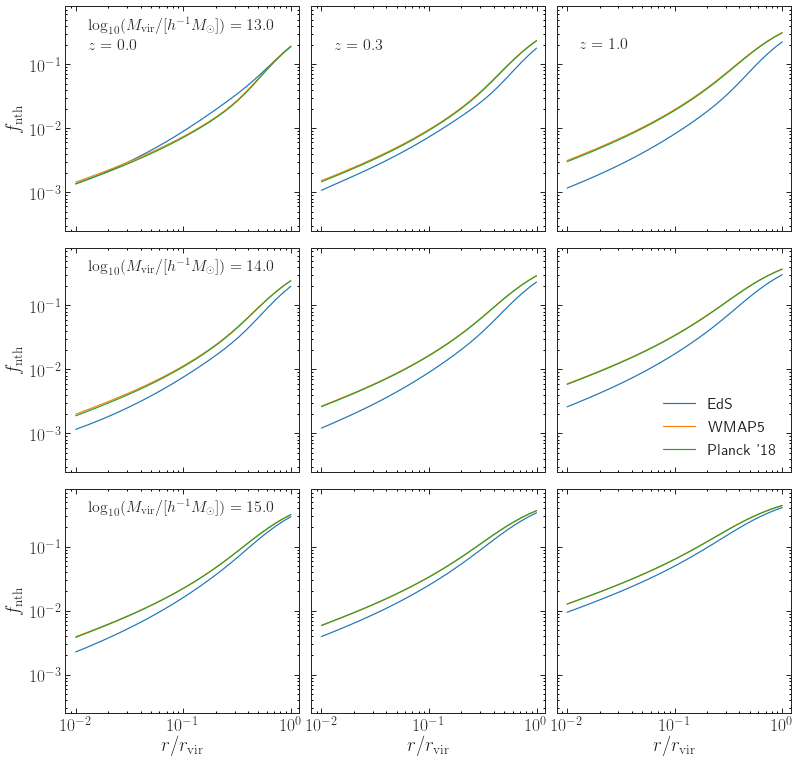

In [23]:
plot_3cosmos(masses, zeds, cosmologies, fancy_cosms, conc_model='vdb', mah_retriever=vdb_mah);

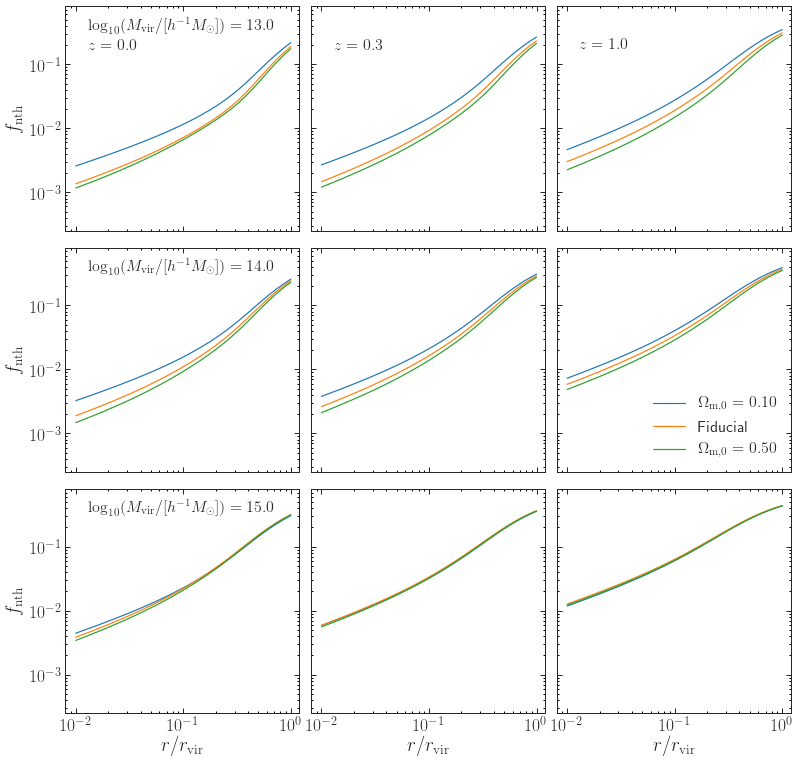

In [22]:
masses = [10**13, 10**14, 10**15]
zeds = [0.0, 0.3, 1.0]
cosmologies = ['pl18_lowOm0','planck18','pl18_hiOm0']
fancy_cosms = [r'$\Omega_\mathrm{m,0}=%.2f$' % cosmology.cosmologies[cosmologies[0]]['Om0'], r'Fiducial', r'$\Omega_\mathrm{m,0}=%.2f$' % cosmology.cosmologies[cosmologies[-1]]['Om0']]
plot_3cosmos(masses, zeds, cosmologies, fancy_cosms, conc_model='vdb', mah_retriever=vdb_mah);

# changing Omega_matter has a reasonable effect

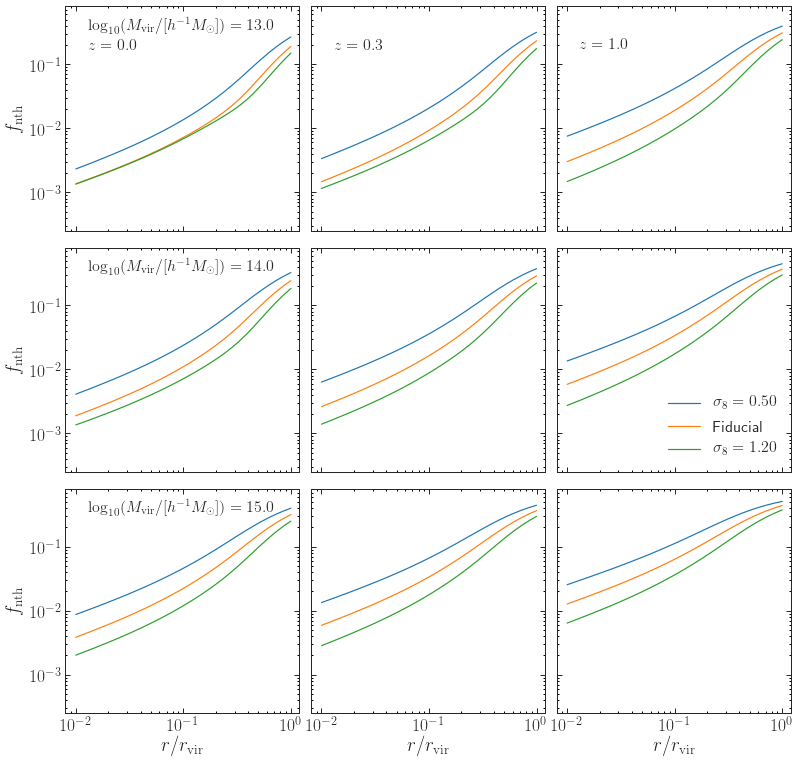

In [23]:
cosmologies = ['pl18_lows8','planck18','pl18_his8']
fancy_cosms = [r'$\sigma_8=%.2f$' % cosmology.cosmologies[cosmologies[0]]['sigma8'], r'Fiducial', r'$\sigma_8=%.2f$' % cosmology.cosmologies[cosmologies[-1]]['sigma8']]
plot_3cosmos(masses, zeds, cosmologies, fancy_cosms, conc_model='vdb', mah_retriever=vdb_mah);

# changing sigma_8 has a very large effect

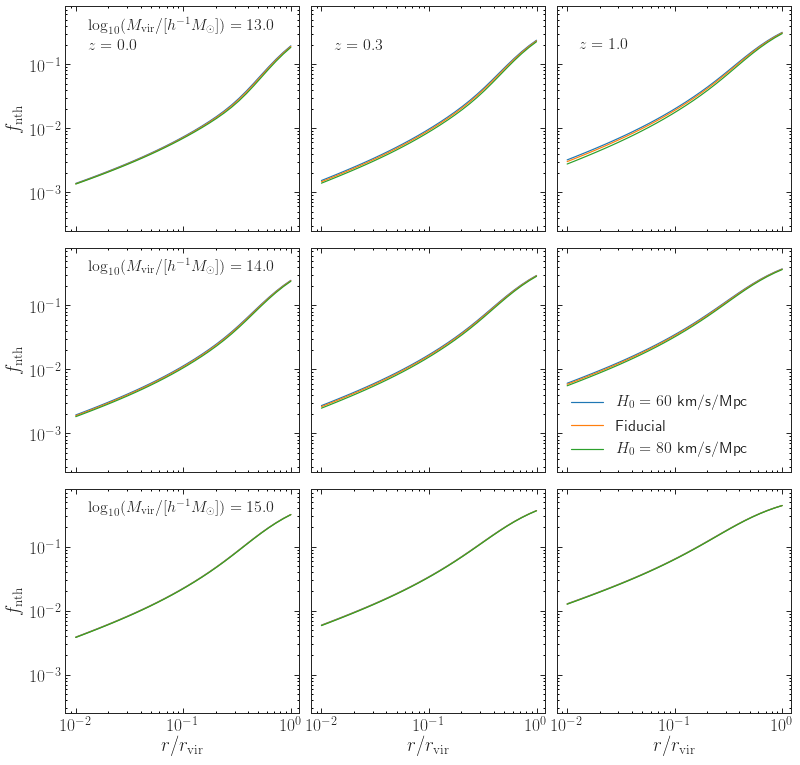

In [24]:
cosmologies = ['pl18_lowH0','planck18','pl18_hiH0']
fancy_cosms = [r'$H_0=%.0f$ km/s/Mpc' % cosmology.cosmologies[cosmologies[0]]['H0'], r'Fiducial', r'$H_0=%.0f$ km/s/Mpc' % cosmology.cosmologies[cosmologies[-1]]['H0']]
plot_3cosmos(masses, zeds, cosmologies, fancy_cosms, conc_model='vdb', mah_retriever=vdb_mah);

# H_0 has basically no effect

In [25]:
for cosm in ['pl18_s8_1_1','pl18_s8_1_2', 'planck18', 'pl18_s8_p6_1', 'pl18_s8_p6_2']:
    cosmology.setCosmology(cosm)
    print(cosmology.getCurrent())

Cosmology "pl18_s8_1_1" 
    flat = True, Om0 = 0.3000, Ode0 = 0.6999, Ob0 = 0.0490, H0 = 67.66, sigma8 = 1.0000, ns = 0.9665
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False
Cosmology "pl18_s8_1_2" 
    flat = True, Om0 = 0.4690, Ode0 = 0.5309, Ob0 = 0.0490, H0 = 67.66, sigma8 = 0.8000, ns = 0.9665
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False
Cosmology "planck18" 
    flat = True, Om0 = 0.3111, Ode0 = 0.6888, Ob0 = 0.0490, H0 = 67.66, sigma8 = 0.8102, ns = 0.9665
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False
Cosmology "pl18_s8_p6_1" 
    flat = True, Om0 = 0.3000, Ode0 = 0.6999, Ob0 = 0.0490, H0 = 67.66, sigma8 = 0.6000, ns = 0.9665
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False
Cosmology "pl18_s8_p6_2" 
    flat = True, Om0 = 0.4320, Ode0 = 0.5679, Ob0 = 0.0490, H0 = 67.66, sigma8 = 0.5000, ns = 0.9665
    de_mode

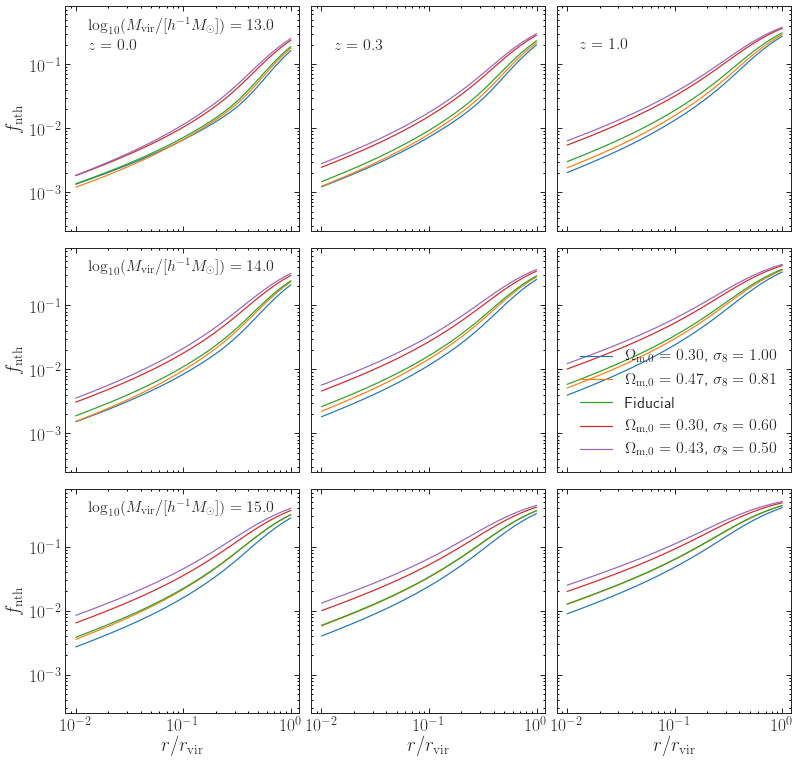

In [26]:
# testing varying s8, first with the high S_8
# then with the low S_8
# and then if they look the same as long as S_8 fixed, then we can compare different values of S_8


masses = [10**13, 10**14, 10**15]
zeds = [0.0, 0.3, 1.0]
cosmologies = ['pl18_s8_1_1','pl18_s8_1_2', 'planck18', 'pl18_s8_p6_1', 'pl18_s8_p6_2']
fancy_cosms = [r'$\Omega_\mathrm{m,0}=%.2f$, $\sigma_8=%.2f$' % (cosmology.cosmologies[cosmologies[0]]['Om0'], cosmology.cosmologies[cosmologies[0]]['sigma8']), 
               r'$\Omega_\mathrm{m,0}=%.2f$, $\sigma_8=%.2f$' % (cosmology.cosmologies[cosmologies[1]]['Om0'], cosmology.cosmologies[cosmologies[2]]['sigma8']),
               r'Fiducial',
               r'$\Omega_\mathrm{m,0}=%.2f$, $\sigma_8=%.2f$' % (cosmology.cosmologies[cosmologies[3]]['Om0'], cosmology.cosmologies[cosmologies[3]]['sigma8']), 
               r'$\Omega_\mathrm{m,0}=%.2f$, $\sigma_8=%.2f$' % (cosmology.cosmologies[cosmologies[4]]['Om0'], cosmology.cosmologies[cosmologies[4]]['sigma8'])]
fig, ax = plot_3cosmos(masses, zeds, cosmologies, fancy_cosms, conc_model='vdb', mah_retriever=vdb_mah);

## Reproducing Nelson et al. (2014) Results for $R_\mathrm{200m}$ and $R_\mathrm{200c}$

Cosmology "WMAP5" 
    flat = True, Om0 = 0.2732, Ode0 = 0.7267, Ob0 = 0.0456, H0 = 70.50, sigma8 = 0.8120, ns = 0.9600
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False
(225, 30) (226,) (226,)
[1.4819e+00 1.4605e+00 1.4393e+00 1.4183e+00 1.3974e+00 1.3767e+00
 1.3563e+00 1.3360e+00 1.3158e+00 1.2959e+00 1.2761e+00 1.2565e+00
 1.2370e+00 1.2177e+00 1.1986e+00 1.1797e+00 1.1609e+00 1.1423e+00
 1.1238e+00 1.1055e+00 1.0873e+00 1.0693e+00 1.0515e+00 1.0338e+00
 1.0163e+00 9.9890e-01 9.8170e-01 9.6460e-01 9.4770e-01 9.3090e-01
 9.1420e-01 8.9770e-01 8.8140e-01 8.6520e-01 8.4910e-01 8.3320e-01
 8.1740e-01 8.0170e-01 7.8620e-01 7.7080e-01 7.5550e-01 7.4040e-01
 7.2540e-01 7.1050e-01 6.9580e-01 6.8120e-01 6.6670e-01 6.5230e-01
 6.3810e-01 6.2390e-01 6.0990e-01 5.9610e-01 5.8230e-01 5.6870e-01
 5.5520e-01 5.4170e-01 5.2850e-01 5.1530e-01 5.0220e-01 4.8930e-01
 4.7640e-01 4.6370e-01 4.5110e-01 4.3860e-01 4.2620e-01 4.1390e-01
 4.0170e-01 3.8960e-01 3.7770

(<Figure size 936x396 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f246c6b2a90>,
       dtype=object))

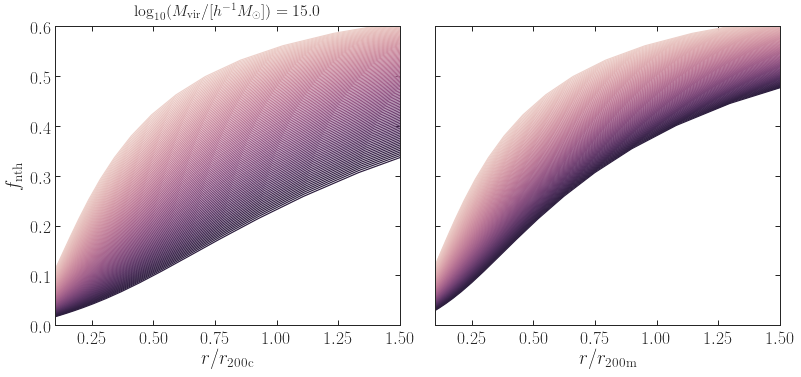

In [24]:
# function takes in Mvir, since this is what Frank's code uses; must convert to corresponding radii
def plot_z_evol_rm_rc(mass, zf, cosmo, mah_retriever=vdb_mah, mass_def='vir', conc_model='vdb', beta=beta_def, eta=eta_def, r_mult=1.):
    print(cosmo) # just to be clear
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(13,5.5), sharex=True, sharey=True, gridspec_kw={'wspace':0.1,'hspace':0.075})
    for i in range(0,2):
        ax[i].yaxis.set_ticks_position('both')
        ax[i].xaxis.set_ticks_position('both')
        ax[i].tick_params(axis='both', which='minor', colors='black', width=1.0, length=2.0)
        #ax[i].loglog()
        ax[i].set_ylim(0.,0.6) #set_ylim(2.5e-4,0.8)
        ax[i].set_xlim(0.1,1.5) #set_xlim(0.8*1e-2,1*1.2)
        
    fnth, rads, _, _, zeds, concs = gen_fnth(mass, zf, cosmo, mah_retriever, mass_def, conc_model, beta, eta, r_mult=r_mult, return_full=True)
    print(fnth.shape, zeds.shape, concs.shape)
    print(zeds[120:])
    
    startz_ind = 120
    
    cols = sns.cubehelix_palette(len(zeds[startz_ind:]))

    for j in range(startz_ind, len(zeds)):
        # the radius is r_vir
        # but what we need is r_200c and r_200m
        # we need to convert given the concentration
        M200c, r200c, _ = mass_defs.changeMassDefinition(mass, concs[j], zeds[j], 'vir', '200c')
        M200m, r200m, _ = mass_defs.changeMassDefinition(mass, concs[j], zeds[j], 'vir', '200m')
        #r200c = mass_so.M_to_R(mass, z, '200c')
        #r200m = mass_so.M_to_R(mass, z, '200m')
        # the first value in zeds and concs needs to be tossed
        ax[0].plot(rads/r200c, fnth[j-1,:], color=cols[j-startz_ind])
        ax[1].plot(rads/r200m, fnth[j-1,:], label='%.2f' % zeds[j], color=cols[j-startz_ind])


    ax[0].set_ylabel(r'$f_\mathrm{nth}$')
    ax[0].set_title(r'$\log_{10}(M_\mathrm{vir}/[h^{-1}M_\odot])=%.1f$' % np.log10(mass), fontsize=16)
    ax[0].set_xlabel(r'$r/r_\mathrm{200c}$')
    ax[1].set_xlabel(r'$r/r_\mathrm{200m}$')
    #ax[1].legend(frameon=False,fontsize=16)
    return fig, ax

cosmo = cosmology.setCosmology('WMAP5')
zeds = [0, 0.5, 1., 1.5]

plot_z_evol_rm_rc(10**15, 0.0, cosmo, mah_retriever=vdb_mah, mass_def='vir', r_mult=2.)



Cosmology "WMAP5" 
    flat = True, Om0 = 0.2732, Ode0 = 0.7267, Ob0 = 0.0456, H0 = 70.50, sigma8 = 0.8120, ns = 0.9600
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


(<Figure size 936x396 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f246abd7be0>,
       dtype=object))

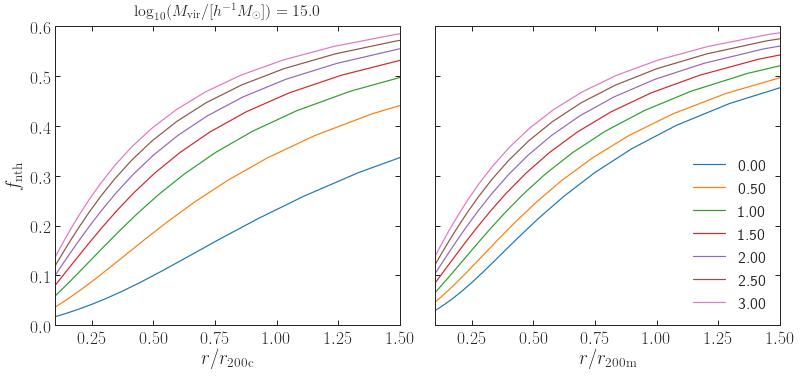

In [25]:
# pick fixed mass and generate one-panel plot that loops over different redshifts of observation
# this is fixed mass at observation
# Note that this is different from using fixed peak height at different z_obs and also different from using one
# average MAH at z_obs and then varying the redshift along the trajectory

def plot_z_evol_rm_rc(mass, zeds, cosmo, mah_retriever=vdb_mah, mass_def='vir', conc_model='vdb', beta=beta_def, eta=eta_def, r_mult=1.):
    print(cosmo) # just to be clear
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(13,5.5), sharex=True, sharey=True, gridspec_kw={'wspace':0.1,'hspace':0.075})
    for i in range(0,2):
        ax[i].yaxis.set_ticks_position('both')
        ax[i].xaxis.set_ticks_position('both')
        ax[i].tick_params(axis='both', which='minor', colors='black', width=1.0, length=2.0)
        #ax[i].loglog()
        ax[i].set_ylim(0.,0.6) #set_ylim(2.5e-4,0.8)
        ax[i].set_xlim(0.1,1.5) #set_xlim(0.8*1e-2,1*1.2)

    for j,z in enumerate(zeds):
        # the radius is r_vir
        # but what we need is r_200c and r_200m
        fnth, rads, _, _, zz, conc = gen_fnth(mass, z, cosmo, mah_retriever, mass_def, conc_model, beta, eta, r_mult=r_mult)
        M200c, r200c, _ = mass_defs.changeMassDefinition(mass, conc, z, 'vir', '200c')
        M200m, r200m, _ = mass_defs.changeMassDefinition(mass, conc, z, 'vir', '200m')
        ax[0].plot(rads/r200c, fnth)
        ax[1].plot(rads/r200m, fnth, label='%.2f' % z)


    ax[0].set_ylabel(r'$f_\mathrm{nth}$')
    ax[0].set_title(r'$\log_{10}(M_\mathrm{vir}/[h^{-1}M_\odot])=%.1f$' % np.log10(mass), fontsize=16)
    ax[0].set_xlabel(r'$r/r_\mathrm{200c}$')
    ax[1].set_xlabel(r'$r/r_\mathrm{200m}$')
    ax[1].legend(frameon=False,fontsize=16)
    return fig, ax

cosmo = cosmology.setCosmology('WMAP5')
zeds = [0, 0.5, 1., 1.5, 2.0, 2.5, 3.0]

plot_z_evol_rm_rc(10**15, zeds, cosmo, mah_retriever=vdb_mah, mass_def='vir', r_mult=2.)

Cosmology "WMAP5" 
    flat = True, Om0 = 0.2732, Ode0 = 0.7267, Ob0 = 0.0456, H0 = 70.50, sigma8 = 0.8120, ns = 0.9600
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


(<Figure size 936x396 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f246cd58320>,
       dtype=object))

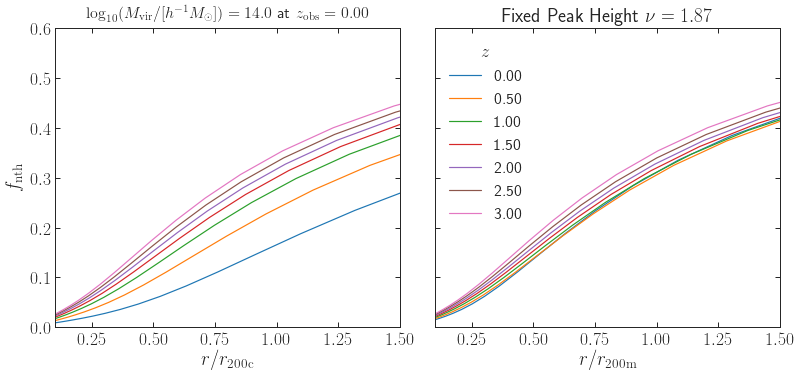

In [31]:
def plot_z_evol_rm_rc_fixed_nu(mass, zeds, cosmo, mah_retriever=vdb_mah, mass_def='vir', conc_model='vdb', beta=beta_def, eta=eta_def, r_mult=1.):
    print(cosmo) # just to be clear
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(13,5.5), sharex=True, sharey=True, gridspec_kw={'wspace':0.1,'hspace':0.075})
    for i in range(0,2):
        ax[i].yaxis.set_ticks_position('both')
        ax[i].xaxis.set_ticks_position('both')
        ax[i].tick_params(axis='both', which='minor', colors='black', width=1.0, length=2.0)
        #ax[i].loglog()
        ax[i].set_ylim(0.,0.6) #set_ylim(2.5e-4,0.8)
        ax[i].set_xlim(0.1,1.5) #set_xlim(0.8*1e-2,1*1.2)
        
    zobs = 0
    nu = peaks.peakHeight(mass, zobs) # fixed M_vir

    for j,z in enumerate(zeds):
            # the radius is r_vir
            # but what we need is r_200c and r_200m
            m = peaks.massFromPeakHeight(nu, z)
            fnth, rads, _, _, zz, conc = gen_fnth(m, z, cosmo, mah_retriever, mass_def, conc_model, beta, eta, r_mult=r_mult)
            M200c, r200c, _ = mass_defs.changeMassDefinition(m, conc, z, 'vir', '200c')
            M200m, r200m, _ = mass_defs.changeMassDefinition(m, conc, z, 'vir', '200m')
            #r200c = mass_so.M_to_R(m, z, '200c')
            #r200m = mass_so.M_to_R(m, z, '200m')
            ax[0].plot(rads/r200c, fnth)
            ax[1].plot(rads/r200m, fnth, label='%.2f' % z)


    ax[0].set_ylabel(r'$f_\mathrm{nth}$')
    ax[0].set_title(r'$\log_{10}(M_\mathrm{vir}/[h^{-1}M_\odot])=%.1f$ at $z_\mathrm{obs}=%.2f$' % (np.log10(mass), zobs), fontsize=16)
    ax[0].set_xlabel(r'$r/r_\mathrm{200c}$')
    ax[1].set_xlabel(r'$r/r_\mathrm{200m}$')
    ax[1].set_title(r'Fixed Peak Height $\nu = %.2f$' % nu)
    ax[1].legend(frameon=False,fontsize=16, title=r'$z$', title_fontsize=18)
    return fig, ax

cosmo = cosmology.setCosmology('WMAP5')
zeds = [0, 0.5, 1., 1.5, 2.0, 2.5, 3.0]


plot_z_evol_rm_rc_fixed_nu(10**14, zeds, cosmo, mah_retriever=vdb_mah, mass_def='vir', r_mult=2.)

# Need to think a bit more about fixed peak height vs. looking at the evolution of the f_nth for one MAH trajectory
# When we use fixed peak heigh, z_obs and m change, so the MAH code gives different MAh that inform what the average
# MAH would be for a halo observed at z_obs and mass m

# The point here is that at fixed peak height, haloes have roughly the same f_nth regardless of redshift

# The f_nth values go down as we decrease the mass..
# When comparing to M_200m, it's actually roughly the case that 10**15.5 Msun/h Mvir is the same as R200m

Cosmology "WMAP5" 
    flat = True, Om0 = 0.2732, Ode0 = 0.7267, Ob0 = 0.0456, H0 = 70.50, sigma8 = 0.8120, ns = 0.9600
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


(<Figure size 936x936 with 8 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f246c8715c0>,
       dtype=object))

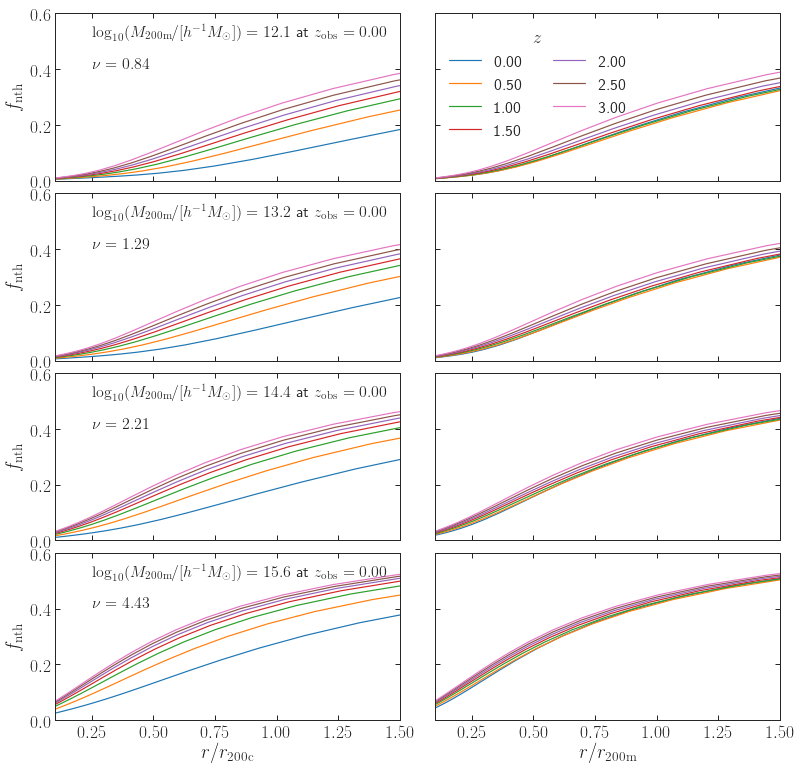

In [32]:
def plot_fixed_nu_multiMZ(masses, zeds, cosmo, mah_retriever=vdb_mah, mass_def='vir', conc_model='vdb', beta=beta_def, eta=eta_def, r_mult=1.):
    print(cosmo) # just to be clear
    fig, ax = plt.subplots(nrows=len(masses),ncols=2,figsize=(13,13), sharex=True, sharey=True, gridspec_kw={'wspace':0.1,'hspace':0.075})
    for i in range(0,2):
        for j in range(0,len(masses)):
            ax[j,i].yaxis.set_ticks_position('both')
            ax[j,i].xaxis.set_ticks_position('both')
            ax[j,i].tick_params(axis='both', which='minor', colors='black', width=1.0, length=2.0)
            #ax[i].loglog()
            ax[j,i].set_ylim(0.,0.6) #set_ylim(2.5e-4,0.8)
            ax[j,i].set_xlim(0.1,1.5) #set_xlim(0.8*1e-2,1*1.2)
        
    zobs = 0
    
    for i,mass in enumerate(masses):
        nu = peaks.peakHeight(mass, zobs) # fixed M_vir
        for j,z in enumerate(zeds):
            # the radius is r_vir
            # but what we need is r_200c and r_200m
            m = peaks.massFromPeakHeight(nu, z) # since we put in M_vir, this is still M_vir
            fnth, rads, _, _, zz, conc = gen_fnth(m, z, cosmo, mah_retriever, mass_def, conc_model, beta, eta, r_mult=r_mult)
            M200c, r200c, _ = mass_defs.changeMassDefinition(m, conc, z, 'vir', '200c') # convert our M_vir values to M200c, M200m
            M200m, r200m, _ = mass_defs.changeMassDefinition(m, conc, z, 'vir', '200m')
            if(j==0):
                ax[i,0].text(0.25, 0.5, r'$\log_{10}(M_\mathrm{200m}/[h^{-1}M_\odot])=%.1f$ at $z_\mathrm{obs}=%.2f$' % (np.log10(M200m), z), fontsize=16)
                ax[i,0].text(0.25, 0.4, r'$\nu = %.2f$' % nu, fontsize=16)
            ax[i,0].plot(rads/r200c, fnth)
            ax[i,1].plot(rads/r200m, fnth, label='%.2f' % z)


    for i in range(0,len(masses)):
        ax[i,0].set_ylabel(r'$f_\mathrm{nth}$')
    ax[len(masses)-1,0].set_xlabel(r'$r/r_\mathrm{200c}$')
    ax[len(masses)-1,1].set_xlabel(r'$r/r_\mathrm{200m}$')
    #ax[1].set_title(r'Fixed Peak Height $\nu = %.2f$' % nu)
    ax[0,1].legend(frameon=False,fontsize=16, title=r'$z$', title_fontsize=18, ncol=2)
    return fig, ax

cosmo = cosmology.setCosmology('WMAP5')
zeds = [0, 0.5, 1., 1.5, 2.0, 2.5, 3.0]
masses = np.logspace(12,15.5,4)


plot_fixed_nu_multiMZ(masses, zeds, cosmo, mah_retriever=vdb_mah, mass_def='vir', r_mult=2.)

Cosmology "WMAP5" 
    flat = True, Om0 = 0.2732, Ode0 = 0.7267, Ob0 = 0.0456, H0 = 70.50, sigma8 = 0.8120, ns = 0.9600
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


(<Figure size 936x396 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f246cc53ef0>,
       dtype=object))

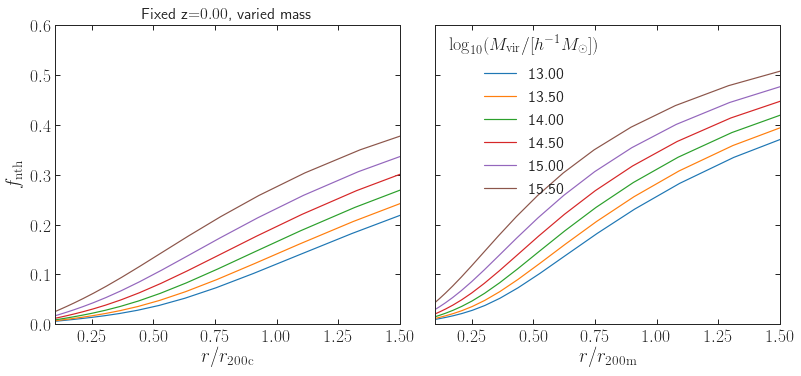

In [33]:
# Do we not see mass dependence when we use r_200m at fixed redshift?

def plot_m_evol_rm_rc(masses, zobs, cosmo, mah_retriever=vdb_mah, mass_def='vir', conc_model='vdb', beta=beta_def, eta=eta_def, r_mult=1.):
    print(cosmo) # just to be clear
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(13,5.5), sharex=True, sharey=True, gridspec_kw={'wspace':0.1,'hspace':0.075})
    for i in range(0,2):
        ax[i].yaxis.set_ticks_position('both')
        ax[i].xaxis.set_ticks_position('both')
        ax[i].tick_params(axis='both', which='minor', colors='black', width=1.0, length=2.0)
        #ax[i].loglog()
        ax[i].set_ylim(0.,0.6) #set_ylim(2.5e-4,0.8)
        ax[i].set_xlim(0.1,1.5) #set_xlim(0.8*1e-2,1*1.2)
        
    for j,m in enumerate(masses):
        # the radius is r_vir
        # but what we need is r_200c and r_200m
        fnth, rads, _, _, zz, conc = gen_fnth(m, zobs, cosmo, mah_retriever, mass_def, conc_model, beta, eta, r_mult=r_mult)
        M200c, r200c, _ = mass_defs.changeMassDefinition(m, conc, zobs, 'vir', '200c')
        M200m, r200m, _ = mass_defs.changeMassDefinition(m, conc, zobs, 'vir', '200m')
        ax[0].plot(rads/r200c, fnth)
        ax[1].plot(rads/r200m, fnth, label='%.2f' % np.log10(m))


    ax[0].set_ylabel(r'$f_\mathrm{nth}$')
    ax[0].set_title(r'Fixed z=$%.2f$, varied mass' % zobs, fontsize=16)
    ax[0].set_xlabel(r'$r/r_\mathrm{200c}$')
    ax[1].set_xlabel(r'$r/r_\mathrm{200m}$')
    ax[1].legend(frameon=False,fontsize=16, title=r'$\log_{10}(M_\mathrm{vir}/[h^{-1}M_\odot])$', title_fontsize=18)
    return fig, ax

cosmo = cosmology.setCosmology('WMAP5')
masses = [10**13, 10**13.5, 10**14, 10**14.5, 10**15, 10**15.5]


plot_m_evol_rm_rc(masses, 0.0, cosmo, mah_retriever=vdb_mah, mass_def='vir', r_mult=2.)

## Using Monte Carlo MAHs to Study Intercluster Variance in Nonthermal Pressure Fractions

In [34]:
def multimah(Mobs, z_obs, cosmo, Nmah, tp='average'):
    # loads in an array of MAH from Frank's MAH code, specify Nmah = number of MAH to get
    mass_int = int(np.log10(Mobs)*10)
    z_int = int(z_obs*100)
    mah_dir = multimah_root / ('%s/m%03d/z%03d' % (cosmo.name, mass_int, z_int))
    dat1 = np.loadtxt(mah_dir / 'MAH0001.dat')
    redshifts = dat1[:,1]
    lbtime = dat1[:,2]
    nz = len(dat1)
    dat = np.zeros((Nmah, nz))
    std = np.zeros((nz,2))
    for i in range(0,Nmah):
        dat[i,:] = np.loadtxt(mah_dir / ('MAH%04d.dat' %(i+1)), usecols=3)
    dat = 10**dat
    if(tp == 'full'):
        # return the full array instead of giving standard deviations
        return dat*Mobs, redshifts, lbtime
    elif(tp == 'average'):
        mah = np.average(dat, axis=0)
        std[:,0] = np.std(dat, axis=0)
        std[:,1] = std[:,0]
    elif(tp == 'logaverage'):
        mah = np.average(np.log10(dat), axis=0)
        std[:,0] = np.std(np.log10(dat), axis=0)
        std[:,1] = std[:,0]
        mah = 10**mah
        std = 10**std
    elif(tp == 'median'):
        mah = np.median(dat, axis=0)
        std[:,0] = mah - np.percentile(dat, 16, axis=0)
        std[:,1] = np.percentile(dat, 84, axis=0) - mah
    mah = mah * Mobs
    std = std * Mobs
    return mah, std, redshifts, lbtime

Text(0.5, 1.0, 'Individual MAHs')

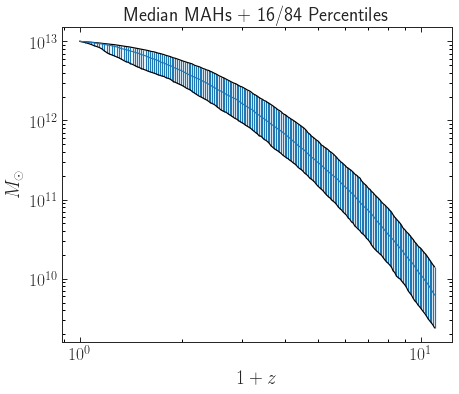

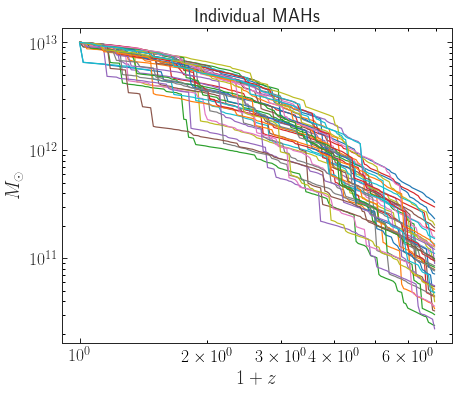

In [35]:
# let's look at some test cases: z=0, 10**13 Msun, individual and median/average MAHs

cosmo = cosmology.setCosmology('planck18')

mah, std, redshifts, lbtime = multimah(10**13, 0.0,cosmo,1000, tp='median')

loglogplot()
msk = redshifts < 10
plt.errorbar(1+redshifts[msk], mah[msk], std[msk].T)
plt.plot(1+redshifts[msk], mah[msk] - std[msk,0], color='k')
plt.plot(1+redshifts[msk], mah[msk] + std[msk,1], color='k')
#mah, std, redshifts, lbtime = multimah(10**13, 0.0,cosmo,1000, tp='average')
#plt.errorbar(1+redshifts[msk], mah[msk], std[msk].T)
plt.xlabel(r'$1+z$')
plt.ylabel(r'$M_\odot$')
plt.title(r'Median MAHs + 16/84 Percentiles')

mah, redshifts, lbtime = multimah(10**13, 0.0,cosmo,1000, tp='full')

loglogplot()
msk = redshifts < 6.
for i in range(0, 40):
    plt.plot(1+redshifts[msk], mah[i,msk])
plt.xlabel(r'$1+z$')
plt.ylabel(r'$M_\odot$')
plt.title(r'Individual MAHs')

Text(0, 0.5, '$M$')

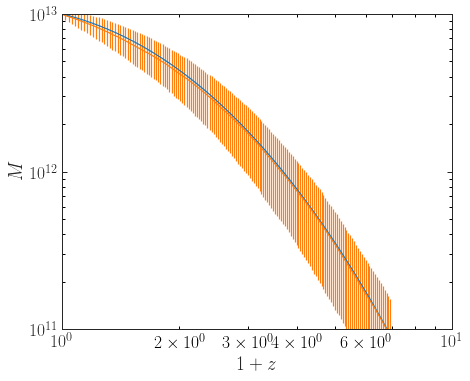

In [36]:
# what about comparison directly to vdB+14 PWGH?
vd = vdb_mah(10**13, 0.0, cosmo)

loglogplot()
plt.plot(1+vd[:,0],vd[:,1], label='vdB+14')
mah, std, redshifts, lbtime = multimah(10**13, 0.0,cosmo,1000, tp='average')
plt.errorbar(1+redshifts[msk], mah[msk], std[msk].T)
plt.xlim(1,10)
plt.ylim(10**11,10**13)
plt.xlabel(r'$1+z$')
plt.ylabel(r'$M$')

# looks pretty close... let's see how different the concentration models are...

Text(0, 0.5, '$\\mathrm{d}M/\\mathrm{d}t$')

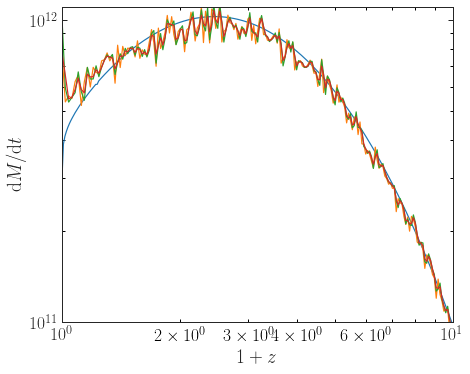

In [37]:
# compare dM/dt values between
loglogplot()
plt.plot(1+vd[:,0],vd[:,3], label='vdB+14 PWGH')

mah, std, redshifts, lbtime = multimah(10**13, 0.0,cosmo,1000, tp='average')
dMdt = (mah[:-1] - mah[1:])/(lbtime[1:] - lbtime[:-1])
plt.plot(1+redshifts[:-1], dMdt)

# let's try an interpolator and see if that helps... could interpolate the dM/dt and the concentration
# other than this, we should see if it is because of the concentrations
# also seems like the MAH is much higher in the average than in the PWGH case at low z, which could be responsible for
# why the average (black curve) f_nth is higher than the PWGH prediction

# I think ultimately we should trust the MC MAHs more than the PWGH though, since this is the true average of a
# population instead of a model meant to estimate the average

# Need to figure out what to do with the zeros and how to properly deal with negative pressure in the integration
# Also need to see if the timesteps make much of a difference

# then can make the 3x3 plot and send to Daisuke, start talking about doing y_sz

mah_interp = interp(-1.*lbtime[::-1], mah[::-1], k=3)
dmass_dt = mah_interp.derivative()

plt.plot(1+redshifts, dmass_dt(-1.*lbtime)) # this isn't much better... would be smoother if we used higher-order derivative

grad_dmdt = np.gradient(mah[::-1], -1.*lbtime[::-1], edge_order=1)
plt.plot(1+redshifts, grad_dmdt[::-1])

plt.xlim(1,10)
plt.ylim(10**11,1.1*10**12)
plt.xlabel(r'$1+z$')
plt.ylabel(r'$\mathrm{d}M/\mathrm{d}t$')

# FINDING: The dM/dt of the average MC MAH is consistently higher for various different masses
# This explains why there is a systematic increase in f_nth for the MC MAH vs. the vdB+14 PWGH code
# There is nothing wrong with them disagreeing... the PWGH code is just based off of a model, but we should
# trust the outputs from the MC MAH over the PWGH.

0.409953237


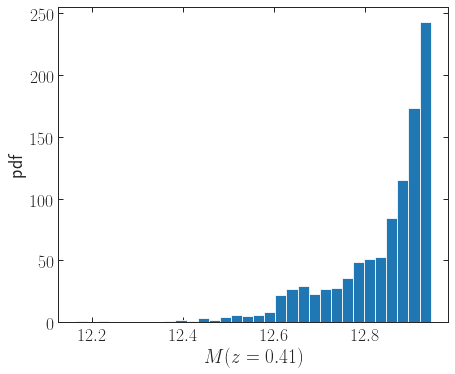

In [38]:
# demonstrating that the MAH masses at a given redshift are not normally distributed NOR lognormally distribured
mah, redshifts, lbtime = multimah(10**13, 0.0,cosmo,1000, tp='full')
plot()
numz = 20
print(redshifts[numz])
plt.hist(np.log10(mah[:,numz]), bins='sqrt')
plt.xlabel(r'$M(z=%.2f)$' % redshifts[numz]);
plt.ylabel('pdf');

In [19]:
# CONCENTRATION MODELS

def zhao_vdb_conc(t, t04):
    return 4.0 * (1.0 + (t / (3.40*t04))**6.5)**(1.0/8.0)

# IMPLEMENT LUDLOW 16 MODEL HERE

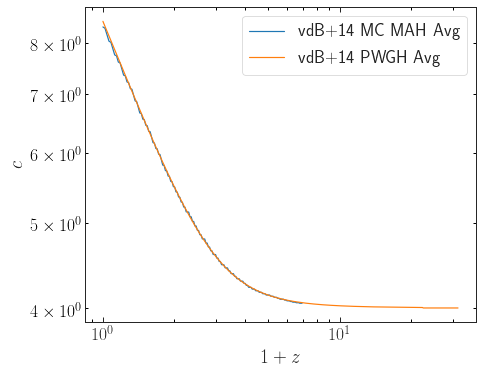

In [40]:
mah, std, redshifts, lbtime = multimah(10**13, 0.0,cosmo,1000, tp='average')

z0 = 0.0
t0 = cosmo.age(z0)

nz_msk = len(redshifts[msk])
concs = np.zeros(nz_msk)

for i in range(0,nz_msk):
    t = t0 - lbtime[i]
    m04 = 0.04 * mah[i]
    t04_ind = np.where(mah > m04)[0][-1]
    t04 = t0 - lbtime[t04_ind]
    concs[i] = zhao_vdb_conc(t, t04)

loglogplot()
plt.plot(1+redshifts[msk], concs, label='vdB+14 MC MAH Avg')
plt.plot(1+vd[:,0],vd[:,2], label='vdB+14 PWGH Avg')
plt.xlabel(r'$1+z$')
plt.ylabel(r'$c$')
plt.legend()

# these concentrations are in agreement with Frank's Coming of Age paper

In [319]:
# modifying the gen_fnth function to do it using the individual MAHs from Frank's code
# as well as to compute fnth using the percentiles/median of the MAHs from Frank's code

def gen_fnth_ind(Mobs, zobs, cosmo, mass_def='vir', conc_model=zhao_vdb_conc, Nmah=1000, beta=beta_def, eta=eta_def, nrads=30, zi=6.):
    #takes in Mobs, zobs, cosmo
    #returns f_nth, sig2nth, sig2tot at z=zobs

    mah, redshifts, lbtime = multimah(Mobs, zobs, cosmo, Nmah, tp='full')
    zi_snap = np.where(redshifts <= zi)[0][-1] + 1 #first snap over z=6
    #data = data[first_snap_to_use:]
    t0 = cosmo.age(0) # this way we can easily get proper times using the lookback times from Frank's files

    n_steps = zi_snap

    Robs = mass_so.M_to_R(Mobs, zobs, mass_def)

    rads = np.logspace(np.log10(0.01*Robs),np.log10(Robs), nrads)

    ds2dt = np.zeros((Nmah, n_steps, nrads))
    sig2tots = np.zeros((Nmah, n_steps, nrads))
    sig2nth = np.zeros((Nmah, n_steps, nrads))
    fnth    = np.zeros((Nmah,nrads))

    for mc in range(0,Nmah):
        if(mc % 100 == 0):
            print(mc)
        for i in range(zi_snap,0,-1):
            z_1 = redshifts[i] #first redshift
            z_2 = redshifts[i-1] #second redshift, the one we are actually at
            dt = lbtime[i] - lbtime[i-1] # in Gyr
            mass_1 = mah[mc, i] #dat = np.zeros((Nmah, nz))
            mass_2 = mah[mc, i-1]
            dM = mass_2 - mass_1
            dMdt = dM/dt # since the (i+1)th is computed between i+1 and i
            R_1 = mass_so.M_to_R(mass_1, z_1, mass_def)
            R_2 = mass_so.M_to_R(mass_2, z_2, mass_def)
            
            time_1 = t0 - lbtime[i]
            time_2 = t0 - lbtime[i-1]
            m04_1  = 0.04 * mass_1
            m04_2  = 0.04 * mass_2
            t04_ind_1 = np.where(mah[mc,:] > m04_1)[0][-1]
            t04_ind_2 = np.where(mah[mc,:] > m04_2)[0][-1]
            t04_1 = t0 - lbtime[t04_ind_1]
            t04_2 = t0 - lbtime[t04_ind_2]

            c_1 = conc_model(time_1, t04_1) 
            c_2 = conc_model(time_2, t04_2)
            sig2tots[mc,i-1,:] = sig2_tot(rads, mass_2, c_2, R_2) # second snapshot
            if(i==zi_snap):
                ds2dt[mc,i-1,:] = (sig2tots[mc,i-1,:] - sig2_tot(rads, mass_1, c_1, R_1)) / dt # see if this works better, full change
                sig2nth[mc,i-1,:] = eta * sig2tots[mc,i-1,:] # starts at z_i = 6 roughly
            else:
                ds2dt[mc,i-1,:] = (sig2tots[mc,i-1,:] - sig2tots[mc,i,:]) / dt
                td = t_d(rads, mass_2, z_2, c_2, R_2, beta=beta_def) #t_d at z of interest z_2
                sig2nth[mc,i-1,:] = sig2nth[mc,i,:] + ((-1. * sig2nth[mc,i,:] / td) + eta * ds2dt[mc,i-1,:])*dt
                sig2nth[mc,i-1, sig2nth[mc,i-1,:] < 0] = 0 #can't have negative sigma^2_nth
        fnth[mc,:] = sig2nth[mc,0,:] / sig2tots[mc,0,:]
    #fnth[fnth < 0] = 0
    return fnth, rads #, sig2nth[-1,:], sig2tots[-1,:] #PENDING 

def gen_fnth_avg_mean(Mobs, zobs, cosmo, mass_def='vir', conc_model=zhao_vdb_conc, tp='median', Nmah=1000, beta=beta_def, eta=eta_def, nrads=30, zi=6.):
    mah, std, redshifts, lbtime = multimah(Mobs, zobs, cosmo, Nmah, tp)
    zi_snap = np.where(redshifts <= zi)[0][-1] + 1 #first snap over z=6
    #data = data[first_snap_to_use:]
    t0 = cosmo.age(zobs)

    n_steps = zi_snap

    Robs = mass_so.M_to_R(Mobs, zobs, mass_def)

    rads = np.logspace(np.log10(0.01*Robs),np.log10(Robs), nrads)

    ds2dt = np.zeros((3, n_steps, nrads))
    sig2tots = np.zeros((3, n_steps, nrads))
    sig2nth = np.zeros((3, n_steps, nrads))
    fnth    = np.zeros((3,nrads))
    
    mah = np.array([mah - std[:,0], mah, mah + std[:,1]])

    for mc in range(0,3):
        for i in range(zi_snap,0,-1):
            z_1 = redshifts[i] #first redshift
            z_2 = redshifts[i-1] #second redshift, the one we are actually at
            dt = lbtime[i] - lbtime[i-1] # in Gyr
            mass_1 = mah[mc, i] #dat = np.zeros((Nmah, nz))
            mass_2 = mah[mc, i-1]
            dM = mass_2 - mass_1
            dMdt = dM/dt # since the (i+1)th is computed between i+1 and i
            R_1 = mass_so.M_to_R(mass_1, z_1, mass_def)
            R_2 = mass_so.M_to_R(mass_2, z_2, mass_def)
            
            time_1 = t0 - lbtime[i]
            time_2 = t0 - lbtime[i-1]
            m04_1  = 0.04 * mass_1
            m04_2  = 0.04 * mass_2
            t04_ind_1 = np.where(mah[mc,:] > m04_1)[0][-1]
            t04_ind_2 = np.where(mah[mc,:] > m04_2)[0][-1]
            t04_1 = t0 - lbtime[t04_ind_1]
            t04_2 = t0 - lbtime[t04_ind_2]

            c_1 = conc_model(time_1, t04_1) 
            c_2 = conc_model(time_2, t04_2)
            sig2tots[mc,i-1,:] = sig2_tot(rads, mass_2, c_2, R_2) # second snapshot
            if(i==zi_snap):
                # update this to accept general eta
                ds2dt[mc,i-1,:] = (sig2tots[mc,i-1,:] - sig2_tot(rads, mass_1, c_1, R_1)) / dt # see if this works better, full change
                sig2nth[mc,i-1,:] = eta * sig2tots[mc,i-1,:] # starts at z_i = 6 roughly
            else:
                ds2dt[mc,i-1,:] = (sig2tots[mc,i-1,:] - sig2tots[mc,i,:]) / dt
                td = t_d(rads, mass_2, z_2, c_2, R_2, beta=beta_def) #t_d at z of interest z_2
                sig2nth[mc,i-1,:] = sig2nth[mc,i,:] + ((-1. * sig2nth[mc,i,:] / td) + eta * ds2dt[mc,i-1,:])*dt
                sig2nth[mc,i-1, sig2nth[mc,i-1,:] < 0] = 0 #can't have negative sigma^2_nth 
        fnth[mc,:] = sig2nth[mc,0,:] / sig2tots[mc,0,:]
    return fnth, rads #, sig2nth[-1,:], sig2tots[-1,:] #PENDING

def gen_fnth_boot(Mobs, zobs, cosmo, mass_def='vir', conc_model=zhao_vdb_conc, Nmah=1000, Nboot=1000, Nclust=1000, beta=beta_def, eta=eta_def, nrads=30, zi=6.):
    #takes in Mobs, zobs, cosmo
    #returns f_nth, sig2nth, sig2tot at z=zobs
    
    # Nmah is the number of mass accretion histories that we have from Frank's MC MAH code
    # Nboot is the number of bootstrap resamples we do to get the mean and standard error in mean
    # Nclust is the number of clusters we are simulating having in our sample

    mah, redshifts, lbtime = multimah(Mobs, zobs, cosmo, Nmah, tp='full')
    zi_snap = np.where(redshifts <= zi)[0][-1] + 1 #first snap over z=6
    #data = data[first_snap_to_use:]
    t0 = cosmo.age(0) # this way we can easily get proper times using the lookback times from Frank's files

    n_steps = zi_snap

    Robs = mass_so.M_to_R(Mobs, zobs, mass_def)

    rads = np.logspace(np.log10(0.01*Robs),np.log10(Robs), nrads)

    ds2dt = np.zeros((Nmah, n_steps, nrads))
    sig2tots = np.zeros((Nmah, n_steps, nrads))
    sig2nth = np.zeros((Nmah, n_steps, nrads))
    fnth    = np.zeros((Nmah, nrads))

    for mc in range(0,Nmah):
        if(mc % 100 == 0):
            print(mc)
        for i in range(zi_snap,0,-1):
            z_1 = redshifts[i] #first redshift
            z_2 = redshifts[i-1] #second redshift, the one we are actually at
            dt = lbtime[i] - lbtime[i-1] # in Gyr
            mass_1 = mah[mc, i] #dat = np.zeros((Nmah, nz))
            mass_2 = mah[mc, i-1]
            dM = mass_2 - mass_1
            dMdt = dM/dt # since the (i+1)th is computed between i+1 and i
            R_1 = mass_so.M_to_R(mass_1, z_1, mass_def)
            R_2 = mass_so.M_to_R(mass_2, z_2, mass_def)
            
            time_1 = t0 - lbtime[i]
            time_2 = t0 - lbtime[i-1]
            m04_1  = 0.04 * mass_1
            m04_2  = 0.04 * mass_2
            t04_ind_1 = np.where(mah[mc,:] > m04_1)[0][-1]
            t04_ind_2 = np.where(mah[mc,:] > m04_2)[0][-1]
            t04_1 = t0 - lbtime[t04_ind_1]
            t04_2 = t0 - lbtime[t04_ind_2]

            c_1 = conc_model(time_1, t04_1) 
            c_2 = conc_model(time_2, t04_2)
            sig2tots[mc,i-1,:] = sig2_tot(rads, mass_2, c_2, R_2) # second snapshot
            if(i==zi_snap):
                ds2dt[mc,i-1,:] = (sig2tots[mc,i-1,:] - sig2_tot(rads, mass_1, c_1, R_1)) / dt # see if this works better, full change
                sig2nth[mc,i-1,:] = eta * sig2tots[mc,i-1,:] # starts at z_i = 6 roughly
            else:
                ds2dt[mc,i-1,:] = (sig2tots[mc,i-1,:] - sig2tots[mc,i,:]) / dt
                td = t_d(rads, mass_2, z_2, c_2, R_2, beta=beta_def) #t_d at z of interest z_2
                sig2nth[mc,i-1,:] = sig2nth[mc,i,:] + ((-1. * sig2nth[mc,i,:] / td) + eta * ds2dt[mc,i-1,:])*dt
                sig2nth[mc,i-1, sig2nth[mc,i-1,:] < 0] = 0 #can't have negative sigma^2_nth
        fnth[mc,:] = sig2nth[mc,0,:] / sig2tots[mc,0,:]
    #fnth[fnth < 0] = 0
    
    fnth_boot = np.zeros((Nboot, nrads))
    for i in range(0, Nboot):
        boot_inds = np.random.randint(0, Nmah, Nclust) # need to do this Nboot times
        fnth_boot[i,:] = np.average(fnth[boot_inds,:], axis=0)
    
    return fnth_boot, rads #, sig2nth[-1,:], sig2tots[-1,:] #PENDING 


In [42]:
mass = 10**13
zed = 0.0
cosmo = cosmology.setCosmology('planck18')

In [43]:
fnth_inds, rads = gen_fnth_ind(mass, zed, cosmo)

0
100
200
300
400
500
600
700
800
900


In [44]:
fnth_quant, rads = gen_fnth_avg_mean(mass, zed, cosmo, tp='median')
fnth_avg, rads = gen_fnth_avg_mean(mass, zed, cosmo, tp='average')

In [45]:
Nboot = 1000
fnth_boot, rads = gen_fnth_boot(mass, zed, cosmo, Nmah=1000, Nboot=Nboot, Nclust=1000)

0
100
200
300
400
500
600
700
800
900


In [46]:
fnth_boot_logerrs = np.zeros((len(rads), 2))
fnth_boot_avgs = np.mean(fnth_boot, axis=0)
fnth_boot_logavgs = np.log10(fnth_boot_avgs)
for i in range(0, len(rads)):
    stdev = np.std(fnth_boot[:,i])
    fnth_boot_logerrs[i,0] = fnth_boot_logavgs[i] - np.log10(fnth_boot_avgs[i] - stdev)
    fnth_boot_logerrs[i,1] = np.log10(fnth_boot_avgs[i] + stdev) - fnth_boot_logavgs[i]

29
169
338


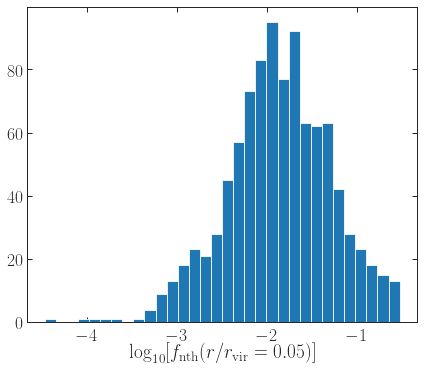

In [47]:
# demonstration that the f_nth seem to be lognormally distributed at each radius

plot()
ind = 20
# so the distributions of f_nth are fairly LOGnormal aside from the zeros...
# is plotting the average of the logs and the standard deviation of the logs the right move?
plt.hist(np.log10(fnth_inds[:,ind][fnth_inds[:,ind] != 0]), bins='sqrt')
#plt.hist(fnth_inds[:,ind], bins='sqrt')

plt.xlabel(r'$\log_{10}[f_\mathrm{nth}(r/r_\mathrm{vir} = %.2f)]$' % (rads[10]/rads[-1]))
print(len(np.where(fnth_inds[:,20] == 0)[0]))
print(len(np.where(fnth_inds[:,10] == 0)[0])) # this is a large fraction
print(len(np.where(fnth_inds[:,0] == 0)[0])) # huge fraction, likely the problem. the solution may be to take smaller timesteps?

Text(0.5, 1.0, '$10^{13}$ $M_\\odot/h$ at $z=0$')

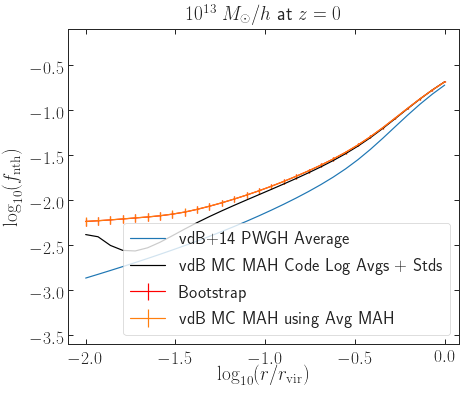

In [49]:
fig, ax = plot()
ax.set_ylim(np.log10(2.5e-4),np.log10(0.8))
ax.set_xlim(np.log10(0.8*1e-2),np.log10(1*1.2))

mass = 10**13
zed = 0.0
cosmo = cosmology.setCosmology('planck18')
fnth, rads, _, _, _, _ = gen_fnth(mass, zed, cosmo, mah_retriever=vdb_mah, mass_def='vir', conc_model='vdb', beta=beta_def, eta=eta_def)
ax.plot(np.log10(rads/rads[-1]), np.log10(fnth), label=r'vdB+14 PWGH Average')
mds = np.median(fnth_inds, axis=0)
quant16 = mds - np.percentile(fnth_inds, 16, axis=0)
quant84 = np.percentile(fnth_inds, 84, axis=0) - mds

fnth_avgs = np.zeros(len(rads))
fnth_logstds = np.zeros((len(rads),2))

for i in range(0,len(rads)):
    #fnth_avgs[i] = np.mean(np.log10(fnth_inds[:,i][fnth_inds[:,i] != 0]))
    #fnth_stds[i] = np.std(np.log10(fnth_inds[:,i][fnth_inds[:,i] != 0]))
    fnth_avgs[i] = np.mean(fnth_inds[:,i]) # this mean agrees with the bootstrap mean
    stdev = np.std(fnth_inds[:,i]) / np.sqrt(1000.)
    fnth_logstds[i,0] = np.log10(fnth_avgs[i]) - np.log10(fnth_avgs[i] - stdev)
    fnth_logstds[i,1] = np.log10(fnth_avgs[i] + stdev) - np.log10(fnth_avgs[i])
    fnth_avgs[i] = np.log10(fnth_avgs[i])
    #fnth_stds[i] = np.log10(np.std(fnth_inds[:,i])) # this is the incorrect way to do this
        
# we're taking the average of the logs and the std dev of the logs, since they are log normally distributed
# now, we can divide by sqrt(N)

ax.errorbar(np.log10(rads/rads[-1]), fnth_boot_logavgs, fnth_boot_logerrs.T, label=r'Bootstrap', color='r')
    
#ax.errorbar(rads/rads[-1], np.median(fnth_inds, axis=0), np.array([quant16,quant84]))
#ax.plot(rads/rads[-1], fnth_quant[0,:], color='k')
#ax.plot(np.log10(rads/rads[-1]), np.log10(fnth_quant[1,:]), color='y')
#ax.plot(rads/rads[-1], fnth_quant[2,:], color='r')
#ax.errorbar(rads/rads[-1], fnth_quant[1,:], np.array([fnth_quant[1,:] - fnth_quant[0,:], fnth_quant[2,:] - fnth_quant[1,:]]))
ax.errorbar(np.log10(rads/rads[-1]), fnth_avgs, fnth_logstds.T, label=r'vdB MC MAH using Avg MAH')
ax.plot(np.log10(rads/rads[-1]), np.log10(fnth_avg[1,:]), color='k', label=r'vdB MC MAH Code Log Avgs + Stds')
ax.set_xlabel(r'$\log_{10}(r/r_\mathrm{vir})$')
ax.set_ylabel(r'$\log_{10}(f_\mathrm{nth})$')
ax.legend()
ax.set_title(r'$10^{13}$ $M_\odot/h$ at $z=0$')

# we want to overplot on this the MAH using the new approach

# this should look exactly like Frank's I think... maybe not?

# this seems to agree pretty well with Frank's PWGH code here down to small logr, but then it blows up
# this is probably because we aren't accounting for a large fraction of f_nth values that are zero

# Since f_nth for the MC MAH are larger, this makes sense because the recent dM/dt is larger for this case than
# for Frank's PWGH model. Hence, since dsigma_nth^2/dt proportional to dM/dt, the recent growth results in larger
# f_nth

# Interestingly the MC MAH average and the average of the f_nth using the individual MAHs agree really well
# for large radii, where the results are less sensitive to fluctuations at the last few timesteps
# They both disagree with Frank's PWGH code, but this is because the PWGH model seems to have a systematically lower
# dM/dt in all cases for late times

# Hence, all of the results seem to make sense, and the last question for this part of the analysis is whether or
# not we should take the average/std of the logs or not. The f_nth seem to be lognormally distributed for each radius

# mean of log vs log of mean... need to figure out which one makes more sense

# Our bootstrap resampling average agrees well with the vdB MC MAH using Avg MAH, which makes sense because
# this is the average of all of the individuals, and so our sample average should look the same as the average of the bootstraps
# The errorbars are now standard error in the mean assuming 1000 clusters in the sample
# This looks very similar to the vdB MC MAH using Avg MAH where the error bars are the standard devs of the 1000 cluster
# sample divided by sqrt(1000). Awesome!!

#ax.set_xlim(-2,-1)
#ax.set_ylim(-2.2, -2.18)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
5

(<Figure size 936x936 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3f5ba07630>,
       dtype=object))

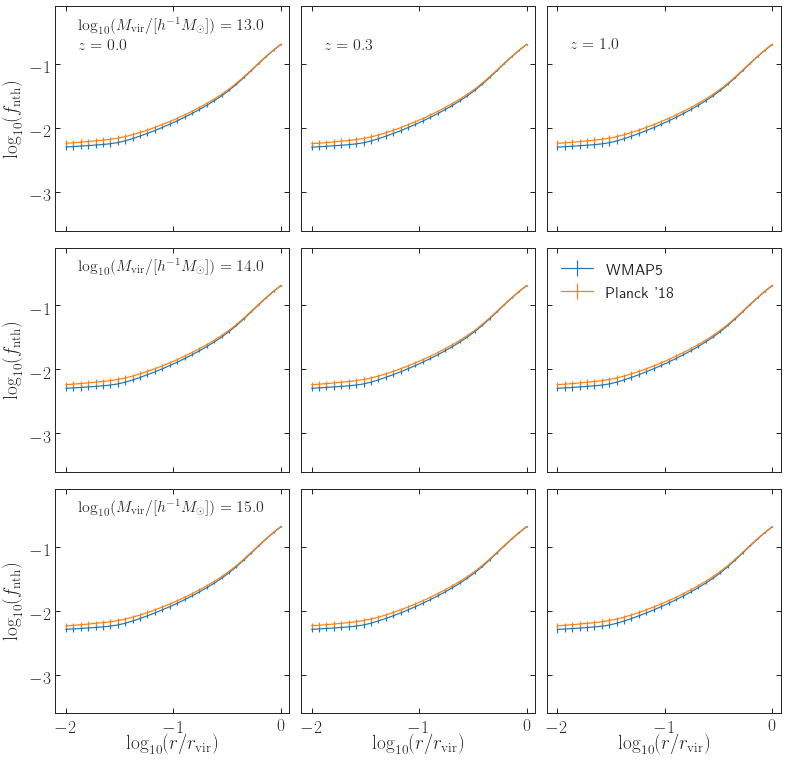

In [58]:
def plot_3by3_mcmah(masses, zeds, cosmologies, fancy_cosms, Nmah=1000, Nboot=1000, Nclust=1000, conc_model=zhao_vdb_conc, mass_def='vir', beta=beta_def, eta=eta_def, tp='logmean'):
    fig, ax = plt.subplots(nrows=len(masses),ncols=len(zeds),figsize=(13,13), sharex=True, sharey=True, gridspec_kw={'wspace':0.05,'hspace':0.075})
    for i in range(0,3):
        for j in range(0,3):
            ax[i,j].yaxis.set_ticks_position('both')
            ax[i,j].xaxis.set_ticks_position('both')
            ax[i,j].tick_params(axis='both', which='minor', colors='black', width=1.0, length=2.0)
            #ax[i,j].loglog()
            ax[i,j].set_ylim(np.log10(2.5e-4),np.log10(0.8))
            ax[i,j].set_xlim(np.log10(0.8*1e-2),np.log10(1*1.2))
            #ax[i,j].xaxis.set_minor_locator(MultipleLocator(0.2))
            #ax[i,j].yaxis.set_minor_locator(MultipleLocator(0.05))


    # can generate colors based on the cosmology

    for i,m in enumerate(masses):
        for j,z in enumerate(zeds):
            for k,cosm in enumerate(cosmologies):
                #print(i,j,k)
                cosmo = cosmology.setCosmology(cosm)
                Nboot = 1000
                fnth, rads = gen_fnth_boot(mass, zed, cosmo, Nmah=Nmah, Nboot=Nboot, Nclust=Nclust)
                
                # TODO: Add in different ways to deal with the zeros, and with log-e/log-10/non-log mean-ing 
                
                fnth_logerrs = np.zeros((len(rads), 2))
                fnth_avgs = np.mean(fnth, axis=0)
                fnth_logavgs = np.log10(fnth_avgs)
                for rdi in range(0, len(rads)):
                    stdev = np.std(fnth[:,rdi])
                    fnth_logerrs[rdi,0] = fnth_logavgs[rdi] - np.log10(fnth_avgs[rdi] - stdev)
                    fnth_logerrs[rdi,1] = np.log10(fnth_avgs[rdi] + stdev) - fnth_logavgs[rdi]
                    
                
                ax[i,j].errorbar(np.log10(rads/rads[-1]), fnth_logavgs, fnth_logerrs.T, label=fancy_cosms[k])
                #ax[i,j].plot(rads/rads[-1], fnth, label=fancy_cosms[k])


    for i in range(0,len(masses)):
        ax[i,0].set_ylabel(r'$\log_{10}(f_\mathrm{nth})$')
        ax[i,0].text(np.log10(1.3e-2),np.log10(3e-1),r'$\log_{10}(M_\mathrm{vir}/[h^{-1}M_\odot])=%.1f$' % np.log10(masses[i]), fontsize=16)
    for i in range(0,len(zeds)):
        ax[len(masses)-1,i].set_xlabel(r'$\log_{10}(r/r_\mathrm{vir})$')
        ax[0,i].text(np.log10(1.3e-2),np.log10(1.7e-1),r'$z=%.1f$' % zeds[i], fontsize=16)

    ax[1,len(zeds)-1].legend(frameon=False,fontsize=16)
    return fig, ax

masses = [10**13, 10**14, 10**15]
zeds = [0.0, 0.3, 1.0]
cosmologies = ['WMAP5', 'planck18']
fancy_cosms = ['WMAP5', "Planck '18"]

plot_3by3_mcmah(masses, zeds, cosmologies, fancy_cosms, Nmah=1000, Nboot=1000, Nclust=1000)

# TODO: Plot these for several different cosmologies

In [ ]:
# plans for once we meet with Daisuke and Han:
# 1. Decide on how to demonstrate results: what to do with zeros, how to deal with f_nth < 0 per time step, and 
#    whether we should plot the log averages/std devs or what (log-e vs. log-10)? Add logmean vs. mean option to 3x3 plotter
# 2. Decide on which cosmologies to do a cosmological constraint test with and how many samples to use in standard error.
#    Also figure out if the standard error is relative to the logged standard dev or not
# 3. Figure out how to compute the thermal pressure and compton y, decide what money plots we will need for this part
#    and see if we can place constraints on the completeness fraction

In [ ]:
# current to-do list:
# 1. Code up Ludlow16 concentration model and see how different the results are
# 2. Run the analysis for Planck 18, M=13, z=0 using the individual MAHs and compare to PWGH
# 3. Confirm whether or not the result for individual haloes agrees with the mean + std dev or median + 16/84
# ---> Ask Frank about this... why such large standard deviation? Strange shape probably... this doesn't look good
# ---> Can get results fairly consistent with PWGH for averages when we use averages of the logs and throw out the zeros
#      at the end... need to find out if this is the right process
# 4. Decide if we should set to zero the sigma_nth whenever it goes negative or just set to zero if negative at end?
# 5. Write code that plots the 3x3 panel for Planck18, talk with Han about running for some other cosmologies?
# 6. Figure out how to get the y_SZ plots...
# 7. Test the effects of the different timestepping to see if that is responsible for disagreement between black and blue
#    curves in the figure above. vdB+14 Avg PWGH and vdB+14 Avg MAH should agree, and the reason they don't has to be
#    related to the timestepping of the integration or some other effect... check for bugs as well

# let's see how different the results are:
# 1. Run the MAH and the upper/lower bounds through the pipeline
# 2. Run the individual MAHs through the pipeline and then take the std/16/84 on the individual f_nth values

In [ ]:
# Once we have a pressure profile, we can compute the Compton-y
# Need to recode this so that it works for the MC MAHs
# Then can plot the distributions of Compton-y and put Planck completeness threshold down

In [ ]:
# Goals: illustrate the different cosmologies effect on the nonthermal pressure profiles
#        Show what the Y_SZ distribution looks like

# For Y_SZ, we want Y_SZ,500 and Y_SZ,200

In [191]:
# make the list of masses

Nt = 9999
logMvals = 12.0 + 3.5*np.random.rand(Nt)
np.savetxt('logMvals.txt', logMvals, fmt='%1.5f')

# can do this using WMAP5 and Planck18

In [26]:
cosmo = cosmology.setCosmology('planck18')

In [27]:
#Y_SZ stuff:

# we give the function the Mvir and cvir at z
# still manually compute the f_nth values and THEN compute the pressure profile and THEN the y_SZ and THEN Y_SZ

cbf = cosmo.Ob0 / cosmo.Om0
cosmo_to_evcm3 = 4.224e-10
mu_plasma = 0.6 #TODO: Figure out what value this should be
Gmp_by_kB = 5.21e-4 # in kpc * K / Msun
boltzmann = 8.617e-8 # in keV per Kelvin
sigmaT_by_mec2 = 1.697E-18 # kpc^2 s^2 / Msun / km^2
mp_kev_by_kms2 = 1.044E-5 # in KeV / (km/s)^2

def Mgas(Renc, Mvir, cvir, Rvir):
    rho0_by_P0 = 3*eta0(cvir)**-1 * Rvir/(G*Mvir)
    phi0 = -1. * (cvir / NFWf(cvir))
    phir = lambda rad: -1. * (cvir / NFWf(cvir)) * (np.log(1. + cvir*rad/Rvir) / (cvir*rad/Rvir))
    theta = lambda rad: 1. + ((Gamma(cvir) - 1.) / Gamma(cvir)) * 3. *eta0(cvir)**-1 * (phi0 - phir(rad))

    rho0_nume = nume = cbf * Mvir
    rho0_denom = 4. * np.pi * quad(lambda x: theta(x)**(1.0 / (Gamma(cvir) - 1.0)) * x**2, 0, Rvir)[0]
    rho0 = rho0_nume / rho0_denom
    rhogas = lambda rad: rho0 * theta(rad)**(1.0 / (Gamma(cvir) - 1.0))
    Mgas = 4.0 * np.pi * quad(lambda x: rhogas(x) * x**2, 0, Renc)[0]
    # When Renc=Rvir, this identically yields cbf*Mvir
    return Mgas

# this is incorrect, and is in fact the temperature if we assume a total pressure profile equal to thermal profile
def Tgas(r, Mvir, cvir, Rvir):
    phi0 = -1. * (cvir / NFWf(cvir))
    phir = lambda rad: -1. * (cvir / NFWf(cvir)) * (np.log(1. + cvir*rad/Rvir) / (cvir*rad/Rvir))
    theta = lambda rad: 1. + ((Gamma(cvir) - 1.) / Gamma(cvir)) * 3. *eta0(cvir)**-1 * (phi0 - phir(rad))
    # compute Tgas(zero)
    Tgasz = mu_plasma * Gmp_by_kB * Mvir / (3. * Rvir * eta0(cvir)**-1)
    return Tgasz * theta(r)

def Tmgas(Renc, Mvir, cvir, Rvir):
    rho0_by_P0 = 3*eta0(cvir)**-1 * Rvir/(G*Mvir)
    phi0 = -1. * (cvir / NFWf(cvir))
    phir = lambda rad: -1. * (cvir / NFWf(cvir)) * (np.log(1. + cvir*rad/Rvir) / (cvir*rad/Rvir))
    theta = lambda rad: 1. + ((Gamma(cvir) - 1.) / Gamma(cvir)) * 3. *eta0(cvir)**-1 * (phi0 - phir(rad))

    rho0_nume = nume = cbf * Mvir
    rho0_denom = 4. * np.pi * quad(lambda x: theta(x)**(1.0 / (Gamma(cvir) - 1.0)) * x**2, 0, Rvir)[0]
    rho0 = rho0_nume / rho0_denom
    rhogas = lambda rad: rho0 * theta(rad)**(1.0 / (Gamma(cvir) - 1.0))
    Tgasz = mu_plasma * Gmp_by_kB * Mvir / (3. * Rvir * eta0(cvir)**-1)
    Tg = lambda rad: Tgasz * theta(rad)
    Tweighted = 4. * np.pi * quad(lambda x: Tg(x) * rhogas(x) * x**2, 0, Renc)[0]
    Mgas = 4.0 * np.pi * quad(lambda x: rhogas(x) * x**2, 0, Renc)[0]
    return Tweighted / Mgas
    

def Ptot_prof(r, Mvir, cvir, Rvir):
    rho0_by_P0 = 3*eta0(cvir)**-1 * Rvir/(G*Mvir)
    phi0 = -1. * (cvir / NFWf(cvir))
    phir = lambda rad: -1. * (cvir / NFWf(cvir)) * (np.log(1. + cvir*rad/Rvir) / (cvir*rad/Rvir))
    theta = lambda rad: 1. + ((Gamma(cvir) - 1.) / Gamma(cvir)) * 3. *eta0(cvir)**-1 * (phi0 - phir(rad))
    
    # compute sig2_tot
    s2t = (1.0 / rho0_by_P0) * theta(r)
    
    # compute rho_0 for this Mvir, zvir, cvir
    rho0_nume = nume = cbf * Mvir
    rho0_denom = 4. * np.pi * quad(lambda x: theta(x)**(1.0 / (Gamma(cvir) - 1.0)) * x**2, 0, Rvir)[0]
    rho0 = rho0_nume / rho0_denom
    
    # compute rho_gas(r):
    rhogas = rho0 * theta(r)**(1.0 / (Gamma(cvir) - 1.0))
    
    Ptot = rhogas * s2t
    # Take thermal pressure profile for Y_SZ computation; requires that we have computed f_nth already
    return Ptot


# Integrating Ptherm to get y_SZ(r), the pressure is in (km/s)**2 * (Msun/h / (kpc/h)**3)
#                                    the lengths are in kpc/h
# We can convert units at some later point, as it really doesn't matter much
# To do so, we need to divide out factors of h, convert pressure to eV/cm**3, then handle the factors of m_e * c**2 and
# the Thomson cross-section. TODO: Look up units that Y_SZ is usually reported in
def p_2_y(r,p):
    '''
    Discrete Integration for y, calculate int P dl, l=np.sqrt(r3d^2-r2d^2).
    If P is in unit of P200m, r in unit of R200m, y is in unit of P200m*R200m.
    r is 3D radius (r3d), P is pressure, ind is index of 2D radius array (r2d) you want y value for.
    Assume 2D radius array is same as 3D radius. Assume equal log space.
    '''
    yv = np.zeros(len(r)-1)
    dlogr = np.log(r[2]/r[1])
    for i in range(0,len(r)-1):
        yv[i] = np.sum(p[i+1:]*r[i+1:]**2*dlogr/np.sqrt(r[i+1:]**2-r[i]**2))
    return sigmaT_by_mec2 * yv # this is in units of h

# This outputs in units of kpc^2 / h, standard unit is Mpc^2, verified magnitudes
def YSZ(yprof, rads, Rx):
    # interpolate the yprof
    yprof_interp = interp(rads, yprof, k=3)
    Y = 2.0 * np.pi * quad(lambda x: yprof_interp(x) * x, 0, Rx)[0]
    return Y

In [28]:
def multimah_multiM(z_obs, cosmo, Nmah, highT=None):
    # loads in an array of MAH from Frank's MAH code, specify Nmah = number of MAH to get
    z_int = int(z_obs*100)
    if(highT==2):
        mah_dir = multimah_root / ('%s/z%03d_multiM_2xT' % (cosmo.name, z_int))
    else:
        mah_dir = multimah_root / ('%s/z%03d_multiM' % (cosmo.name, z_int))
    masses = 10**np.loadtxt(mah_dir / 'halomasses.dat')
    dat1 = np.loadtxt(mah_dir / 'MAH0001.dat')
    redshifts = dat1[:,1]
    lbtime = dat1[:,2]
    nz = len(dat1)
    dat = np.zeros((Nmah, nz))
    std = np.zeros((nz,2))
    for i in range(0,Nmah):
        dat[i,:] = 10**np.loadtxt(mah_dir / ('MAH%04d.dat' %(i+1)), usecols=3) * masses[i]
    #dat = 10**dat
    return dat, redshifts, lbtime, masses[:Nmah]

In [29]:
# plot Mgas vs. M for our z=0 haloes, we can use Rvir as Renc for now

zobs = 0
Nmah = 9999
cosmo = cosmology.setCosmology('planck18')
t0 = cosmo.age(zobs) # this way we can easily get proper times using the lookback times from Frank's files

mah, redshifts, lbtime, masses = multimah_multiM(zobs, cosmo, Nmah)

mgas_vals = np.zeros(len(mah))
for i in range(0, len(mah)):
    if(i % 1000 == 0):
        print(i)
    t04_ind = np.where(mah[i,:] > 0.04*masses[i])[0][-1]
    cvir = zhao_vdb_conc(t0 - lbtime[0], t0 - lbtime[t04_ind])
    Rvir = mass_so.M_to_R(masses[i], zobs, 'vir')
    mgas_vals[i] = Mgas(Rvir, masses[i], cvir, Rvir)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


[ 1.         -0.80270393]
0.1575056252008997
0.15750562520090006


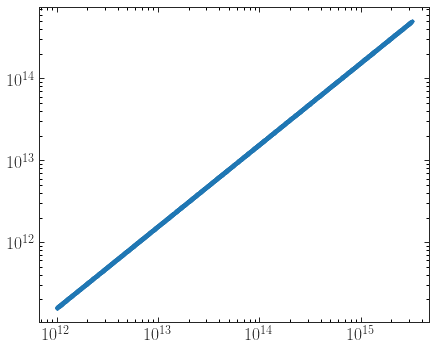

In [30]:
loglogplot()
plt.plot(masses, mgas_vals, '.')
coeffs = np.polyfit(np.log10(masses), np.log10(mgas_vals), deg=1)
print(coeffs) # It's a one-to-one... this probably makes sense
print(10**coeffs[1])
print(cbf) # Yah.. that's what I thought

# So, by definition: is Mgas just f_{bary} * M_vir when evaluated at R_vir

6.070041959168183


Text(0.5, 1.0, '$M_\\mathrm{vir} = 1.0e+14$')

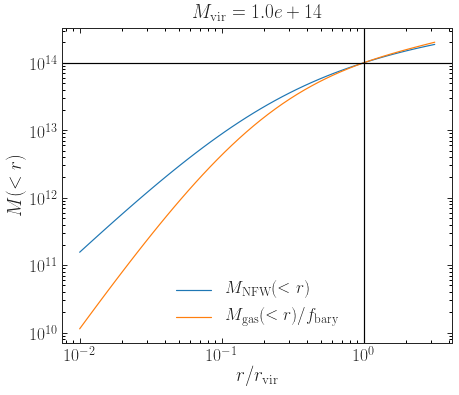

In [31]:
# let's look at M_encNFW vs. Mgas as a function of radius
mvir = 1e14
zobs = 0.0
conc = concentration.concentration(mvir, 'vir', zobs, model = 'diemer19')
print(conc)
Rvir = mass_so.M_to_R(mvir, zobs, 'vir')

nr = 50
rads = np.logspace(-2,0.5,nr)*Rvir
mass_vals = NFWM(rads, mvir, zobs, conc, Rvir)
mgas_vals = np.zeros(nr)
for i in range(0,nr):
    mgas_vals[i] = Mgas(rads[i], mvir, conc, Rvir)

loglogplot()
plt.plot(rads/Rvir, mass_vals, label=r'$M_\mathrm{NFW}(<r)$')
plt.plot(rads/Rvir, mgas_vals/cbf, label=r'$M_\mathrm{gas}(<r) / f_\mathrm{bary}$')
plt.axvline(1.0, color='k')
plt.axhline(mvir, color='k')
plt.xlabel(r'$r/r_\mathrm{vir}$')
plt.ylabel(r'$M(<r)$')
plt.legend(frameon=False)
plt.title(r'$M_\mathrm{vir} = %.1e$' % mvir)

# this looks good and agrees with the whole slope-matching thing in Komatsu and Seljak

Text(0, 0.5, '$k_\\mathrm{B} T(r)$ [eV]')

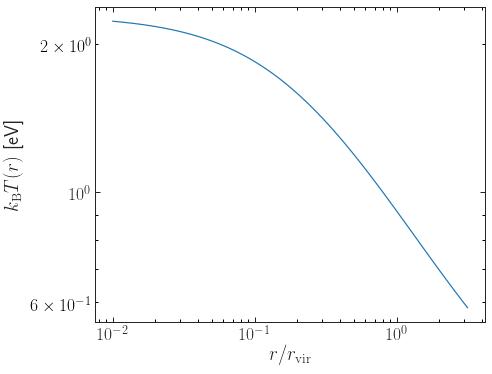

In [32]:
# let's look at the gas temperature profile
Tgas_vals = Tgas(rads, mvir, conc, Rvir)
loglogplot()
plt.plot(rads/Rvir, Tgas_vals*boltzmann)
plt.xlabel(r'$r/r_\mathrm{vir}$')
plt.ylabel(r'$k_\mathrm{B} T(r)$ [eV]')

# Tgas seems right, but Tmgas seems incorrect

# Let's plot T_mgas vs. Mass to see what the values are and make sure they make sense

[ 0.67036304 -9.04823853]


/home/sbg/anaconda3/lib/python3.7/site-packages/colossus/halo/concentration.py:434: UserWarning: Some masses or redshifts are outside the validity of the concentration model.
  warnings.warn('Some masses or redshifts are outside the validity of the concentration model.')
/home/sbg/anaconda3/lib/python3.7/site-packages/colossus/halo/concentration.py:434: UserWarning: Some masses or redshifts are outside the validity of the concentration model.
  warnings.warn('Some masses or redshifts are outside the validity of the concentration model.')
/home/sbg/anaconda3/lib/python3.7/site-packages/colossus/halo/concentration.py:434: UserWarning: Some masses or redshifts are outside the validity of the concentration model.
  warnings.warn('Some masses or redshifts are outside the validity of the concentration model.')
/home/sbg/anaconda3/lib/python3.7/site-packages/colossus/halo/concentration.py:434: UserWarning: Some masses or redshifts are outside the validity of the concentration model.
  warning

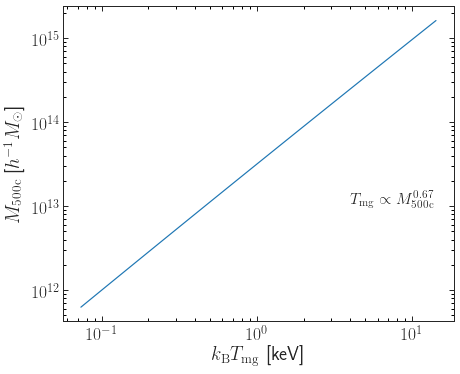

In [33]:
# loop over several masses, compute Tmgas, plot the trend and see if it agrees with Daisuke prediction

nm = 50
zobs = 0.0
masses = np.logspace(12, 15.5, nm)
m500c_vals = np.zeros(nm)
Tmg_vals = np.zeros(nm)
for i in range(0, nm):
    rv = mass_so.M_to_R(masses[i], zobs, 'vir')
    cv = concentration.concentration(masses[i], 'vir', zobs, model = 'duffy08')
    # Compute R500 and do it out to there, c
    M500c, R500c, _ = mass_defs.changeMassDefinition(masses[i], c=cv, z=zobs, mdef_in='vir', mdef_out='500c')
    m500c_vals[i] = M500c
    Tmg_vals[i] = Tmgas(R500c, masses[i], cv, rv)

loglogplot()
plt.plot(Tmg_vals*boltzmann, m500c_vals)
plt.ylabel(r'$M_\mathrm{500c}$ [$h^{-1} M_\odot$]')
plt.xlabel(r'$k_\mathrm{B}T_\mathrm{mg}$ [keV]')
coeffs = np.polyfit(np.log10(m500c_vals), np.log10(Tmg_vals*boltzmann), deg=1)
plt.text(4, 10**13, r'$T_\mathrm{mg} \propto M_\mathrm{500c}^{%.2f}$' % coeffs[0], fontsize=16)
print(coeffs)

In [34]:
# we give it virial mass, compute c_vir, R_vir
# can then compute r_500c

def nfw_prof(r, rhos, rs):
    return rhos / ((r/rs) * (1. + r/rs)**2)

mass = 10**12
c = 10
z=0
md = 'vir'

rvir = mass_so.M_to_R(mass, z, 'vir')

rhos, rs = profile_nfw.NFWProfile.fundamentalParameters(mass, c, z, md)
quad(lambda x: 4. * np.pi * x**2 * nfw_prof(x, rhos, rs), 0, rvir)[0] / mass

# perfect

1.0

In [41]:
# loop over the different masses, compute f_nth profile
# compute pressure profile, then compute pressure_thermal profile

def gen_YSZ(zobs, cosmo, mass_def='500c', rad_mult=5, timestep_factor=2, conc_model=zhao_vdb_conc, Nmah=9999, beta=beta_def, eta=eta_def, nrads=100, zi=6.):

    if(timestep_factor < 1):
        mah, redshifts, lbtime, masses = multimah_multiM(zobs, cosmo, Nmah, highT=int(1/timestep_factor))
    else:
        mah, redshifts, lbtime, masses = multimah_multiM(zobs, cosmo, Nmah)
    if(timestep_factor > 1):
        mah = mah[:,::timestep_factor]
        redshifts = redshifts[::timestep_factor]
        lbtime = lbtime[::timestep_factor]
    zi_snap = np.where(redshifts <= zi)[0][-1] + 1 #first snap over z=6
    t0 = cosmo.age(0) # this way we can easily get proper times using the lookback times from Frank's files

    n_steps = zi_snap
    
    # there will be a different radius for each of the haloes
    
    # going out to further radius helps the y_SZ...

    if(mass_def == '500c'):
        rvir_ratio = 20 # go out to 10x R500c which is a bit under 5x Rvir
    elif(mass_def == '200c'):
        rvir_ratio = 6 # go out ot 6x R200c which is a bit over 4x Rvir
    else:
        print("You didn't select a valid mass definition.")
        return -1
    
    rads = np.logspace(np.log10(0.01),np.log10(rvir_ratio), nrads) # NOW IN UNITS OF R/R_500c or R/R_200c

    ds2dt    = np.zeros((Nmah, n_steps, nrads))
    sig2tots = np.zeros((Nmah, n_steps, nrads))
    sig2nth  = np.zeros((Nmah, n_steps, nrads))
    fnth     = np.zeros((Nmah,nrads))
    Ptot     = np.zeros((Nmah,nrads))
    Pth      = np.zeros((Nmah,nrads))
    cvirs    = np.zeros(Nmah)
    YSZv     = np.zeros(Nmah)
    Tmgasv   = np.zeros(Nmah)
    Mgasv    = np.zeros(Nmah)
    yprof    = np.zeros((Nmah,nrads-1))
    mass_enc = np.zeros((Nmah)) # mass enclosed out to x*R_500c
    
    for mc in range(0,Nmah):
        if(mc % 100 == 0):
            print(mc)
        # get cvir so that we can get Rdef
        t04_ind = np.where(mah[mc,:] > 0.04*masses[mc])[0][-1]
        cvir = conc_model(t0 - lbtime[0], t0 - lbtime[t04_ind])
        Mdf, Rdef, _ = mass_defs.changeMassDefinition(masses[mc], c=cvir, z=zobs, mdef_in='vir', mdef_out=mass_def)
        rds  = rads*Rdef #convert to physical units; for r500c, this goes out to 10x R500c
        Rdef = Rdef*rad_mult # this is used for how far out we integrate Y_SZ...
        # TODO: Need to get the mass to integrate out to the proper radius for us to compare against M_5*500c
        
        rhos, rs = profile_nfw.NFWProfile.fundamentalParameters(masses[mc], cvir, zobs, 'vir')
        mass_enc[mc] = quad(lambda x: 4. * np.pi * x**2 * nfw_prof(x, rhos, rs), 0, Rdef)[0]
        # this contains the mass enclosed out to the radius of interest, for example 5R500c
        
        # integrate time to z=0 in order to get f_nth profile
        for i in range(zi_snap,0,-1):
            z_1 = redshifts[i] #first redshift
            z_2 = redshifts[i-1] #second redshift, the one we are actually at
            dt = lbtime[i] - lbtime[i-1] # in Gyr
            mass_1 = mah[mc, i] #dat = np.zeros((Nmah, nz))
            mass_2 = mah[mc, i-1]
            dM = mass_2 - mass_1
            dMdt = dM/dt # since the (i+1)th is computed between i+1 and i
            Rvir_1 = mass_so.M_to_R(mass_1, z_1, 'vir')
            Rvir_2 = mass_so.M_to_R(mass_2, z_2, 'vir')
            
            time_1 = t0 - lbtime[i]
            time_2 = t0 - lbtime[i-1]
            m04_1  = 0.04 * mass_1
            m04_2  = 0.04 * mass_2
            t04_ind_1 = np.where(mah[mc,:] > m04_1)[0][-1]
            t04_ind_2 = np.where(mah[mc,:] > m04_2)[0][-1]
            t04_1 = t0 - lbtime[t04_ind_1]
            t04_2 = t0 - lbtime[t04_ind_2]

            c_1 = conc_model(time_1, t04_1)
            c_2 = conc_model(time_2, t04_2)
            if(i==1): # final
                cvirs[mc] = c_2
                assert cvirs[mc] == cvir
            sig2tots[mc,i-1,:] = sig2_tot(rds, mass_2, c_2, Rvir_2) # this function takes radii in physical kpc/h
            if(i==zi_snap):
                ds2dt[mc,i-1,:] = (sig2tots[mc,i-1,:] - sig2_tot(rds, mass_1, c_1, Rvir_1)) / dt # see if this works better, full change
                sig2nth[mc,i-1,:] = eta * sig2tots[mc,i-1,:] # starts at z_i = 6 roughly
            else:
                ds2dt[mc,i-1,:] = (sig2tots[mc,i-1,:] - sig2tots[mc,i,:]) / dt
                td = t_d(rds, mass_2, z_2, c_2, Rvir_2, beta=beta_def) #t_d at z of interest z_2
                sig2nth[mc,i-1,:] = sig2nth[mc,i,:] + ((-1. * sig2nth[mc,i,:] / td) + eta * ds2dt[mc,i-1,:])*dt
                sig2nth[mc,i-1, sig2nth[mc,i-1,:] < 0] = 0 #can't have negative sigma^2_nth at any point in time
        fnth[mc,:] = sig2nth[mc,0,:] / sig2tots[mc,0,:]
        # Now, we have fnth, so we can compute the pressure profile and use it to compute the thermal pressure profile
        Rvir = mass_so.M_to_R(masses[mc], zobs, 'vir')
        Ptot[mc,:] = Ptot_prof(rds, masses[mc], cvirs[mc], Rvir)
        Pth[mc,:]  = Ptot[mc,:] * (1.0 - fnth[mc,:])
        # compute ySZ profile
        yprof[mc,:] = p_2_y(rds, Pth[mc,:])
    
        # integrate ySZ profile out to Rdef
        YSZv[mc] = YSZ(yprof[mc,:], rds[:-1], Rdef)
    #Mdefs, _, _ = mass_defs.changeMassDefinition(masses, c=cvirs, z=zobs, mdef_in='vir', mdef_out=mass_def)
    #fnth[fnth < 0] = 0
    return mass_enc, YSZv, Ptot, Pth, yprof, rads, fnth, cvirs, masses, sig2tots

In [114]:
# TODO: Figure out if we need to plot against the M_{5R500c} or is M_{500c} fine? Otherwise, how do I do it in Colossus?

In [289]:
# compute the YSZ values for M500c and plot against the masses
# function returns M500c and
cosmo = cosmology.setCosmology('planck18')
zobs = 0.0
M5R500c, YSZ5R500c, Ptots, Pths, yprofs, rads, fnths, concs, mvirs = gen_YSZ(zobs, cosmo, mass_def='500c', rad_mult=5, timestep_factor=1, conc_model=zhao_vdb_conc, Nmah=9999, beta=beta_def, eta=eta_def, nrads=100, zi=6.)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [ ]:
M500c, YSZ500c, Ptots, Pths, yprofs, rads, fnths, _, _ = gen_YSZ(zobs, cosmo, mass_def='500c', rad_mult=1, timestep_factor=1, conc_model=zhao_vdb_conc, Nmah=9999, beta=beta_def, eta=eta_def, nrads=100, zi=6.)

In [84]:
# cut down timestep factor by 2
m_tsf2, YSZ_tsf2, Ptots_tsf2, Pths_tsf2, yprofs_tsf2, rads_tsf2, fnths_tsf2, _, _ = gen_YSZ(zobs, cosmo, mass_def='500c', rad_mult=5, timestep_factor=2, conc_model=zhao_vdb_conc, Nmah=9999, beta=beta_def, eta=eta_def, nrads=100, zi=6.)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [85]:
m_tsf4, YSZ_tsf4, Ptots_tsf4, Pths_tsf4, yprofs_tsf4, rads_tsf4, fnths_tsf4, _, _ = gen_YSZ(zobs, cosmo, mass_def='500c', rad_mult=5, timestep_factor=4, conc_model=zhao_vdb_conc, Nmah=9999, beta=beta_def, eta=eta_def, nrads=100, zi=6.)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


[1.6690397] -22.78539807089173
[  1.6690397  -22.78539807]
0.02676100169349919 6.355756659544576
0.02139959217508581 5.050855177249214


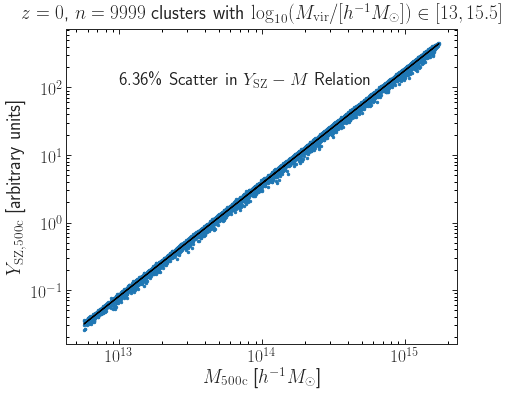

In [76]:
loglogplot()
plt.plot(M500c, YSZ500c, '.')

coeffs = np.polyfit(np.log10(M500c), np.log10(YSZ500c), deg=1)

reg = LinearRegression().fit(np.log10(M500c).reshape(-1, 1), np.log10(YSZ500c))
print(reg.coef_, reg.intercept_)
popt_log = [reg.intercept_, reg.coef_]

print(coeffs)
preds = 10**(coeffs[0]*np.log10(M500c) + coeffs[1])
plt.plot(M500c, preds, 'k')
plt.xlabel(r'$M_\mathrm{500c}$ [$h^{-1}M_\odot$]')
plt.ylabel(r'$Y_\mathrm{SZ,500c}$ [$h^{-1}$kpc$^2$]')


resids = np.log10(preds / YSZ500c)
scatter = np.std(resids)
rbscatter = (np.percentile(resids, 84) - np.percentile(resids, 16)) / 2.0
pc_scatter = (10**scatter -1) * 100
plt.text(1e13, 1e2, r'%.2f\%% Scatter in $Y_\mathrm{SZ}-M$ Relation' % pc_scatter, fontsize=18)
plt.title(r'$z=0$, $n=9999$ clusters with $\log_{10}(M_\mathrm{vir} / [h^{-1}M_\odot]) \in [13,15.5]$')

# let's also compute robust scatter

print(scatter,(10**scatter -1) * 100)
print(rbscatter,(10**rbscatter -1) * 100)

[1.62368237] -22.61457155129453
[  1.62368237 -22.61457155]
0.036380003534275056 8.737665169726561
0.03343643328923799 8.003152751621467


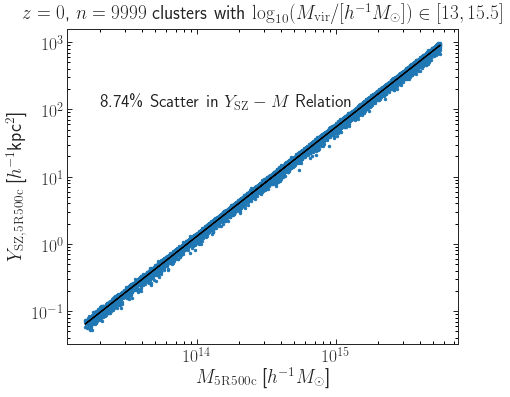

In [179]:
loglogplot()
plt.plot(M5R500c, YSZ5R500c, '.')

coeffs = np.polyfit(np.log10(M5R500c), np.log10(YSZ5R500c), deg=1)

reg = LinearRegression().fit(np.log10(M5R500c).reshape(-1, 1), np.log10(YSZ5R500c))
print(reg.coef_, reg.intercept_)
popt_log = [reg.intercept_, reg.coef_]

print(coeffs)
preds = 10**(coeffs[0]*np.log10(M5R500c) + coeffs[1])
plt.plot(M5R500c, preds, 'k')
plt.xlabel(r'$M_\mathrm{5R500c}$ [$h^{-1}M_\odot$]')
plt.ylabel(r'$Y_\mathrm{SZ,5R500c}$ [$h^{-1}$kpc$^2$]')


resids = np.log10(preds / YSZ5R500c)
scatter = np.std(resids)
rbscatter = (np.percentile(resids, 84) - np.percentile(resids, 16)) / 2.0
pc_scatter = (10**scatter -1) * 100
plt.text(2e13, 1e2, r'%.2f\%% Scatter in $Y_\mathrm{SZ}-M$ Relation' % pc_scatter, fontsize=18)
plt.title(r'$z=0$, $n=9999$ clusters with $\log_{10}(M_\mathrm{vir} / [h^{-1}M_\odot]) \in [13,15.5]$')

# let's also compute robust scatter

print(scatter,(10**scatter -1) * 100)
print(rbscatter,(10**rbscatter -1) * 100)

# 8.80% scatter with 9999
# 9.08% scatter with 1000
# 8.69% scatter with 2000
# 8.71% scatter with 3000
# So as we take more samples, we probably get a better estimate
# Regardless, the point here is to illustrate that a small sample with double temporal resolution should be
# enough to say whether or not we need to keep exploring smaller time steps

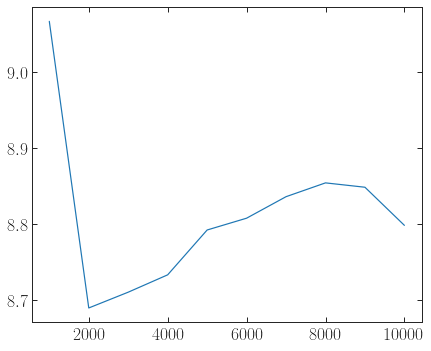

In [126]:
# look at scatter vs. number of samples included
mah_num = np.array(list(range(0,10)))*1000 + 999
sv = np.zeros(len(mah_num))
for i,mn in enumerate(mah_num):
    coeffs = np.polyfit(np.log10(M5R500c[:mn]), np.log10(YSZ5R500c[:mn]), deg=1)
    preds = 10**(coeffs[0]*np.log10(M5R500c[:mn]) + coeffs[1])
    resids = np.log10(preds / YSZ5R500c[:mn])
    scatter = np.std(resids)
    sv[i] = (10**scatter -1) * 100
    
plot()
plt.plot(mah_num, sv)
# clearly converges

In [118]:
# increasing the temporal resolution by a factor of 2
M5R500c_hiT2, YSZ5R500c_hiT2, Ptots, Pths, yprofs, rads, fnths, _, _ = gen_YSZ(zobs, cosmo, mass_def='500c', rad_mult=5, timestep_factor=0.5, conc_model=zhao_vdb_conc, Nmah=9999, beta=beta_def, eta=eta_def, nrads=100, zi=6.)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [142]:
M5R500c_hiT4, YSZ5R500c_hiT4, Ptots, Pths, yprofs, rads, fnths, _, _ = gen_YSZ(zobs, cosmo, mass_def='500c', rad_mult=5, timestep_factor=0.25, conc_model=zhao_vdb_conc, Nmah=9999, beta=beta_def, eta=eta_def, nrads=100, zi=6.)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


[1.62337873] -22.687773478119933
[  1.62337873 -22.68777348]
0.036467125640753474 8.759480792806439
0.033201266475127625 7.944685782689809


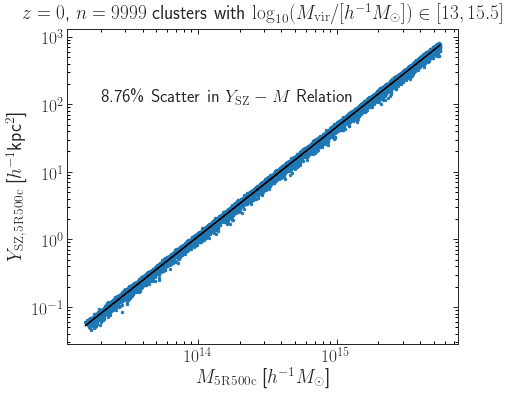

In [119]:
# increasing the temporal resolution by a factor of 2
loglogplot()
plt.plot(M5R500c_hiT2, YSZ5R500c_hiT2, '.')

coeffs = np.polyfit(np.log10(M5R500c_hiT2), np.log10(YSZ5R500c_hiT2), deg=1)

reg = LinearRegression().fit(np.log10(M5R500c_hiT2).reshape(-1, 1), np.log10(YSZ5R500c_hiT2))
print(reg.coef_, reg.intercept_)
popt_log = [reg.intercept_, reg.coef_]

print(coeffs)
preds = 10**(coeffs[0]*np.log10(M5R500c_hiT2) + coeffs[1])
plt.plot(M5R500c_hiT2, preds, 'k')
plt.xlabel(r'$M_\mathrm{5R500c}$ [$h^{-1}M_\odot$]')
plt.ylabel(r'$Y_\mathrm{SZ,5R500c}$ [$h^{-1}$kpc$^2$]')


resids = np.log10(preds / YSZ5R500c_hiT2)
scatter = np.std(resids)
rbscatter = (np.percentile(resids, 84) - np.percentile(resids, 16)) / 2.0
pc_scatter = (10**scatter -1) * 100
plt.text(2e13, 1e2, r'%.2f\%% Scatter in $Y_\mathrm{SZ}-M$ Relation' % pc_scatter, fontsize=18)
plt.title(r'$z=0$, $n=9999$ clusters with $\log_{10}(M_\mathrm{vir} / [h^{-1}M_\odot]) \in [13,15.5]$')

# let's also compute robust scatter

print(scatter,(10**scatter -1) * 100)
print(rbscatter,(10**rbscatter -1) * 100)

# 8.99% scatter with 1000
# 8.90% scatter with 2000

[1.62328394] -22.685921157946723
[  1.62328394 -22.68592116]
0.03662228528364905 8.79834404741695
0.03370915484639037 8.070996206792259


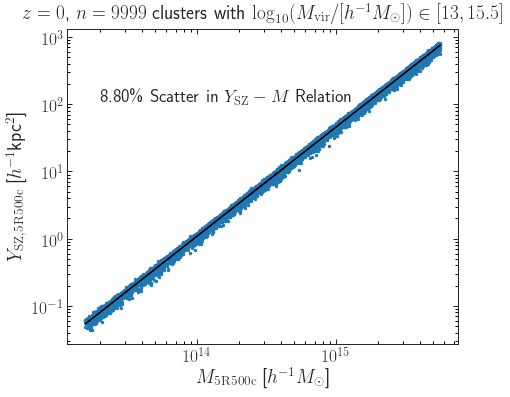

In [143]:
# increasing the temporal resolution by a factor of 4
loglogplot()
plt.plot(M5R500c_hiT4, YSZ5R500c_hiT4, '.')

coeffs = np.polyfit(np.log10(M5R500c_hiT4), np.log10(YSZ5R500c_hiT4), deg=1)

reg = LinearRegression().fit(np.log10(M5R500c_hiT4).reshape(-1, 1), np.log10(YSZ5R500c_hiT4))
print(reg.coef_, reg.intercept_)
popt_log = [reg.intercept_, reg.coef_]

print(coeffs)
preds = 10**(coeffs[0]*np.log10(M5R500c_hiT4) + coeffs[1])
plt.plot(M5R500c_hiT4, preds, 'k')
plt.xlabel(r'$M_\mathrm{5R500c}$ [$h^{-1}M_\odot$]')
plt.ylabel(r'$Y_\mathrm{SZ,5R500c}$ [$h^{-1}$kpc$^2$]')


resids = np.log10(preds / YSZ5R500c_hiT4)
scatter = np.std(resids)
rbscatter = (np.percentile(resids, 84) - np.percentile(resids, 16)) / 2.0
pc_scatter = (10**scatter -1) * 100
plt.text(2e13, 1e2, r'%.2f\%% Scatter in $Y_\mathrm{SZ}-M$ Relation' % pc_scatter, fontsize=18)
plt.title(r'$z=0$, $n=9999$ clusters with $\log_{10}(M_\mathrm{vir} / [h^{-1}M_\odot]) \in [13,15.5]$')

# let's also compute robust scatter

print(scatter,(10**scatter -1) * 100)
print(rbscatter,(10**rbscatter -1) * 100)

In [ ]:
# the scatter seems to converge
# down by factor of 4: 9.50
# down by factor of 2: 9.02
# fiducial: 8.80
# up by factor of 2: 8.76
# up by factor of 4: 8.80

# NOTE: In order to reproduce this result, I would need to go back to my old set of clusters
# I am using a new set that spans a larger range of masses, so keep this in mind when we are generating new plots

# also need to demonstrate convergence with number of clusters as well (DONE)

# keep in mind that these values may change slightly since we're using a different, larger mass range
# for when we do the full analysis that spans the different cosmologies
# --> This is only an issue if the bottom 10**12 -- 10**13 Msun Mvir haloes behave differently

# should ask Frank about the minimum mass HOST halo that we should trust

[1.62328004] -22.68584077240867
[  1.62328004 -22.68584077]
0.03750945337910861 9.020822291798215
0.034033461197454234 8.151727602468606


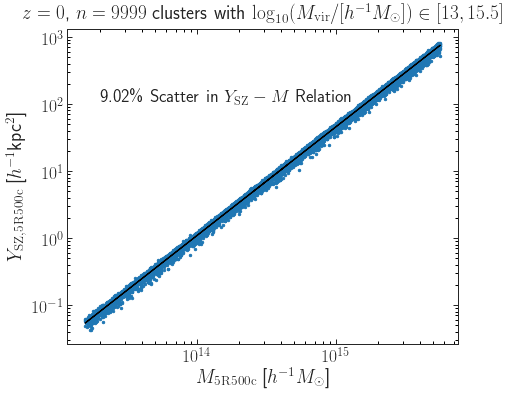

In [121]:
# Decreasing the temporal resolution by a factor of 2

# the scatter increases as our temporal resolution decreases...
# we probably need to see if we can ramp up the timestep a bit and regenerate the data to make sure...

loglogplot()
plt.plot(m_tsf2, YSZ_tsf2, '.')

coeffs = np.polyfit(np.log10(m_tsf2), np.log10(YSZ_tsf2), deg=1)

reg = LinearRegression().fit(np.log10(m_tsf2).reshape(-1, 1), np.log10(YSZ_tsf2))
print(reg.coef_, reg.intercept_)
popt_log = [reg.intercept_, reg.coef_]

print(coeffs)
preds = 10**(coeffs[0]*np.log10(m_tsf2) + coeffs[1])
plt.plot(M5R500c, preds, 'k')
plt.xlabel(r'$M_\mathrm{5R500c}$ [$h^{-1}M_\odot$]')
plt.ylabel(r'$Y_\mathrm{SZ,5R500c}$ [$h^{-1}$kpc$^2$]')


resids = np.log10(preds / YSZ_tsf2)
scatter = np.std(resids)
rbscatter = (np.percentile(resids, 84) - np.percentile(resids, 16)) / 2.0
pc_scatter = (10**scatter -1) * 100
plt.text(2e13, 1e2, r'%.2f\%% Scatter in $Y_\mathrm{SZ}-M$ Relation' % pc_scatter, fontsize=18)
plt.title(r'$z=0$, $n=9999$ clusters with $\log_{10}(M_\mathrm{vir} / [h^{-1}M_\odot]) \in [13,15.5]$')

# let's also compute robust scatter

print(scatter,(10**scatter -1) * 100)
print(rbscatter,(10**rbscatter -1) * 100)

[1.62314525] -22.683967958756668
[  1.62314525 -22.68396796]
0.03943184450190106 9.504469231963686
0.03468772564379643 8.314780921664532


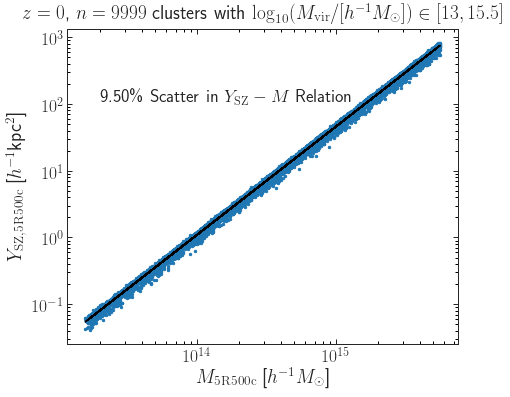

In [134]:
# Decreasing the temporal resolution by a factor of 4

loglogplot()
plt.plot(m_tsf4, YSZ_tsf4, '.')

coeffs = np.polyfit(np.log10(m_tsf4), np.log10(YSZ_tsf4), deg=1)

reg = LinearRegression().fit(np.log10(m_tsf4).reshape(-1, 1), np.log10(YSZ_tsf4))
print(reg.coef_, reg.intercept_)
popt_log = [reg.intercept_, reg.coef_]

print(coeffs)
preds = 10**(coeffs[0]*np.log10(m_tsf4) + coeffs[1])
plt.plot(M5R500c, preds, 'k')
plt.xlabel(r'$M_\mathrm{5R500c}$ [$h^{-1}M_\odot$]')
plt.ylabel(r'$Y_\mathrm{SZ,5R500c}$ [$h^{-1}$kpc$^2$]')


resids = np.log10(preds / YSZ_tsf4)
scatter = np.std(resids)
rbscatter = (np.percentile(resids, 84) - np.percentile(resids, 16)) / 2.0
pc_scatter = (10**scatter -1) * 100
plt.text(2e13, 1e2, r'%.2f\%% Scatter in $Y_\mathrm{SZ}-M$ Relation' % pc_scatter, fontsize=18)
plt.title(r'$z=0$, $n=9999$ clusters with $\log_{10}(M_\mathrm{vir} / [h^{-1}M_\odot]) \in [13,15.5]$')

# let's also compute robust scatter

print(scatter,(10**scatter -1) * 100)
print(rbscatter,(10**rbscatter -1) * 100)

In [263]:
# For each of these Y_SZ values, we can compute the T_mgas and M_gas given its radius and concentration

# NOTE: These T_mgas values are incorrectly assuming the total pressure and thermal pressure are the same
# Will need to change this
cosmo = cosmology.setCosmology('planck18')
zobs = 0.0
nm=1000
M500c, YSZ500c, Ptots, Pths, yprofs, rads, fnths, concs, mvirs = gen_YSZ(zobs, cosmo, mass_def='500c', rad_mult=1, timestep_factor=1, conc_model=zhao_vdb_conc, Nmah=nm, beta=beta_def, eta=eta_def, nrads=100, zi=6.)
# we have the masses, concs, rvirs
rvirs = mass_so.M_to_R(mvirs, zobs, 'vir')
# will eventually want to change to normalize by 200m vs. 200c

# generate
Mg_vals = np.zeros(nm)
Tmg_vals = np.zeros(nm)
for i in range(0,nm):
    Mg_vals[i] = Mgas(rvirs[i], mvirs[i], concs[i], rvirs[i])
    Tmg_vals[i] = Tmgas(rvirs[i], mvirs[i], concs[i], rvirs[i]) # this is computed incorrectly

0
100
200
300
400
500
600
700
800
900


[ 0.98146311 20.48500025]


Text(0, 0.5, '$Y_\\mathrm{SZ,500c}$ [Mpc$^2$]')

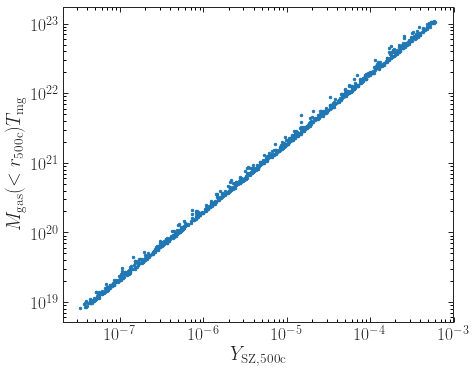

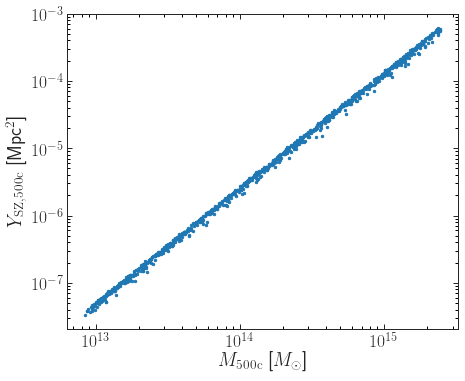

In [272]:
loglogplot()
plt.plot(YSZ500c / (cosmo.H0 / 100.) * 10**-6, Mg_vals*Tmg_vals, '.')
plt.xlabel(r'$Y_\mathrm{SZ, 500c}$')
plt.ylabel(r'$M_\mathrm{gas}(<r_\mathrm{500c})T_\mathrm{mg}$')
coeffs = np.polyfit(np.log10(YSZ500c), np.log10(Mg_vals*Tmg_vals), deg=1)
print(coeffs)
# slope of 0.98... the proportionality between Y_SZ and T_mgas*M_gas is correct!!

loglogplot()
plt.plot(M500c / (cosmo.H0 / 100.), YSZ500c / (cosmo.H0 / 100.) * 10**-6, '.')
plt.xlabel(r'$M_\mathrm{500c}$ [$M_\odot$]')
plt.ylabel(r'$Y_\mathrm{SZ,500c}$ [Mpc$^2$]')
# verified that the values look good

In [42]:
cosmo = cosmology.setCosmology('planck18')
zobs = 0.0
nm=500
M500c, YSZ500c, Ptots, Pths, yprofs, rads, fnths, concs, mvirs, sig2tots = gen_YSZ(zobs, cosmo, mass_def='500c', rad_mult=1, timestep_factor=1, conc_model=zhao_vdb_conc, Nmah=nm, beta=beta_def, eta=eta_def, nrads=100, zi=6.)

0
100
200
300
400


14.31846
6.34980645746059


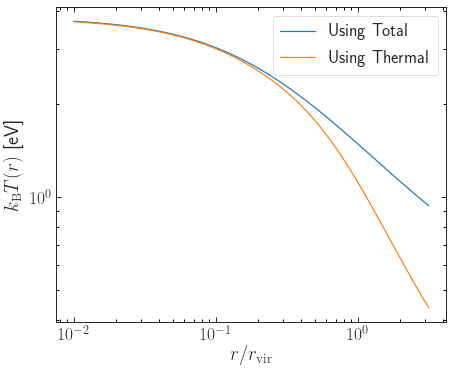

In [44]:
# don't tell me they look correct for 14.7 only and it is still wrong otherwise, that would be terrible!

ind = 5
print(np.log10(mvirs[ind]))

mvir = mvirs[ind]
zobs = 0.0
conc = concs[ind]
print(conc)
Rvir = mass_so.M_to_R(mvir, zobs, 'vir')

nr = 50
rads = np.logspace(-2,0.5,nr)*Rvir


Tg = mu_plasma * mp_kev_by_kms2 * (1. - fnths[ind,:]) * sig2tots[ind,0,:] #Tgasz * theta(rad)**(Gamma(cvirs[mc]) - 1.0)
Mdf, Rdef, _ = mass_defs.changeMassDefinition(mvirs[ind], c=conc, z=zobs, mdef_in='vir', mdef_out='500c')
rds = np.logspace(np.log10(0.01),np.log10(20), 100)*Rdef
Tgf = interp(rds, Tg) # these are in physical units, can divide by Rvir

    
Tgas_vals = Tgas(rads, mvir, conc, Rvir)
loglogplot()
plt.plot(rads/Rvir, Tgas_vals*boltzmann, label='Using Total')
plt.plot(rads/Rvir, Tgf(rads), label='Using Thermal')
plt.xlabel(r'$r/r_\mathrm{vir}$')
plt.ylabel(r'$k_\mathrm{B} T(r)$ [eV]')
plt.legend()

# It seems like the total is actually the one that is correct and the issue is with the thermal

In [ ]:
# need to do one of these once again

loglogplot()
plt.plot(M200c, YSZ200c, '.')

coeffs = np.polyfit(np.log10(M200c), np.log10(YSZ200c), deg=1)

reg = LinearRegression().fit(np.log10(M200c).reshape(-1, 1), np.log10(YSZ200c))
print(reg.coef_, reg.intercept_)
popt_log = [reg.intercept_, reg.coef_]

print(coeffs)
preds = 10**(coeffs[0]*np.log10(M200c) + coeffs[1])
plt.plot(M200c, preds, 'k')
plt.xlabel(r'$M_\mathrm{5R500c}$ [$h^{-1}M_\odot$]')
plt.ylabel(r'$Y_\mathrm{SZ,5R500c}$ [arbitrary units]')


resids = np.log10(preds / YSZ200c)
scatter = np.std(resids)
rbscatter = (np.percentile(resids, 84) - np.percentile(resids, 16)) / 2.0
pc_scatter = (10**scatter -1) * 100
plt.text(2e13, 1e20, r'%.2f\%% Scatter in $Y_\mathrm{SZ}-M$ Relation' % pc_scatter, fontsize=18)
plt.title(r'$z=0$, $n=9999$ clusters with $\log_{10}(M_\mathrm{vir} / [h^{-1}M_\odot]) \in [13,15.5]$')

# let's also compute robust scatter

print(scatter,(10**scatter -1) * 100) # in dex; there is literally no error here...
print(rbscatter,(10**rbscatter -1) * 100)
# goes as mass to the 5/3... EXACTLY. Is this understood?


# do linear regression
# get slope, intercept, scatter, etc.

In [128]:
# let's do it another way, instead we just take the f_nth values and loop over some multiples of R_500c

Nmah = 9999
nrads = 100
zobs = 0.00

Ptot     = np.zeros((Nmah,nrads))
Pth      = np.zeros((Nmah,nrads))
YSZv     = np.zeros(Nmah)
yprof    = np.zeros((Nmah,nrads-1))
mass_enc = np.zeros((Nmah)) # mass enclosed out to x*R_500c

r500c_mult_min = 1
r500c_mult_max = 5

nr = 6

rad_mults = np.linspace(r500c_mult_min, r500c_mult_max, nr)

scatters = np.zeros(nr)
coeffs = np.zeros((nr,2))

mah, _, lbtime, masses = multimah_multiM(zobs, cosmo, Nmah)
t0 = cosmo.age(0)

In [129]:
for i,rm in enumerate(rad_mults):
    print(i)
    for mc in range(0,len(masses)):
        if(mc % 1000 == 0):
            print("mc", mc)
        t04_ind = np.where(mah[mc,:] > 0.04*masses[mc])[0][-1]
        cvir = zhao_vdb_conc(t0 - lbtime[0], t0 - lbtime[t04_ind])
        Mdf, Rdef, _ = mass_defs.changeMassDefinition(masses[mc], c=cvir, z=zobs, mdef_in='vir', mdef_out='500c')
        rds  = rads*Rdef #convert to physical units; for r500c, this goes out to 10x R500c
        Rdef = Rdef*rm # this is used for how far out we integrate Y_SZ...

        rhos, rs = profile_nfw.NFWProfile.fundamentalParameters(masses[mc], cvir, zobs, 'vir')
        mass_enc[mc] = quad(lambda x: 4. * np.pi * x**2 * nfw_prof(x, rhos, rs), 0, Rdef)[0]


        Rvir = mass_so.M_to_R(masses[mc], zobs, 'vir')
        Ptot[mc,:] = Ptot_prof(rds, masses[mc], cvir, Rvir)
        Pth[mc,:]  = Ptot[mc,:] * (1.0 - fnths[mc,:])
        yprof[mc,:] = p_2_y(rds, Pth[mc,:])
        YSZv[mc] = YSZ(yprof[mc,:], rds[:-1], Rdef)
    # now do analysis
    cfs = np.polyfit(np.log10(mass_enc), np.log10(YSZv), deg=1)
    preds = 10**(cfs[0]*np.log10(mass_enc) + cfs[1])
    resids = np.log10(preds / YSZv)
    scatters[i] = np.std(resids)
    coeffs[i,:] = cfs

0
mc 0
mc 1000
mc 2000
mc 3000
mc 4000
mc 5000
mc 6000
mc 7000
mc 8000
mc 9000
1
mc 0
mc 1000
mc 2000
mc 3000
mc 4000
mc 5000
mc 6000
mc 7000
mc 8000
mc 9000
2
mc 0
mc 1000
mc 2000
mc 3000
mc 4000
mc 5000
mc 6000
mc 7000
mc 8000
mc 9000
3
mc 0
mc 1000
mc 2000
mc 3000
mc 4000
mc 5000
mc 6000
mc 7000
mc 8000
mc 9000
4
mc 0
mc 1000
mc 2000
mc 3000
mc 4000
mc 5000
mc 6000
mc 7000
mc 8000
mc 9000
5
mc 0
mc 1000
mc 2000
mc 3000
mc 4000
mc 5000
mc 6000
mc 7000
mc 8000
mc 9000


In [726]:
(10**scatters[-1] - 1.0)*100 # why is this slightly different from the other code, should agree exactly

10.0276018624599

[6.35575666 6.91335979 7.60112098 8.11748515 8.50167614 8.79834405]


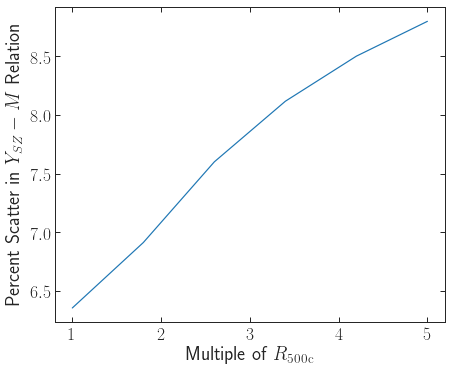

In [137]:
# to plot:
# scatter, intercept, slope vs. x, where x is multiple of R_500c out to which we integrate for Y_SZ
#plot()
#plt.plot(rad_mults, scatters)

pc_scatters = (10**scatters - 1.0)*100

plot()
plt.plot(rad_mults, pc_scatters)
plt.xlabel(r'Multiple of $R_\mathrm{500c}$')
plt.ylabel(r'Percent Scatter in $Y_{SZ}-M$ Relation')

print(pc_scatters)

# make sure the R500c and 5R500c results agree with what we have above
# 6.355756659544576 and 8.79834404741695 (check!)

Text(0, 0.5, 'Power Law Normalization')

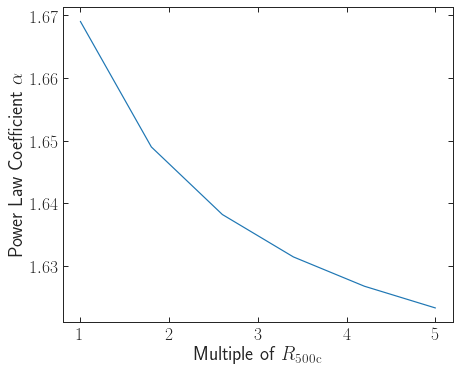

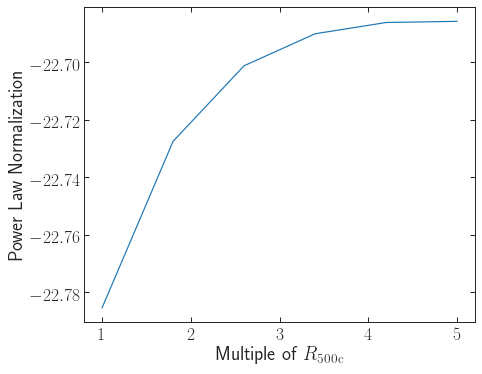

In [131]:
plot()
plt.plot(rad_mults, coeffs[:,0])
plt.xlabel(r'Multiple of $R_\mathrm{500c}$')
plt.ylabel(r'Power Law Coefficient $\alpha$')

plot()
plt.plot(rad_mults, coeffs[:,1])
plt.xlabel(r'Multiple of $R_\mathrm{500c}$')
plt.ylabel(r'Power Law Normalization') # Need to change the zero point

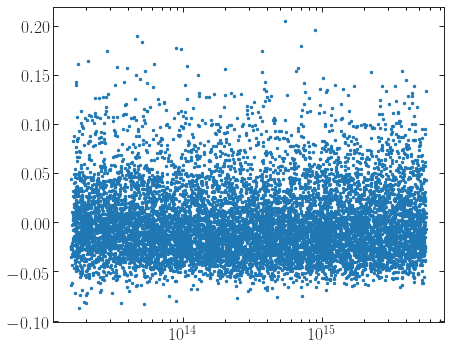

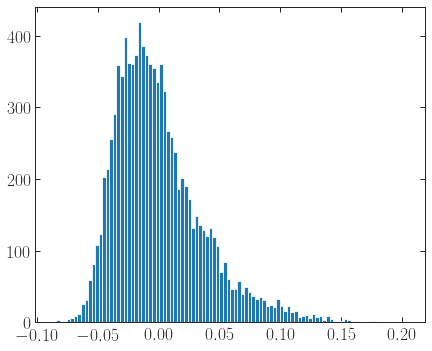

In [141]:
plot(semilogx=True)
plt.plot(M5R500c, resids, '.')
plot()
plt.hist(resids, bins='sqrt');

# This is much less Gaussian than it looked before, but there still doesn't seem to be much mass dependence
# Regardless, it may change whether or not we want to report std devs or quantile scater

Text(0, 0.5, '$r_\\mathrm{vir} / r_\\mathrm{def}$')

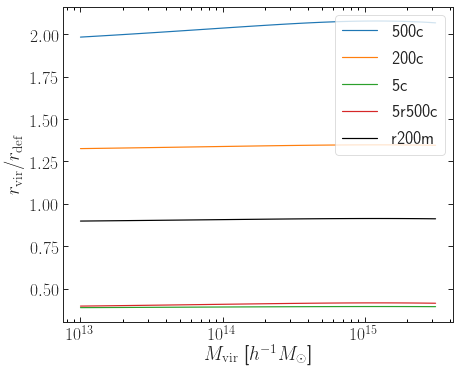

In [274]:
# let's just see how similar 5R500c is to other values of c

Nmv = 100
z = 0.0
Mvir_vals = np.logspace(13, 15.5, Nmv)
ratios_500c = np.zeros(Nmv)
ratios_200c = np.zeros(Nmv)
ratios_200m = np.zeros(Nmv)
ratios_5r500c = np.zeros(Nmv)
ratios_5c = np.zeros(Nmv)
# let's plot the ratio of Rvir / R500c and Rvir / R200c
for i in range(0, Nmv):
    # get concentration
    cvir = concentration.concentration(Mvir_vals[i], 'vir', 0.0, model = 'diemer19')
    M500c, _, _ = mass_defs.changeMassDefinition(Mvir_vals[i], c=cvir, z=z, mdef_in='vir', mdef_out='500c')
    M200c, _, _ = mass_defs.changeMassDefinition(Mvir_vals[i], c=cvir, z=z, mdef_in='vir', mdef_out='200c')
    M5c, _, _ = mass_defs.changeMassDefinition(Mvir_vals[i], c=cvir, z=z, mdef_in='vir', mdef_out='5c')
    ratios_500c[i] = mass_so.M_to_R(Mvir_vals[i], z, 'vir') / mass_so.M_to_R(M500c, z, '500c')
    ratios_200c[i] = mass_so.M_to_R(Mvir_vals[i], z, 'vir') / mass_so.M_to_R(M200c, z, '200c')
    ratios_200m[i] = mass_so.M_to_R(Mvir_vals[i], z, 'vir') / mass_so.M_to_R(M200c, z, '200m')
    ratios_5r500c[i] = ratios_500c[i] / 5. #replacing denominator with 5*r500c
    ratios_5c[i] = mass_so.M_to_R(Mvir_vals[i], z, 'vir') / mass_so.M_to_R(M200c, z, '5c')

plot(semilogx=True)
plt.plot(Mvir_vals, ratios_500c, label='500c')
plt.plot(Mvir_vals, ratios_200c, label='200c')
plt.plot(Mvir_vals, ratios_5c, label='5c')
plt.plot(Mvir_vals, ratios_5r500c, label='5r500c')
plt.plot(Mvir_vals, ratios_200m, color='k', label='r200m')
plt.legend()
plt.xlabel(r'$M_\mathrm{vir}$ [$h^{-1}M_\odot$]')
plt.ylabel(r'$r_\mathrm{vir} / r_\mathrm{def}$')

# so if we go out to 5x R500c, then we're going out to 2x Rvir roughly
# if we go out to 3x R200c, then we're going out to 2x Rvir roughly

# Rvir is roughly 2xR500c, so 5R500c is roughly 2.5R_vir
# Rvir is ~0.85R_200m, so we can do 0.5x to 2.0x R_200m

## To-do List and Outstanding Ideas

In [ ]:
# Notes based on discussion with Han:

# 1. Look at different redshifts
# 2. Look at different classes of clusters as relaxed vs. disturbed using various definitions of mass accretion rate
#    Two options: Lambda = dlnM/dlna vs. Lambda = dM/dt over z=0 to z=1.5
# 3. Get a physical explanation for why/how the slope, intercept, and scatter depend on the aperture in the Y_SZ - M reln
# 4. Code up something that computes the mass enclosed for arbitrary radius and set it up to do Y_{SZ,5R500c} vs. M_{5R500c}

# based on discussion with Frank:
#	1. Is y_SZ computed with the thermal or TOTAL; Frank thinks it should be total since it includes the turbulent motion which affects the electron gas
#	2. What is sigma_tot? Does the Komatsu and Seljak model really account for total or is the assumption of hydrostatic equilibrium to compute the sigma_tot mean it doesn't include the nonthemal energy
#	3. Eddy turnover time to figure out the beta value
#   4. Consistency check: see if the results depend on Frank's number of redshift outputs…
#      --> Verify that this works with a higher time resolution than what we currently have

# **figure out why the slope decreases as radius of aperture increases**
# Shaw et al 2010 demonstrates that for total pressure, a constant polytropic index is justified
# using simulations; this justifies changing the model from P_therm to P_tot in Komatsu/Seljak
# The thermal pressure in simulations actually has a running of Gamma vs. radius

# but why doesn't the turbulence affect the y_SZ?
# Daisuke expects highly accreting objects have lower thermal pressure

In [148]:
# questions from Daisuke:
# What is the scatter within R_500c (not sure what he meant here...)
# Check varied Y apertures with fixed Mass aperature to M_500c
# Focus understanding on how temperature is changing radially for different clusters using Komatsu and Seljak
# Figure out why we don't get *closer* to Y\propto M^1.67 as we go to smaller aperture radii
# Look at the f_nth profiles in linear space for high and low-mass systems on the same plot
# The sign of the effect in the slope should depend on the f_nth differences and how this changes with radius

# Plot the data for multiple different apertures

# Focus on explaining the slope and scatter, but can use observations when discussing the normalization

# Daisuke checks on f_nth:
# Nelson+14
# Look at f_nth vs r/r_vir, r/r_200c, r/r_200m
# See if there is no redshift dependence when doing it in terms of r/r_200m (one fitting function if you use r/r_200m)
# Look for cosmological dependence by plotting in terms of r/r_200m, try some different values of S_8

# TODO on f_nth front: Figure out the r/r_200m; what is proper way to reproduce Nelson et al results?
# Can we reproduce the result, overplot their fitting function?
# Can we then vary S_8 or Omega_M and see if there is more noteworthy cosmological dependence then?
# After we make it through these tests, go back to understanding the evolution of Y_SZ vs. Mass, can then write up

## Code to run on Grace

In [ ]:
import sys
import numpy as np
import colossus
from colossus.cosmology import cosmology
from colossus.halo import concentration, mass_so, profile_nfw, mass_defs
from pathlib import Path
from os.path import expanduser
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline as interp
from os.path import isfile

print("Finished imports", flush=True)

# constants and directories:

cosmo_to_evcm3 = 4.224e-10
mu_plasma = 0.6
Gmp_by_kB = 5.21e-4 # in kpc * K / Msun
boltzmann = 8.617e-8 # in keV per Kelvin
sigmaT_by_mec2 = 1.697E-18 # kpc^2 s^2 / Msun / km^2
mp_kev_by_kms2 = 1.044E-5 # in KeV / (km/s)^2
G = colossus.utils.constants.G
cm_per_km = 1e5
km_per_kpc = colossus.utils.constants.KPC / cm_per_km # KPC was in cm
s_per_Gyr = colossus.utils.constants.GYR
yr_per_Gyr = 1E9

home_dir = Path(expanduser('~'))
multimah_root = home_dir / 'scratch60/frank_mah/output'

# TUNABLE PARAMETERS

beta_def = 1.0
eta_def  = 0.7
Nmah = 9999
Nradii = 500
N_r500_mult = 20
zi=6.
zobs = 0.0

# adding additional cosmologies based on conversation with Daisuke

# four extremes with low/high Om0 and sigma8
# note that the Omega_Lambda is changed accordingly by varying Om0
fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['Om0'] = 0.1
cosmology.addCosmology('planck18_vlO', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['Om0'] = 0.5
cosmology.addCosmology('planck18_vhO', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['sigma8'] = 0.5
cosmology.addCosmology('planck18_vlS', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['sigma8'] = 1.2
cosmology.addCosmology('planck18_vhS', fiducial_params)


# six low/high Om0, sigma8, H0
fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['Om0'] = 0.25
cosmology.addCosmology('planck18_lO', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['Om0'] = 0.35
cosmology.addCosmology('planck18_hO', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['sigma8'] = 0.7
cosmology.addCosmology('planck18_lS', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['sigma8'] = 0.9
cosmology.addCosmology('planck18_hS', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['H0'] = 65
cosmology.addCosmology('planck18_lH', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['H0'] = 75
cosmology.addCosmology('planck18_hH', fiducial_params)

cname = sys.argv[1] # load in cosmology name from the ones above
cosmo = cosmology.setCosmology(cname)
cbf = cosmo.Ob0 / cosmo.Om0

radii_definitions = [('vir', 1), ('500c', 1), ('500c', 2), ('500c', 3), ('500c', 4), ('500c', 5),
                     ('200m', 0.5), ('200m', 0.875), ('200m', 1.0), ('200m', 1.25), ('200m', 1.625),
                     ('200m', 2.0)]


def zhao_vdb_conc(t, t04):
    return 4.0 * (1.0 + (t / (3.40*t04))**6.5)**(1.0/8.0)

# CAN CHANGE THIS IF WE IMPLEMENT LUDLOW
conc_model=zhao_vdb_conc

def nfw_prof(r, rhos, rs):
    return rhos / ((r/rs) * (1. + r/rs)**2)

def NFWf(x):
    return np.log(1. + x) - x/(1. + x)

def NFWM(r, M, z, c, R):
    return M * NFWf(c*r/R) / NFWf(c)

def t_d(r, M, z, c, R, beta=beta_def):
    Menc = NFWM(r, M, z, c, R)
    t_dyn = 2. * np.pi * (r**3 / (G*Menc))**(1./2.) * km_per_kpc / (cosmology.getCurrent().H0 / 100.)
    return beta * t_dyn / s_per_Gyr / 2.

def Gamma(c_nfw):
    return 1.15 + 0.01*(c_nfw - 6.5)

def eta0(c_nfw):
    return 0.00676*(c_nfw - 6.5)**2 + 0.206*(c_nfw - 6.5) + 2.48

def multimah_multiM(z_obs, cosmo, Nmah):
    # loads in an array of MAH from Frank's MAH code, specify Nmah = number of MAH to get
    mah_dir = multimah_root / ('%s' % (cosmo.name))
    fn = mah_dir / 'mah_data.npz'
    if(isfile(fn)):
        d = np.load(fn)
        return d['dat'], d['redshifts'], d['lbtime'], d['masses']
    else:
        masses = 10**np.loadtxt(mah_dir / 'halomasses.dat')[:Nmah]
        dat1 = np.loadtxt(mah_dir / 'MAH0001.dat')
        redshifts = dat1[:,1]
        lbtime = dat1[:,2]
        nz = len(dat1)
        dat = np.zeros((Nmah, nz))
        std = np.zeros((nz,2))
        for i in range(0,Nmah):
            dat[i,:] = 10**np.loadtxt(mah_dir / ('MAH%04d.dat' %(i+1)), usecols=3) * masses[i]
        np.savez(fn, dat=dat, redshifts=redshifts, lbtime=lbtime, masses=masses)
        return dat, redshifts, lbtime, masses

def sig2_tot(r, M, c, R):
    rho0_by_P0 = 3*eta0(c)**-1 * R/(G*M)
    phi0 = -1. * (c / NFWf(c))
    phir = -1. * (c / NFWf(c)) * (np.log(1. + c*r/R) / (c*r/R))
    theta = 1. + ((Gamma(c) - 1.) / Gamma(c)) * 3. *eta0(c)**-1 * (phi0 - phir)
    return (1.0 / rho0_by_P0) * theta

def p_2_y(r,p):
    '''
    Discrete Integration for y, calculate int P dl, l=np.sqrt(r3d^2-r2d^2).
    If P is in unit of P200m, r in unit of R200m, y is in unit of P200m*R200m.
    r is 3D radius (r3d), P is pressure, ind is index of 2D radius array (r2d) you want y value for.
    Assume 2D radius array is same as 3D radius. Assume equal log space.
    '''
    yv = np.zeros(len(r)-1)
    dlogr = np.log(r[2]/r[1])
    for i in range(0,len(r)-1):
        yv[i] = np.sum(p[i+1:]*r[i+1:]**2*dlogr/np.sqrt(r[i+1:]**2-r[i]**2))
    return sigmaT_by_mec2 * yv # this is in units of h

# This outputs in units of kpc^2 / h, standard unit is Mpc^2, verified magnitudes
def YSZ(yprof, rads, Rx):
    # interpolate the yprof
    yprof_interp = interp(rads, yprof, k=3)
    Y = 2.0 * np.pi * quad(lambda x: yprof_interp(x) * x, 0, Rx)[0]
    return Y

def gen_obs(cosmo, beta=beta_def, eta=eta_def):

    mah, redshifts, lbtime, masses = multimah_multiM(zobs, cosmo, Nmah)
    print("Loaded MAH", flush=True)
    zi_snap = np.where(redshifts <= zi)[0][-1] + 1 #first snap over z=6
    t0 = cosmo.age(0) # this way we can easily get proper times using the lookback times from Frank's files

    n_steps = zi_snap
    
    rads = np.logspace(np.log10(0.01),np.log10(N_r500_mult), Nradii) # y_SZ goes out to 20x R_500c for LOS integration

    ds2dt    = np.zeros((n_steps, Nradii))
    sig2tots = np.zeros((n_steps, Nradii))
    sig2nth  = np.zeros((n_steps, Nradii))
    cvirs    = np.zeros(Nmah)
    # The values that we will return and column_stack
    YSZv     = np.zeros((Nmah, len(radii_definitions)))
    Tmgasv   = np.zeros((Nmah, len(radii_definitions)))
    Mgasv    = np.zeros((Nmah, len(radii_definitions)))
    mass_enc = np.zeros((Nmah, len(radii_definitions)))
    
    for mc in range(0,Nmah):
        if(mc % 100 == 0):
            print(mc, flush=True)
        # get cvir so that we can get Rdef
        t04_ind = np.where(mah[mc,:] > 0.04*masses[mc])[0][-1]
        cvir = conc_model(t0 - lbtime[0], t0 - lbtime[t04_ind])
        Mdf, Rdef, _ = mass_defs.changeMassDefinition(masses[mc], c=cvir, z=zobs, mdef_in='vir', mdef_out='500c')
        rds  = rads*Rdef #convert to physical units; using r500c, this goes out to 20x R500c
        # doing it this way ensures that we're using the same fractional radii for each cluster
              
        # integrate time to z=0 in order to get f_nth profile
        for i in range(zi_snap,0,-1):
            z_1 = redshifts[i] #first redshift
            z_2 = redshifts[i-1] #second redshift, the one we are actually at
            dt = lbtime[i] - lbtime[i-1] # in Gyr
            mass_1 = mah[mc, i] #dat = np.zeros((Nmah, nz))
            mass_2 = mah[mc, i-1]
            dM = mass_2 - mass_1
            dMdt = dM/dt # since the (i+1)th is computed between i+1 and i
            Rvir_1 = mass_so.M_to_R(mass_1, z_1, 'vir')
            Rvir_2 = mass_so.M_to_R(mass_2, z_2, 'vir')
            
            time_1 = t0 - lbtime[i]
            time_2 = t0 - lbtime[i-1]
            m04_1  = 0.04 * mass_1
            m04_2  = 0.04 * mass_2
            t04_ind_1 = np.where(mah[mc,:] > m04_1)[0][-1]
            t04_ind_2 = np.where(mah[mc,:] > m04_2)[0][-1]
            t04_1 = t0 - lbtime[t04_ind_1]
            t04_2 = t0 - lbtime[t04_ind_2]

            c_1 = conc_model(time_1, t04_1) 
            c_2 = conc_model(time_2, t04_2)
            if(i==1): # final
                cvirs[mc] = c_2
                assert cvirs[mc] == cvir
            sig2tots[i-1,:] = sig2_tot(rds, mass_2, c_2, Rvir_2) # this function takes radii in physical kpc/h
            if(i==zi_snap):
                ds2dt[i-1,:] = (sig2tots[i-1,:] - sig2_tot(rds, mass_1, c_1, Rvir_1)) / dt # see if this works better, full change
                sig2nth[i-1,:] = eta * sig2tots[i-1,:] # starts at z_i = 6 roughly
            else:
                ds2dt[i-1,:] = (sig2tots[i-1,:] - sig2tots[i,:]) / dt
                td = t_d(rds, mass_2, z_2, c_2, Rvir_2, beta=beta_def) #t_d at z of interest z_2
                sig2nth[i-1,:] = sig2nth[i,:] + ((-1. * sig2nth[i,:] / td) + eta * ds2dt[i-1,:])*dt
                sig2nth[i-1, sig2nth[i-1,:] < 0] = 0 #can't have negative sigma^2_nth at any point in time
        fnth = sig2nth[0,:] / sig2tots[0,:]
        # Now, we have fnth, so we can compute the pressure profile and use it to compute the thermal pressure profile
        Rvir = mass_so.M_to_R(masses[mc], zobs, 'vir')
        assert Rvir == Rvir_2 # the final one, it should
        
        # compute rho_gas profile, use it to compute M_gas within Rdef and T_mgas within Rdef
        rho0_by_P0 = 3*eta0(cvirs[mc])**-1 * Rvir/(G*masses[mc])
        phi0 = -1. * (cvirs[mc] / NFWf(cvirs[mc]))
        phir = lambda rad: -1. * (cvirs[mc] / NFWf(cvirs[mc])) * (np.log(1. + cvirs[mc]*rad/Rvir) / (cvirs[mc]*rad/Rvir))
        theta = lambda rad: 1. + ((Gamma(cvirs[mc]) - 1.) / Gamma(cvirs[mc])) * 3. *eta0(cvirs[mc])**-1 * (phi0 - phir(rad))
        
        rho0_nume = nume = cbf * masses[mc]
        rho0_denom = 4. * np.pi * quad(lambda x: theta(x)**(1.0 / (Gamma(cvirs[mc]) - 1.0)) * x**2, 0, Rvir)[0]
        rho0 = rho0_nume / rho0_denom
        rhogas = lambda rad: rho0 * theta(rad)**(1.0 / (Gamma(cvirs[mc]) - 1.0))
        
        Tg = mu_plasma * mp_kev_by_kms2 * (1. - fnth) * sig2tots[0,:]
        Tgf = interp(rds, Tg) # interpolator for Tgas
        
        # for computing the enclosed mass out to arbitrary radii
        rhos, rs = profile_nfw.NFWProfile.fundamentalParameters(masses[mc], cvir, zobs, 'vir')
                
        Ptot = rhogas(rds) * sig2tots[0,:]
        Pth  = Ptot * (1.0 - fnth)
        # compute ySZ profile
        yprof = p_2_y(rds, Pth)

        
        ### BELOW HERE IS WHERE WE CAN LOOP OVER DIFFERENT RADII ####
        
        # Loop over Rdef values, make them tuples       
        for itR in range(0,len(radii_definitions)):
            mdef, mult = radii_definitions[itR]
            Mdf, Rdef, _ = mass_defs.changeMassDefinition(masses[mc], c=cvir, z=zobs, mdef_in='vir', mdef_out=mdef)
            Rdef = mult*Rdef

            # integrate ySZ profile out to Rdef
            YSZv[mc, itR] = YSZ(yprof, rds[:-1], Rdef) # uses an interpolator
            Mgasv[mc, itR] = 4.0 * np.pi * quad(lambda x: rhogas(x) * x**2, 0, Rdef)[0]
            Tweighted = 4. * np.pi * quad(lambda x: Tgf(x) * rhogas(x) * x**2, 0, Rdef)[0]
            Tmgasv[mc, itR] = Tweighted/Mgasv[mc, itR]
            mass_enc[mc, itR] = quad(lambda x: 4. * np.pi * x**2 * nfw_prof(x, rhos, rs), 0, Rdef)[0]

        
    return np.stack((mass_enc, Tmgasv, Mgasv, YSZv))
    # the masses should be same as Mvirs and they're the same for all cosmologies anyway
    
print("Finished load-in stuff", flush=True)
    
data = gen_obs(cosmo, beta=beta_def, eta=eta_def)
np.save('%s_data.npy' % cname, data)

14.70321
5.5669445184244255


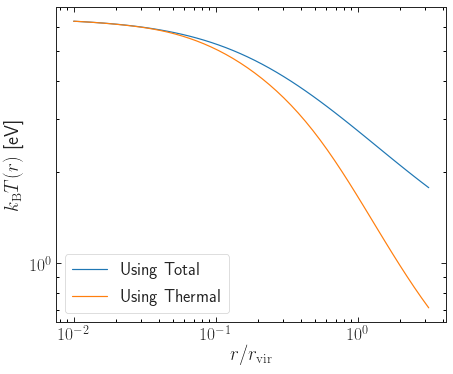

In [154]:
# let's look at the temperature profile assuming total and thermal pressure are equal for a halo of one mass

ind = 40
print(np.log10(mvirs[ind]))

mvir = mvirs[ind]
zobs = 0.0
conc = concs[ind]
print(conc)
Rvir = mass_so.M_to_R(mvir, zobs, 'vir')

nr = 50
rads = np.logspace(-2,0.5,nr)*Rvir


Tg = mu_plasma * mp_kev_by_kms2 * (1. - fnths[ind,:]) * sig2tots[ind,0,:] #Tgasz * theta(rad)**(Gamma(cvirs[mc]) - 1.0)
Mdf, Rdef, _ = mass_defs.changeMassDefinition(mvirs[ind], c=conc, z=zobs, mdef_in='vir', mdef_out='500c')
rds = np.logspace(np.log10(0.01),np.log10(10), 100)*Rdef
Tgf = interp(rds, Tg) # these are in physical units, can divide by Rvir

    
Tgas_vals = Tgas(rads, mvir, conc, Rvir)
loglogplot()
plt.plot(rads/Rvir, Tgas_vals*boltzmann, label='Using Total')
plt.plot(rads/Rvir, Tgf(rads), label='Using Thermal')
plt.xlabel(r'$r/r_\mathrm{vir}$')
plt.ylabel(r'$k_\mathrm{B} T(r)$ [eV]')
plt.legend()

In [286]:
ind = 40
print(np.log10(mvirs[ind]))

mvir = mvirs[ind]
zobs = 0.0
conc = concs[ind]
print(conc)
Rvir = mass_so.M_to_R(mvir, zobs, 'vir')

nr = 50
rads = np.logspace(-2,0.5,nr)*Rvir


Tg = mu_plasma * mp_kev_by_kms2 * (1. - fnths[ind,:]) * sig2tots[ind,0,:] #Tgasz * theta(rad)**(Gamma(cvirs[mc]) - 1.0)
Mdf, Rdef, _ = mass_defs.changeMassDefinition(mvirs[ind], c=conc, z=zobs, mdef_in='vir', mdef_out='500c')
rds = np.logspace(np.log10(0.01),np.log10(10), 100)*Rdef
Tgf = interp(rds, Tg) # these are in physical units, can divide by Rvir

    
Tgas_vals = Tgas(rads, mvir, conc, Rvir)
loglogplot()
plt.plot(rads/Rvir, Tgas_vals*boltzmann, label='Using Total')
plt.plot(rads/Rvir, Tgf(rads), label='Using Thermal')
plt.xlabel(r'$r/r_\mathrm{vir}$')
plt.ylabel(r'$k_\mathrm{B} T(r)$ [eV]')
plt.legend()

14.70321
5.5669445184244255


ValueError: operands could not be broadcast together with shapes (500,) (100,) 

In [330]:
# CURRENT NEXT STEPS:
# 1. Figure out why the thermal temperature vs. gas mass scaling is so different from when I was using K-S model for temp
#    ---> DONE
# 2. Once we are happy with this, write code to compute the observables at different apertures
# 3. Run analysis on Grace
# 4. Generate plot requested by Daisuke
# 5. Study relaxed/MARs
# 6. Consider looking into using ludlow model to see if there is sensitivity to concentration model
# 7. Once comfortable with physical intuition, write paper!

In [332]:
cosmology.setCosmology('planck18')
print(cosmo)

Cosmology "planck18" 
    flat = True, Om0 = 0.3111, Ode0 = 0.6888, Ob0 = 0.0490, H0 = 67.66, sigma8 = 0.8102, ns = 0.9665
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


## Analysis of Grace Results

In [193]:
# going to look at the cluster radii evolution
# make sure that things agree with a couple of validation cases

In [227]:
# start by running the YSZ calculation using Y5R500c
# this is using the same set of masses as in the Grace run sample

cosmo = cosmology.setCosmology('planck18')
zobs = 0.0
M5R500c, YSZ5R500c, Ptots, Pths, yprofs, rads, fnths, _, _ = gen_YSZ(zobs, cosmo, mass_def='500c', rad_mult=5, timestep_factor=1, conc_model=zhao_vdb_conc, Nmah=9999, beta=beta_def, eta=eta_def, nrads=500, zi=6.)

# probably should verify that the other results agree as well: Mgas, Tmgas, Menc...

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [228]:
cosmo = cosmology.setCosmology('planck18')
zobs = 0.0
M500c, YSZ500c, Ptots, Pths, yprofs, rads, fnths, _, _ = gen_YSZ(zobs, cosmo, mass_def='500c', rad_mult=1, timestep_factor=1, conc_model=zhao_vdb_conc, Nmah=9999, beta=beta_def, eta=eta_def, nrads=500, zi=6.)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


[1.62592374] -22.64743414111161
[  1.62592374 -22.64743414]
0.037202206434938996 8.943721453541631
0.03356747302431619 8.035745474940637


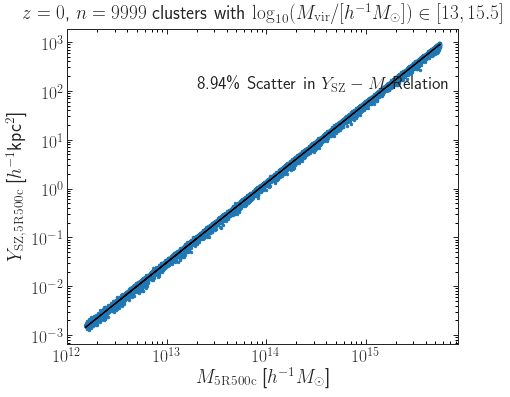

In [230]:
loglogplot()
plt.plot(M5R500c, YSZ5R500c, '.')

coeffs = np.polyfit(np.log10(M5R500c), np.log10(YSZ5R500c), deg=1)

reg = LinearRegression().fit(np.log10(M5R500c).reshape(-1, 1), np.log10(YSZ5R500c))
print(reg.coef_, reg.intercept_)
popt_log = [reg.intercept_, reg.coef_]

print(coeffs)
preds = 10**(coeffs[0]*np.log10(M5R500c) + coeffs[1])
plt.plot(M5R500c, preds, 'k')
plt.xlabel(r'$M_\mathrm{5R500c}$ [$h^{-1}M_\odot$]')
plt.ylabel(r'$Y_\mathrm{SZ,5R500c}$ [$h^{-1}$kpc$^2$]')


resids = np.log10(preds / YSZ5R500c)
scatter = np.std(resids)
rbscatter = (np.percentile(resids, 84) - np.percentile(resids, 16)) / 2.0
pc_scatter = (10**scatter -1) * 100
plt.text(2e13, 1e2, r'%.2f\%% Scatter in $Y_\mathrm{SZ}-M$ Relation' % pc_scatter, fontsize=18)
plt.title(r'$z=0$, $n=9999$ clusters with $\log_{10}(M_\mathrm{vir} / [h^{-1}M_\odot]) \in [13,15.5]$')

# let's also compute robust scatter

print(scatter,(10**scatter -1) * 100)
print(rbscatter,(10**rbscatter -1) * 100)

# over the full range, the answer is 8.94%, should get that exactly for Y_SZ - M reln for 5R500c from grace run

# we got EXACTLY the same from the full Grace run!

[1.66827178] -22.714297703752216
[  1.66827178 -22.7142977 ]
0.024255599504318843 5.743967124224336
0.01777265453987319 4.1771937492090405


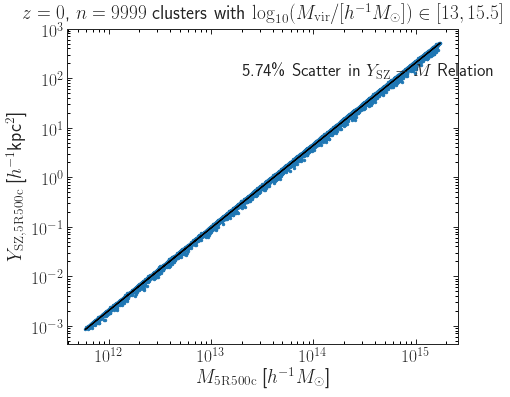

In [231]:
loglogplot()
plt.plot(M500c, YSZ500c, '.')

coeffs = np.polyfit(np.log10(M500c), np.log10(YSZ500c), deg=1)

reg = LinearRegression().fit(np.log10(M500c).reshape(-1, 1), np.log10(YSZ500c))
print(reg.coef_, reg.intercept_)
popt_log = [reg.intercept_, reg.coef_]

print(coeffs)
preds = 10**(coeffs[0]*np.log10(M500c) + coeffs[1])
plt.plot(M500c, preds, 'k')
plt.xlabel(r'$M_\mathrm{5R500c}$ [$h^{-1}M_\odot$]')
plt.ylabel(r'$Y_\mathrm{SZ,5R500c}$ [$h^{-1}$kpc$^2$]')


resids = np.log10(preds / YSZ500c)
scatter = np.std(resids)
rbscatter = (np.percentile(resids, 84) - np.percentile(resids, 16)) / 2.0
pc_scatter = (10**scatter -1) * 100
plt.text(2e13, 1e2, r'%.2f\%% Scatter in $Y_\mathrm{SZ}-M$ Relation' % pc_scatter, fontsize=18)
plt.title(r'$z=0$, $n=9999$ clusters with $\log_{10}(M_\mathrm{vir} / [h^{-1}M_\odot]) \in [13,15.5]$')

# let's also compute robust scatter

print(scatter,(10**scatter -1) * 100)
print(rbscatter,(10**rbscatter -1) * 100)

# 5.74% scatter using this sample that goes to lower mass, versus 6.36%

In [249]:
#function to compute scatter, slope, normalization given masses and an observable (and a zero point, set to 1 for now)
def compute_fit(masses, obs, zero_point=1.):
    coeffs = np.polyfit(np.log10(masses), np.log10(obs), deg=1)
    preds = 10**(coeffs[0]*np.log10(masses) + coeffs[1])
    resids = np.log10(preds / obs)
    scatter = np.std(resids)
    pc_scatter = (10**scatter - 1) * 100
    robust_scatter = (np.percentile(resids, 84) - np.percentile(resids, 16)) / 2.0
    pc_rbscatter = (10**robust_scatter - 1) * 100
    return coeffs[0], coeffs[1], pc_scatter, pc_rbscatter

# function to generate the plot of interest
# data from each cosmology will be 4xN_mah x N_rads
# the cosmologies are below
radii_definitions = [('vir', 1), ('500c', 1), ('500c', 2), ('500c', 3), ('500c', 4), ('500c', 5),
                     ('200m', 0.5), ('200m', 0.875), ('200m', 1.0), ('200m', 1.25), ('200m', 1.625),
                     ('200m', 2.0)]
cosmos = ['planck18', 'planck18_vhO', 'planck18_vhS', 'planck18_lO', 'planck18_hO', 'planck18_lS',
          'planck18_hS', 'planck18_lH', 'planck18_hH'] # this will be changed when we add vlO, vlS
fancy_cosmos = ['Fiducial', r'$\Omega_\mathrm{m}=0.5$', r'$\sigma_8 = 1.2$', r'$\Omega_\mathrm{m}=0.25$',
                r'$\Omega_\mathrm{m}=0.35$', r'$\sigma_8 = 0.7$', r'$\sigma_8 = 0.9$', r'$H_0 = 0.65$',
                r'$H_0=0.75$']


# we're going to want to make several versions of this plot
# 3x3 fixed M500c as the comparison using the 500c radii
# 3x3 varied mass aperture
# 3x3  fixed M200m as the comparison using the 200m radii
# 3x3 varied mass aperture using 200m as the base

# DAISUKE WANTS PLOTS THAT ILLUSTRATE DEPENDENCE ON COSMOLOGICAL PARAMS

In [259]:
# let's focus just in the reasonable cosmologies

cosmos = ['planck18', 'planck18_lO', 'planck18_hO', 'planck18_lS',
          'planck18_hS', 'planck18_lH', 'planck18_hH'] # this will be changed when we add vlO, vlS
fancy_cosmos = ['Fiducial', r'$\Omega_\mathrm{m}=0.25$',
                r'$\Omega_\mathrm{m}=0.35$', r'$\sigma_8 = 0.7$', r'$\sigma_8 = 0.9$', r'$H_0 = 0.65$',
                r'$H_0=0.75$']

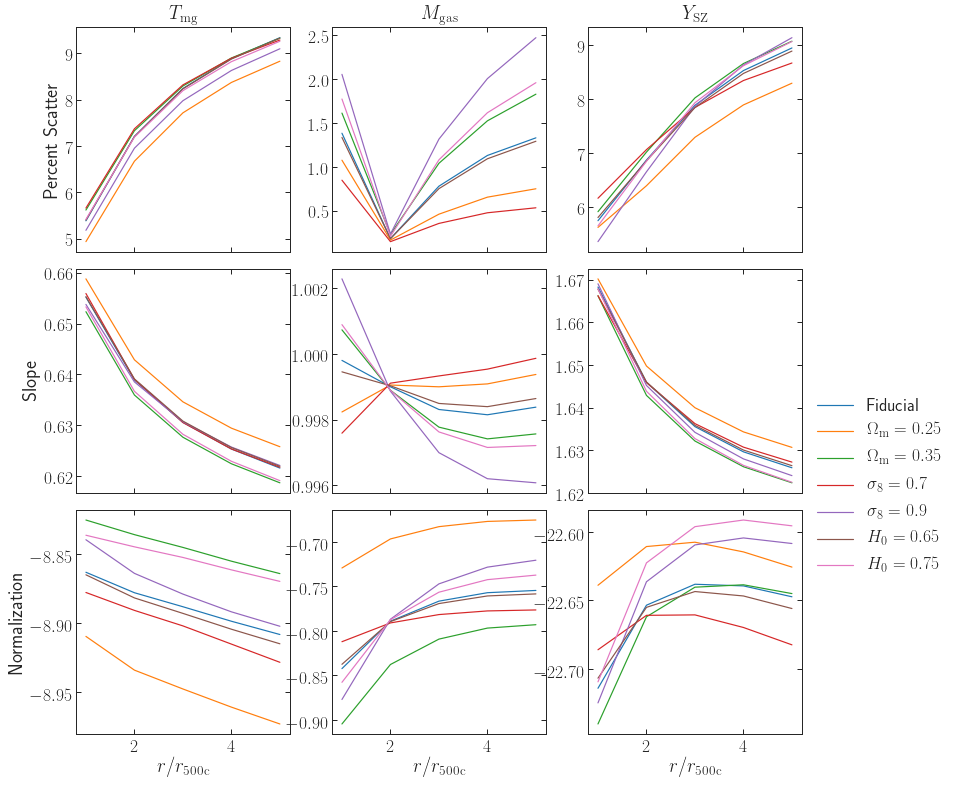

In [263]:
# we'll vary the slope/norm/scatter top to bottom and the observable left to right

current_palette = sns.color_palette()

def plot_3x3_crits_varyM():
    fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(13,13), sharex=True, gridspec_kw={'wspace':0.2,'hspace':0.075})
    for i in range(0,3):
        for j in range(0,3):
            ax[i,j].yaxis.set_ticks_position('both')
            ax[i,j].xaxis.set_ticks_position('both')
            ax[i,j].tick_params(axis='both', which='minor', colors='black', width=1.0, length=2.0)
            #ax[i,j].loglog()
            #ax[i,j].set_ylim(np.log10(2.5e-4),np.log10(0.8))
            ax[i,j].set_xlim(0.8, 5.2)
            
    # loop over cosmology
    for i,cs in enumerate(cosmos):
        cosmo = cosmology.setCosmology(cs)
        # load in the data
        data = np.load(obs_data_dir / ('%s_data.npy' % cs))
        # loop over observables (mass_enc, Tmgasv, Mgasv, YSZv)
        for j in range(1,4):
            # loop over the radius, these will be the r500c multiples (five of them here)
            mult = np.zeros(5)
            slopes = np.zeros(5)
            norms = np.zeros(5)
            pc_scatters = np.zeros(5)
            pc_rbscatters = np.zeros(5)
            for k in range(1,6):
                mult[k-1] = radii_definitions[k][1]
                slopes[k-1], norms[k-1], pc_scatters[k-1], pc_rbscatters[k-1] = compute_fit(
                    data[0,:,k], data[j,:,k], zero_point=1.) # TODO: figure out what to do with the zero point
            ax[0,j-1].plot(mult, pc_scatters, color=current_palette[i], label=fancy_cosmos[i]) # TODO: replace this with cosmo params
            ax[1,j-1].plot(mult, slopes, color=current_palette[i], label=fancy_cosmos[i]) # TODO: replace this with cosmo params
            ax[2,j-1].plot(mult, norms, color=current_palette[i], label=fancy_cosmos[i]) # TODO: replace this with cosmo params
            
    ax[1,2].legend(frameon=False, bbox_to_anchor=(1, 0.5))
    for i in range(0,3):
        ax[2,i].set_xlabel(r'$r/r_\mathrm{500c}$')
    ax[0,0].set_ylabel(r'Percent Scatter')
    ax[1,0].set_ylabel(r'Slope')
    ax[2,0].set_ylabel(r'Normalization')
    ax[0,0].set_title(r'$T_\mathrm{mg}$')
    ax[0,1].set_title(r'$M_\mathrm{gas}$')
    ax[0,2].set_title(r'$Y_\mathrm{SZ}$')

plot_3x3_crits_varyM()

# this is with varied apertures for the mass as well, and using the 500c as base

# The reason why Mgas behaves the way it does is because Mgas is pegged to equal Mvir at Rvir

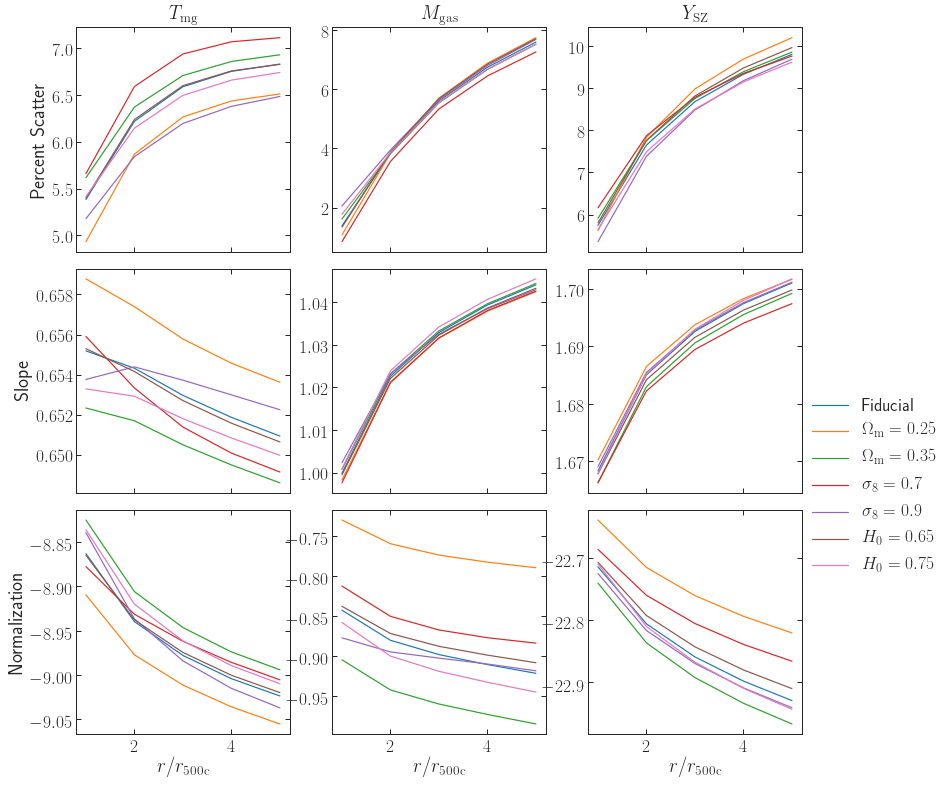

In [269]:
# let's do this where we hold the mass fixed at M500c

def plot_3x3_crits_fixM():
    fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(13,13), sharex=True, gridspec_kw={'wspace':0.2,'hspace':0.075})
    for i in range(0,3):
        for j in range(0,3):
            ax[i,j].yaxis.set_ticks_position('both')
            ax[i,j].xaxis.set_ticks_position('both')
            ax[i,j].tick_params(axis='both', which='minor', colors='black', width=1.0, length=2.0)
            #ax[i,j].loglog()
            #ax[i,j].set_ylim(np.log10(2.5e-4),np.log10(0.8))
            ax[i,j].set_xlim(0.8, 5.2)
            
    # loop over cosmology
    for i,cs in enumerate(cosmos):
        cosmo = cosmology.setCosmology(cs)
        # load in the data
        data = np.load(obs_data_dir / ('%s_data.npy' % cs))
        # loop over observables (mass_enc, Tmgasv, Mgasv, YSZv)
        for j in range(1,4):
            # loop over the radius, these will be the r500c multiples (five of them here)
            mult = np.zeros(5)
            slopes = np.zeros(5)
            norms = np.zeros(5)
            pc_scatters = np.zeros(5)
            pc_rbscatters = np.zeros(5)
            for k in range(1,6):
                mult[k-1] = radii_definitions[k][1]
                slopes[k-1], norms[k-1], pc_scatters[k-1], pc_rbscatters[k-1] = compute_fit(
                    data[0,:,1], data[j,:,k], zero_point=1.) # TODO: figure out what to do with the zero point
            ax[0,j-1].plot(mult, pc_scatters, color=current_palette[i], label=fancy_cosmos[i]) # TODO: replace this with cosmo params
            ax[1,j-1].plot(mult, slopes, color=current_palette[i], label=fancy_cosmos[i]) # TODO: replace this with cosmo params
            ax[2,j-1].plot(mult, norms, color=current_palette[i], label=fancy_cosmos[i]) # TODO: replace this with cosmo params
            
    ax[1,2].legend(frameon=False, bbox_to_anchor=(1.7, 0.5))
    for i in range(0,3):
        ax[2,i].set_xlabel(r'$r/r_\mathrm{500c}$')
    ax[0,0].set_ylabel(r'Percent Scatter')
    ax[1,0].set_ylabel(r'Slope')
    ax[2,0].set_ylabel(r'Normalization')
    ax[0,0].set_title(r'$T_\mathrm{mg}$')
    ax[0,1].set_title(r'$M_\mathrm{gas}$')
    ax[0,2].set_title(r'$Y_\mathrm{SZ}$')

plot_3x3_crits_fixM()

In [ ]:
radii_definitions = [('vir', 1), ('500c', 1), ('500c', 2), ('500c', 3), ('500c', 4), ('500c', 5),
                     ('200m', 0.5), ('200m', 0.875), ('200m', 1.0), ('200m', 1.25), ('200m', 1.625),
                     ('200m', 2.0)]

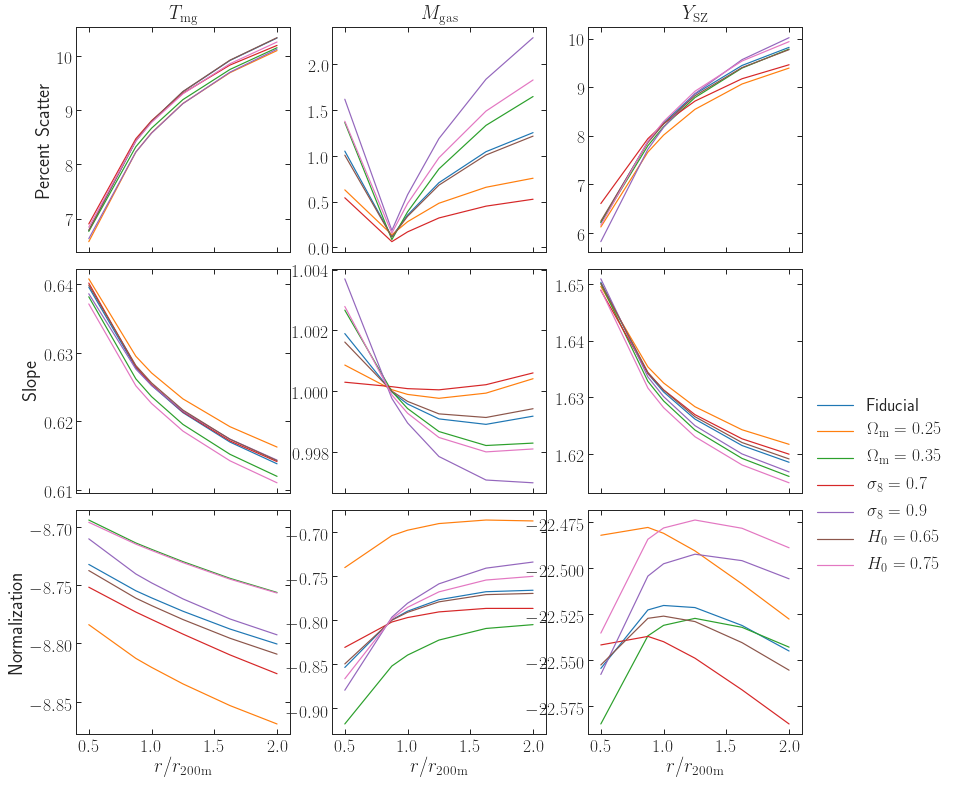

In [272]:
# this is with mean but varying

def plot_3x3_means_varyM():
    fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(13,13), sharex=True, gridspec_kw={'wspace':0.2,'hspace':0.075})
    for i in range(0,3):
        for j in range(0,3):
            ax[i,j].yaxis.set_ticks_position('both')
            ax[i,j].xaxis.set_ticks_position('both')
            ax[i,j].tick_params(axis='both', which='minor', colors='black', width=1.0, length=2.0)
            #ax[i,j].loglog()
            #ax[i,j].set_ylim(np.log10(2.5e-4),np.log10(0.8))
            ax[i,j].set_xlim(0.4, 2.1)
            
    # loop over cosmology
    for i,cs in enumerate(cosmos):
        cosmo = cosmology.setCosmology(cs)
        # load in the data
        data = np.load(obs_data_dir / ('%s_data.npy' % cs))
        # loop over observables (mass_enc, Tmgasv, Mgasv, YSZv)
        for j in range(1,4):
            # loop over the radius, these will be the r500c multiples (five of them here)
            mult = np.zeros(6)
            slopes = np.zeros(6)
            norms = np.zeros(6)
            pc_scatters = np.zeros(6)
            pc_rbscatters = np.zeros(6)
            for k in range(6,12):
                mult[k-6] = radii_definitions[k][1]
                slopes[k-6], norms[k-6], pc_scatters[k-6], pc_rbscatters[k-6] = compute_fit(
                    data[0,:,k], data[j,:,k], zero_point=1.) # TODO: figure out what to do with the zero point
            ax[0,j-1].plot(mult, pc_scatters, color=current_palette[i], label=fancy_cosmos[i]) # TODO: replace this with cosmo params
            ax[1,j-1].plot(mult, slopes, color=current_palette[i], label=fancy_cosmos[i]) # TODO: replace this with cosmo params
            ax[2,j-1].plot(mult, norms, color=current_palette[i], label=fancy_cosmos[i]) # TODO: replace this with cosmo params
            
    ax[1,2].legend(frameon=False, bbox_to_anchor=(1, 0.5))
    for i in range(0,3):
        ax[2,i].set_xlabel(r'$r/r_\mathrm{200m}$')
    ax[0,0].set_ylabel(r'Percent Scatter')
    ax[1,0].set_ylabel(r'Slope')
    ax[2,0].set_ylabel(r'Normalization')
    ax[0,0].set_title(r'$T_\mathrm{mg}$')
    ax[0,1].set_title(r'$M_\mathrm{gas}$')
    ax[0,2].set_title(r'$Y_\mathrm{SZ}$')

plot_3x3_means_varyM()

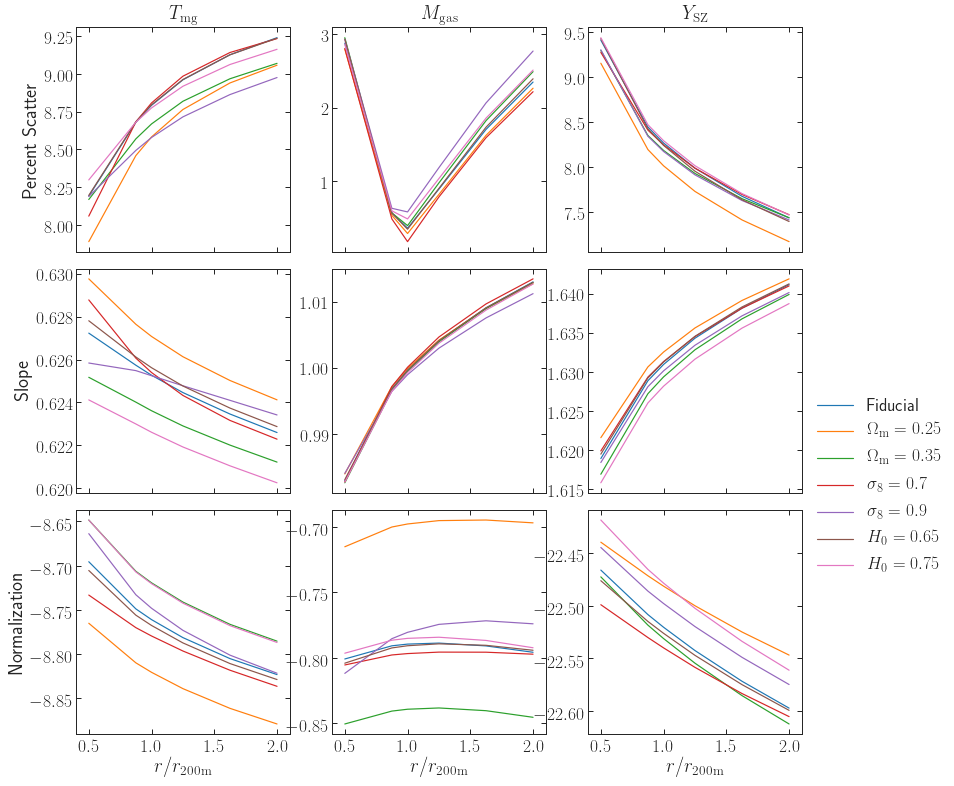

In [273]:
def plot_3x3_means_fixM():
    fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(13,13), sharex=True, gridspec_kw={'wspace':0.2,'hspace':0.075})
    for i in range(0,3):
        for j in range(0,3):
            ax[i,j].yaxis.set_ticks_position('both')
            ax[i,j].xaxis.set_ticks_position('both')
            ax[i,j].tick_params(axis='both', which='minor', colors='black', width=1.0, length=2.0)
            #ax[i,j].loglog()
            #ax[i,j].set_ylim(np.log10(2.5e-4),np.log10(0.8))
            ax[i,j].set_xlim(0.4, 2.1)
            
    # loop over cosmology
    for i,cs in enumerate(cosmos):
        cosmo = cosmology.setCosmology(cs)
        # load in the data
        data = np.load(obs_data_dir / ('%s_data.npy' % cs))
        # loop over observables (mass_enc, Tmgasv, Mgasv, YSZv)
        for j in range(1,4):
            # loop over the radius, these will be the r500c multiples (five of them here)
            mult = np.zeros(6)
            slopes = np.zeros(6)
            norms = np.zeros(6)
            pc_scatters = np.zeros(6)
            pc_rbscatters = np.zeros(6)
            for k in range(6,12):
                mult[k-6] = radii_definitions[k][1]
                slopes[k-6], norms[k-6], pc_scatters[k-6], pc_rbscatters[k-6] = compute_fit(
                    data[0,:,8], data[j,:,k], zero_point=1.) # TODO: figure out what to do with the zero point
            ax[0,j-1].plot(mult, pc_scatters, color=current_palette[i], label=fancy_cosmos[i]) # TODO: replace this with cosmo params
            ax[1,j-1].plot(mult, slopes, color=current_palette[i], label=fancy_cosmos[i]) # TODO: replace this with cosmo params
            ax[2,j-1].plot(mult, norms, color=current_palette[i], label=fancy_cosmos[i]) # TODO: replace this with cosmo params
            
    ax[1,2].legend(frameon=False, bbox_to_anchor=(1, 0.5))
    for i in range(0,3):
        ax[2,i].set_xlabel(r'$r/r_\mathrm{200m}$')
    ax[0,0].set_ylabel(r'Percent Scatter')
    ax[1,0].set_ylabel(r'Slope')
    ax[2,0].set_ylabel(r'Normalization')
    ax[0,0].set_title(r'$T_\mathrm{mg}$')
    ax[0,1].set_title(r'$M_\mathrm{gas}$')
    ax[0,2].set_title(r'$Y_\mathrm{SZ}$')

plot_3x3_means_fixM()

In [242]:
# do the computations using testrun data to make sure things agree

planckdata = np.load(obs_data_dir / 'planck18_data.npy')

# should get 8.35 when looking at the 5R500c
# should get 5.99 when looking at R500c

# works for both test cases!!

In [243]:
planckdata.shape

(4, 9999, 12)

[1.62592374] -22.64743414111161
[  1.62592374 -22.64743414]
0.037202206434938996 8.943721453541631
0.03356747302431619 8.035745474940637


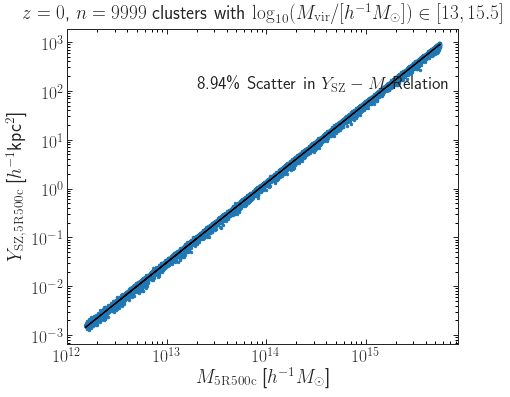

In [245]:
rad_ind = 5 #R500c
loglogplot()
plt.plot(planckdata[0,:,rad_ind], planckdata[3,:,rad_ind], '.')

coeffs = np.polyfit(np.log10(planckdata[0,:,rad_ind]), np.log10(planckdata[3,:,rad_ind]), deg=1)

reg = LinearRegression().fit(np.log10(planckdata[0,:,rad_ind]).reshape(-1, 1), np.log10(planckdata[3,:,rad_ind]))
print(reg.coef_, reg.intercept_)
popt_log = [reg.intercept_, reg.coef_]

print(coeffs)
preds = 10**(coeffs[0]*np.log10(planckdata[0,:,rad_ind]) + coeffs[1])
plt.plot(planckdata[0,:,rad_ind], preds, 'k')
plt.xlabel(r'$M_\mathrm{5R500c}$ [$h^{-1}M_\odot$]')
plt.ylabel(r'$Y_\mathrm{SZ,5R500c}$ [$h^{-1}$kpc$^2$]')


resids = np.log10(preds / planckdata[3,:,rad_ind])
scatter = np.std(resids)
rbscatter = (np.percentile(resids, 84) - np.percentile(resids, 16)) / 2.0
pc_scatter = (10**scatter -1) * 100
plt.text(2e13, 1e2, r'%.2f\%% Scatter in $Y_\mathrm{SZ}-M$ Relation' % pc_scatter, fontsize=18)
plt.title(r'$z=0$, $n=9999$ clusters with $\log_{10}(M_\mathrm{vir} / [h^{-1}M_\odot]) \in [13,15.5]$')

# let's also compute robust scatter

print(scatter,(10**scatter -1) * 100)
print(rbscatter,(10**rbscatter -1) * 100)

# They agree, great! Let's see if the same is true for M500

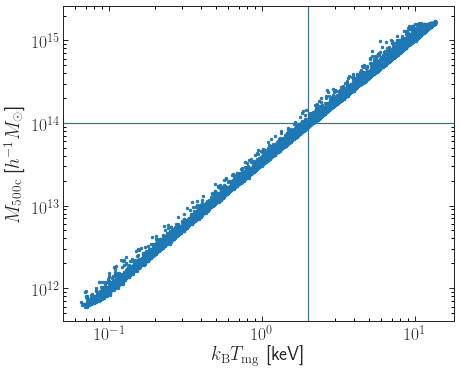

In [282]:
# let's look at T_mgas vs. M_500c
cosmo = cosmology.setCosmology('planck18')
data = np.load(obs_data_dir / 'planck18_data.npy')
loglogplot()
plt.plot(data[1,:,1], data[0,:,1], '.') # M_500c vs. T_mgas with M_500c aperture
compute_fit(data[0,:,1], data[1,:,1], zero_point=1.)
plt.ylabel(r'$M_\mathrm{500c}$ [$h^{-1} M_\odot$]')
plt.xlabel(r'$k_\mathrm{B}T_\mathrm{mg}$ [keV]')
plt.axvline(2)
plt.axhline(10**14)

[ 0.99199943 12.82766996]


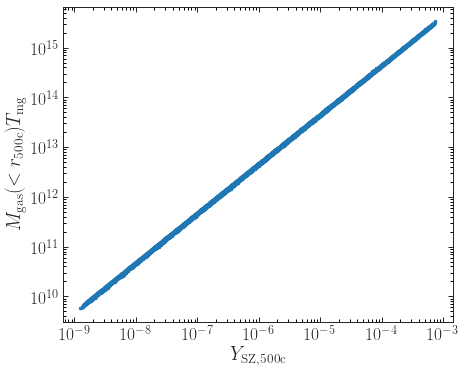

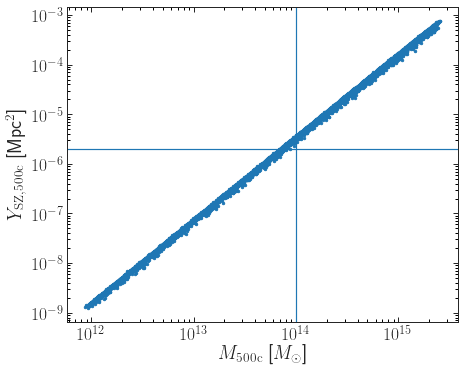

In [285]:
loglogplot()
plt.plot(data[3,:,1] / (cosmo.H0 / 100.) * 10**-6, data[1,:,1]*data[2,:,1], '.')
plt.xlabel(r'$Y_\mathrm{SZ, 500c}$')
plt.ylabel(r'$M_\mathrm{gas}(<r_\mathrm{500c})T_\mathrm{mg}$')
coeffs = np.polyfit(np.log10(data[3,:,1]), np.log10(data[1,:,1]*data[2,:,1]), deg=1)
print(coeffs)

# expect the slope should be close to 1, and indeed it is

loglogplot()
plt.plot(data[0,:,1] / (cosmo.H0 / 100.), data[3,:,1] / (cosmo.H0 / 100.) * 10**-6, '.')
plt.xlabel(r'$M_\mathrm{500c}$ [$M_\odot$]')
plt.ylabel(r'$Y_\mathrm{SZ,500c}$ [Mpc$^2$]')
plt.axvline(10**14)
plt.axhline(2*10**-6)